In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 12.1 MB/s eta 0:00:00


In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **ResNet18 implementation with hyperparameter tuning.**


---
In this code, data loading mechanism is taken from [this](https://github.com/GorkemP/labeled-images-for-ulcerative-colitis/tree/main) Github repository.
Hyperparameter tuning is applied to learning rate and weight decay. Tried parameters are:

*   Learning rate : {0.001,  0.0005, 0.0002}
*   Weight decay : {0.0, 0.001, 0.01}

Before training the model, dataset channel-wise mean and standard deviation is calculated so that each input can be normalized. Channel-wise mean and standard deviation are calculated and values are stored as vectors to not calculate it over and over again. Also, horizontal flipping and random rotation is applied to data as part of preprocessing step.

Details of the training and test results are given in the report.


In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from datetime import datetime
import time
import wandb
import argparse
import torchvision.models as models
import random
import numpy as np
from utils import UCMayo4, get_dataset_mean_and_std
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Setup directories and datasets
train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"

#channel_means, channel_stds = get_dataset_mean_and_std(train_dir)
channel_means=[0.416, 0.288, 0.219]
channel_stds=[0.299, 0.221, 0.178]

print("\nCreate weights directory for checkpoints!")
dirName = "weights"
try:
    os.makedirs(dirName)
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")

ModuleNotFoundError: No module named 'utils'

In [ ]:
# Function to set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# Create the training function that will use the hyperparameters defined in the sweep
def train_with_hyperparameters():
    wandb.init()
    config = wandb.config

    set_seed(35)

    # Hyperparameters
    batch_size = config.batch_size
    learning_rate = config.lr
    weight_decay = config.weight_decay
    model_name = config.model_name
    optimizer_name = config.optimizer
    num_classes = 4
    num_worker = 4
    num_epoch = 100
    best_acc = 0
    early_stopping_thresh = 15
    LRScheduling_patience = 10
    lrs_factor = 0.2
    best_threshold = 0.0001
    early_stop_counter = 0

    # Setup directories and datasets
    train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
    val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
    #print("hwhw")
    #channel_means, channel_stds = get_dataset_mean_and_std(train_dir)
    normalize = transforms.Normalize(mean=channel_means, std=channel_stds)
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-180, 180)),
        transforms.ToTensor(),
        normalize
    ])
    train_dataset = UCMayo4(train_dir, transform=train_transform, val_split=0.1, subset='train')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker, pin_memory=True)

    val_transform = transforms.Compose([transforms.ToTensor(), normalize])
    val_dataset = UCMayo4(val_dir, transform=val_transform, val_split=0.1, subset='val')
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker, pin_memory=True)

    test_dir = "/content/gdrive/My Drive/test_set"
    test_dataset = UCMayo4(test_dir, transform=val_transform,val_split=1, subset='val')
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker,
                                            pin_memory=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)
    # Setup the model
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model.to(device)

    # Setup optimizer and learning rate scheduler
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    if config.use_lrscheduling:
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=lrs_factor, patience=LRScheduling_patience, threshold=best_threshold, verbose=True)

    criterion = nn.CrossEntropyLoss()
    class_names = ["Mayo 0", "Mayo 1", "Mayo 2", "Mayo 3"]

    # Training loop
    for epoch in range(num_epoch):
        #print("hehehe")
        model.train()
        training_loss, train_correct = 0.0, 0
        i=0
        for data, target in train_loader:
            #print("train {}".format(i))
            #i+=1
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            prediction = output.argmax(dim=1, keepdim=True)
            train_correct += prediction.eq(target.view_as(prediction)).sum().item()
            training_loss += loss.item()
        training_loss /= len(train_loader)
        train_accuracy = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        y_true, y_pred = [], []
        #print("validation")
        with torch.no_grad():
            for data, target in val_loader:
                #print("validation")
                data, target = data.to(device), target.to(device)
                y_true.extend(target.cpu().tolist())
                output = model(data)
                loss = criterion(output, target)
                prediction = output.argmax(dim=1, keepdim=True)
                y_pred.extend(prediction.cpu().tolist())
                val_correct += prediction.eq(target.view_as(prediction)).sum().item()
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_accuracy = val_correct / len(val_loader.dataset)

        # Update the scheduler
        if config.use_lrscheduling:
            scheduler.step(val_accuracy)

        cm_4class = confusion_matrix(y_true, y_pred)
        all_kappa_score_weighted = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        flattened_preds = [item for sublist in y_pred for item in sublist] if isinstance(y_pred[0], list) else y_pred
        print("epoch: {:3.0f}".format(epoch + 1) + " | Train acc: {:4.2f}".format(
            train_accuracy * 100) + " | Val acc: {:4.2f}".format(
            val_accuracy * 100) + " | Train loss: {:6.4f}".format(
            training_loss) + " | Val loss: {:6.4f}".format(
            val_loss) + " | QWK Score: {:4.3f}".format(
            all_kappa_score_weighted) + " | Confusion matrix: {}".format(cm_4class))
        wandb.log({
            "epoch": epoch + 1,
            "lr": optimizer.param_groups[0]['lr'],
            'train loss': training_loss,
            'val loss': val_loss,
            'train acc': train_accuracy,
            'val acc': val_accuracy,
            'qwk_score': all_kappa_score_weighted,
            'conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=flattened_preds, class_names=class_names)
        })

        if val_accuracy > best_acc * (1 + best_threshold):
            early_stop_counter = 0
            best_acc = val_accuracy
            print("overwriting the best model!")
            wandb.run.summary["best accuracy"] = best_acc
            torch.save(model.state_dict(), "weights/best_" + model_name + '.pth.tar')
        else:
            early_stop_counter += 1
        if early_stop_counter >= early_stopping_thresh:
            model.eval()
            test_loss, test_correct = 0.0, 0
            y_true_test, y_pred_test = [], []
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    y_true_test.extend(target.cpu().tolist())
                    output = model(data)
                    loss = criterion(output, target)
                    prediction = output.argmax(dim=1, keepdim=True)
                    y_pred_test.extend(prediction.cpu().tolist())
                    test_correct += prediction.eq(target.view_as(prediction)).sum().item()
                    test_loss += loss.item()
            test_loss /= len(test_loader)
            test_accuracy = test_correct / len(test_loader.dataset)
            cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
            all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
            flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
            print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
                test_accuracy * 100) + " | Test loss: {:6.4f}".format(
                test_loss) + " | Test QWK Score: {:4.3f}".format(
                all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
            wandb.log({
                "test_lr": optimizer.param_groups[0]['lr'],
                'test loss': test_loss,
                'test acc': test_accuracy,
                'test_qwk_score': all_kappa_score_weighted_test,
                'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_names)
            })
            print("Early stopping at epoch {}".format(epoch + 1))
            break
    model.eval()
    test_loss, test_correct = 0.0, 0
    y_true_test, y_pred_test = [], []
    with torch.no_grad():
        for data, target in test_loader:
            #print("validation")
            data, target = data.to(device), target.to(device)
            y_true_test.extend(target.cpu().tolist())
            output = model(data)
            loss = criterion(output, target)
            prediction = output.argmax(dim=1, keepdim=True)
            y_pred_test.extend(prediction.cpu().tolist())
            test_correct += prediction.eq(target.view_as(prediction)).sum().item()
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(test_loader.dataset)
    cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
    all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
    flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
    print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
        test_accuracy * 100) + " | Test loss: {:6.4f}".format(
        test_loss) + " | Test QWK Score: {:4.3f}".format(
        all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
    wandb.log({
        "test_lr": optimizer.param_groups[0]['lr'],
        'test loss': test_loss,
        'test acc': test_accuracy,
        'test_qwk_score': all_kappa_score_weighted_test,
        'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_names)
    })
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {'values': [64]},
        'lr': {'values': [0.001, 0.0005, 0.0002]},
        'weight_decay': {'values': [0.0, 0.001, 0.01]},
        'model_name': {'values': ['ResNet18']},
        'optimizer': {'values': ['Adam']},
        'use_lrscheduling': {'values': [True]},
    }
}

# Initialize the sweep and start it
sweep_id = wandb.sweep(sweep_config, project='DI725-Project-EmreCakmakyurdu-UCS')
wandb.agent(sweep_id, train_with_hyperparameters)


Create sweep with ID: 0hj42wyh
Sweep URL: https://wandb.ai/di725/DI725-Project-EmreCakmakyurdu-UCS/sweeps/0hj42wyh


wandb: Agent Starting Run: y6y96qtq with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.001
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0
wandb: Currently logged in as: ecyurdu (di725). Use `wandb login --relogin` to force relogin


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

epoch:   1 | Train acc: 68.14 | Val acc: 68.72 | Train loss: 0.7251 | Val loss: 0.7063 | QWK Score: 0.773 | Confusion matrix: [[498   9   0   0]
 [173  75  14   1]
 [ 11  41  53   5]
 [  2   6  38  33]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 74.06 | Val acc: 75.50 | Train loss: 0.6006 | Val loss: 0.6364 | QWK Score: 0.854 | Confusion matrix: [[445  56   5   1]
 [ 64 152  41   6]
 [  1  14  59  36]
 [  0   0  11  68]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 74.81 | Val acc: 62.88 | Train loss: 0.5795 | Val loss: 1.0940 | QWK Score: 0.702 | Confusion matrix: [[375 100  11  21]
 [ 32 138  32  61]
 [  0   7  11  92]
 [  0   0   0  79]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 75.53 | Val acc: 66.53 | Train loss: 0.5633 | Val loss: 0.7767 | QWK Score: 0.765 | Confusion matrix: [[422  61  13  11]
 [ 81 109  48  25]
 [  1  10  30  69]
 [  0   0   2  77]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 75.98 | Val acc: 69.03 | Train loss: 0.5559 | Val loss: 0.7282 | QWK Score: 0.761 | Confusion matrix: [[497  10   0   0]
 [165  82  16   0]
 [ 18  31  55   6]
 [  3   4  44  28]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 76.91 | Val acc: 75.70 | Train loss: 0.5317 | Val loss: 0.5819 | QWK Score: 0.827 | Confusion matrix: [[467  40   0   0]
 [ 85 164  14   0]
 [  3  47  55   5]
 [  1   8  30  40]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 76.19 | Val acc: 67.99 | Train loss: 0.5339 | Val loss: 0.7741 | QWK Score: 0.606 | Confusion matrix: [[474  33   0   0]
 [116 146   1   0]
 [ 18  82   3   7]
 [ 21  15  14  29]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 76.93 | Val acc: 72.37 | Train loss: 0.5304 | Val loss: 0.6285 | QWK Score: 0.830 | Confusion matrix: [[385 114   5   3]
 [ 32 179  47   5]
 [  0  15  62  33]
 [  0   0  11  68]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 77.65 | Val acc: 72.78 | Train loss: 0.5131 | Val loss: 0.5922 | QWK Score: 0.797 | Confusion matrix: [[476  31   0   0]
 [ 93 167   3   0]
 [  1  89  10  10]
 [  0  16  18  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 77.53 | Val acc: 73.10 | Train loss: 0.5210 | Val loss: 0.6398 | QWK Score: 0.795 | Confusion matrix: [[481  26   0   0]
 [110 143   8   2]
 [  7  63  22  18]
 [  5   6  13  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 77.51 | Val acc: 76.33 | Train loss: 0.5179 | Val loss: 0.5962 | QWK Score: 0.868 | Confusion matrix: [[444  60   3   0]
 [ 56 147  58   2]
 [  0  12  79  19]
 [  0   0  17  62]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 77.91 | Val acc: 73.72 | Train loss: 0.5093 | Val loss: 0.6098 | QWK Score: 0.820 | Confusion matrix: [[473  34   0   0]
 [103 143  16   1]
 [  4  44  49  13]
 [  1   7  29  42]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 78.58 | Val acc: 76.75 | Train loss: 0.4952 | Val loss: 0.5355 | QWK Score: 0.861 | Confusion matrix: [[463  42   1   1]
 [ 92 144  23   4]
 [  1  23  68  18]
 [  0   0  18  61]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 78.35 | Val acc: 75.08 | Train loss: 0.4894 | Val loss: 0.5849 | QWK Score: 0.853 | Confusion matrix: [[456  45   4   2]
 [ 82 131  49   1]
 [  0  16  73  21]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 78.36 | Val acc: 77.69 | Train loss: 0.4895 | Val loss: 0.5204 | QWK Score: 0.873 | Confusion matrix: [[432  74   0   1]
 [ 47 187  27   2]
 [  0  26  55  29]
 [  0   1   7  71]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 78.33 | Val acc: 73.83 | Train loss: 0.4859 | Val loss: 0.6907 | QWK Score: 0.792 | Confusion matrix: [[414  74   7  12]
 [ 49 157  44  13]
 [  0  15  66  29]
 [  0   1   7  71]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 78.50 | Val acc: 74.97 | Train loss: 0.4905 | Val loss: 0.5845 | QWK Score: 0.839 | Confusion matrix: [[430  67  10   0]
 [ 64 159  39   1]
 [  0  15  88   7]
 [  0   0  37  42]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 79.25 | Val acc: 72.05 | Train loss: 0.4752 | Val loss: 0.6295 | QWK Score: 0.816 | Confusion matrix: [[491  15   0   1]
 [134 105  11  13]
 [  6  30  23  51]
 [  3   3   1  72]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 78.84 | Val acc: 75.39 | Train loss: 0.4843 | Val loss: 0.5565 | QWK Score: 0.823 | Confusion matrix: [[474  33   0   0]
 [105 139  18   1]
 [  2  29  70   9]
 [  4   5  30  40]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 79.47 | Val acc: 72.89 | Train loss: 0.4737 | Val loss: 0.6372 | QWK Score: 0.753 | Confusion matrix: [[476  30   1   0]
 [112 141   9   1]
 [ 10  56  38   6]
 [ 10   6  19  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 79.20 | Val acc: 75.70 | Train loss: 0.4783 | Val loss: 0.5708 | QWK Score: 0.851 | Confusion matrix: [[439  60   6   2]
 [ 70 153  37   3]
 [  0  16  69  25]
 [  0   0  14  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 80.00 | Val acc: 77.89 | Train loss: 0.4664 | Val loss: 0.5336 | QWK Score: 0.860 | Confusion matrix: [[469  36   1   1]
 [ 80 162  19   2]
 [  2  27  64  17]
 [  1   0  26  52]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 79.17 | Val acc: 74.56 | Train loss: 0.4752 | Val loss: 0.6399 | QWK Score: 0.855 | Confusion matrix: [[404 100   2   1]
 [ 34 163  64   2]
 [  0   7  85  18]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 79.33 | Val acc: 76.75 | Train loss: 0.4655 | Val loss: 0.5474 | QWK Score: 0.857 | Confusion matrix: [[429  78   0   0]
 [ 46 195  21   1]
 [  1  35  57  17]
 [  0   4  20  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 80.11 | Val acc: 75.81 | Train loss: 0.4642 | Val loss: 0.5637 | QWK Score: 0.858 | Confusion matrix: [[415  90   1   1]
 [ 43 189  28   3]
 [  0  22  62  26]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 79.94 | Val acc: 75.18 | Train loss: 0.4609 | Val loss: 0.5339 | QWK Score: 0.855 | Confusion matrix: [[412  93   1   1]
 [ 50 181  31   1]
 [  0  25  64  21]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 80.37 | Val acc: 71.32 | Train loss: 0.4572 | Val loss: 0.6709 | QWK Score: 0.781 | Confusion matrix: [[483  24   0   0]
 [136 111  16   0]
 [ 11  47  46   6]
 [  3   8  24  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 80.12 | Val acc: 72.16 | Train loss: 0.4512 | Val loss: 0.6598 | QWK Score: 0.819 | Confusion matrix: [[402  97   4   4]
 [ 45 169  32  17]
 [  1  11  47  51]
 [  0   0   5  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 79.85 | Val acc: 75.70 | Train loss: 0.4606 | Val loss: 0.5543 | QWK Score: 0.845 | Confusion matrix: [[467  39   1   0]
 [ 88 160  13   2]
 [  2  46  54   8]
 [  0   2  32  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 80.43 | Val acc: 73.93 | Train loss: 0.4481 | Val loss: 0.6267 | QWK Score: 0.850 | Confusion matrix: [[418  86   2   1]
 [ 42 169  40  12]
 [  0  12  46  52]
 [  0   0   3  76]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 79.98 | Val acc: 76.43 | Train loss: 0.4522 | Val loss: 0.5502 | QWK Score: 0.847 | Confusion matrix: [[474  33   0   0]
 [ 89 160  13   1]
 [  1  53  38  18]
 [  1   7  10  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 80.34 | Val acc: 72.05 | Train loss: 0.4525 | Val loss: 0.6970 | QWK Score: 0.831 | Confusion matrix: [[402  92  11   2]
 [ 33 151  74   5]
 [  0   8  65  37]
 [  0   0   6  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 80.48 | Val acc: 76.23 | Train loss: 0.4392 | Val loss: 0.5266 | QWK Score: 0.856 | Confusion matrix: [[440  64   3   0]
 [ 71 163  27   2]
 [  0  25  68  17]
 [  0   3  16  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 83.32 | Val acc: 78.83 | Train loss: 0.3922 | Val loss: 0.5011 | QWK Score: 0.880 | Confusion matrix: [[464  43   0   0]
 [ 76 159  27   1]
 [  1  18  74  17]
 [  0   1  19  59]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 83.14 | Val acc: 79.77 | Train loss: 0.3788 | Val loss: 0.5135 | QWK Score: 0.884 | Confusion matrix: [[470  36   1   0]
 [ 75 157  29   2]
 [  2  16  71  21]
 [  0   1  11  67]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 83.33 | Val acc: 78.42 | Train loss: 0.3746 | Val loss: 0.5238 | QWK Score: 0.872 | Confusion matrix: [[472  35   0   0]
 [ 90 152  20   1]
 [  1  20  78  11]
 [  0   2  27  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 84.23 | Val acc: 78.83 | Train loss: 0.3670 | Val loss: 0.5073 | QWK Score: 0.875 | Confusion matrix: [[460  47   0   0]
 [ 77 167  18   1]
 [  1  22  71  16]
 [  0   3  18  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 83.77 | Val acc: 79.46 | Train loss: 0.3643 | Val loss: 0.5169 | QWK Score: 0.878 | Confusion matrix: [[467  40   0   0]
 [ 75 163  24   1]
 [  1  20  80   9]
 [  0   2  25  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 84.20 | Val acc: 78.73 | Train loss: 0.3593 | Val loss: 0.5275 | QWK Score: 0.878 | Confusion matrix: [[461  45   1   0]
 [ 72 158  32   1]
 [  1  16  81  12]
 [  0   0  24  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 84.82 | Val acc: 77.48 | Train loss: 0.3550 | Val loss: 0.5464 | QWK Score: 0.870 | Confusion matrix: [[444  62   1   0]
 [ 63 172  27   1]
 [  0  23  72  15]
 [  0   1  23  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 85.10 | Val acc: 78.31 | Train loss: 0.3499 | Val loss: 0.5372 | QWK Score: 0.871 | Confusion matrix: [[460  46   1   0]
 [ 80 157  25   1]
 [  2  19  76  13]
 [  0   2  19  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 84.81 | Val acc: 78.31 | Train loss: 0.3408 | Val loss: 0.5633 | QWK Score: 0.867 | Confusion matrix: [[458  48   1   0]
 [ 71 167  24   1]
 [  1  27  72  10]
 [  0   3  22  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 85.52 | Val acc: 78.21 | Train loss: 0.3389 | Val loss: 0.5737 | QWK Score: 0.872 | Confusion matrix: [[424  82   1   0]
 [ 45 190  27   1]
 [  0  21  74  15]
 [  0   2  15  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 85.19 | Val acc: 78.31 | Train loss: 0.3405 | Val loss: 0.5559 | QWK Score: 0.868 | Confusion matrix: [[459  48   0   0]
 [ 73 167  22   1]
 [  1  26  73  10]
 [  0   3  24  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 85.39 | Val acc: 78.10 | Train loss: 0.3416 | Val loss: 0.5530 | QWK Score: 0.868 | Confusion matrix: [[462  43   2   0]
 [ 79 163  20   1]
 [  1  31  62  16]
 [  0   3  14  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 85.23 | Val acc: 77.48 | Train loss: 0.3350 | Val loss: 0.5779 | QWK Score: 0.864 | Confusion matrix: [[443  63   1   0]
 [ 68 165  29   1]
 [  1  21  77  11]
 [  0   3  18  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 86.62 | Val acc: 78.21 | Train loss: 0.3096 | Val loss: 0.5663 | QWK Score: 0.868 | Confusion matrix: [[452  54   1   0]
 [ 74 168  20   1]
 [  1  27  71  11]
 [  0   3  17  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  48 | Train acc: 87.07 | Val acc: 77.37 | Train loss: 0.3000 | Val loss: 0.5754 | QWK Score: 0.860 | Confusion matrix: [[448  58   1   0]
 [ 73 168  21   1]
 [  1  28  73   8]
 [  0   3  23  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  49 | Train acc: 87.14 | Val acc: 78.00 | Train loss: 0.2998 | Val loss: 0.5789 | QWK Score: 0.864 | Confusion matrix: [[452  54   1   0]
 [ 71 170  21   1]
 [  1  30  68  11]
 [  0   4  17  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Train acc: 87.39 | Val acc: 78.42 | Train loss: 0.2971 | Val loss: 0.5890 | QWK Score: 0.865 | Confusion matrix: [[451  55   1   0]
 [ 70 170  22   1]
 [  1  26  75   8]
 [  0   4  19  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Test acc: 77.16 | Test loss: 0.5863 | Test QWK Score: 0.847 | Test Confusion matrix: [[819 104   1   1]
 [131 301  27   5]
 [  3  41 109  24]
 [  0   2  46  72]]
Early stopping at epoch 50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Test acc: 77.16 | Test loss: 0.5863 | Test QWK Score: 0.847 | Test Confusion matrix: [[819 104   1   1]
 [131 301  27   5]
 [  3  41 109  24]
 [  0   2  46  72]]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,██████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁
qwk_score,▅▇▃▅▇▁▇▆█▆█▇▆▇▆▇▇▇▇▇▇▅▆▇▇▇▇███████████▇█
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇███
train loss,█▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁
val acc,▃▆▁▃▆▃▅▅▇▆▇▆▆▆▅▆▆▇▆▇▆▅▅▆▇▅▇███████▇█▇▇▇█
val loss,▃▃█▄▂▄▃▂▂▂▁▂▃▂▃▂▂▁▃▂▁▃▃▂▂▃▁▁▁▁▁▁▁▂▂▂▂▂▂▂


wandb: Agent Starting Run: k17n1ybe with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.001
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0.001


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 67.50 | Val acc: 67.57 | Train loss: 0.7503 | Val loss: 0.7384 | QWK Score: 0.735 | Confusion matrix: [[454  47   6   0]
 [120 119  24   0]
 [  6  32  72   0]
 [  5   3  68   3]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 73.15 | Val acc: 70.91 | Train loss: 0.6170 | Val loss: 0.7221 | QWK Score: 0.826 | Confusion matrix: [[465  28  13   1]
 [100  92  60  11]
 [  2  10  47  51]
 [  0   0   3  76]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 73.49 | Val acc: 63.82 | Train loss: 0.6118 | Val loss: 1.1247 | QWK Score: 0.728 | Confusion matrix: [[463  32   0  12]
 [123  71   2  67]
 [  9   5   0  96]
 [  1   0   0  78]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 73.93 | Val acc: 68.93 | Train loss: 0.5968 | Val loss: 0.6730 | QWK Score: 0.801 | Confusion matrix: [[497  10   0   0]
 [173  73   3  14]
 [ 14  28  18  50]
 [  2   0   4  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 74.09 | Val acc: 59.23 | Train loss: 0.5942 | Val loss: 1.2458 | QWK Score: 0.256 | Confusion matrix: [[485  22   0   0]
 [198  65   0   0]
 [ 80  27   2   1]
 [ 51   9   3  16]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 74.63 | Val acc: 64.13 | Train loss: 0.5751 | Val loss: 0.7843 | QWK Score: 0.746 | Confusion matrix: [[311 191   5   0]
 [ 21 222  18   2]
 [  0  62  37  11]
 [  0   7  27  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 74.95 | Val acc: 71.74 | Train loss: 0.5756 | Val loss: 0.6513 | QWK Score: 0.796 | Confusion matrix: [[388 119   0   0]
 [ 37 219   5   2]
 [  3  63  27  17]
 [  0  12  13  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 75.51 | Val acc: 61.73 | Train loss: 0.5719 | Val loss: 1.1597 | QWK Score: 0.479 | Confusion matrix: [[506   1   0   0]
 [213  48   1   1]
 [ 60  39   4   7]
 [ 28  13   4  34]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 75.11 | Val acc: 66.11 | Train loss: 0.5713 | Val loss: 0.7447 | QWK Score: 0.673 | Confusion matrix: [[422  85   0   0]
 [ 91 169   1   2]
 [  4  94   7   5]
 [  2  36   5  36]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 75.34 | Val acc: 70.91 | Train loss: 0.5663 | Val loss: 0.6910 | QWK Score: 0.759 | Confusion matrix: [[431  76   0   0]
 [ 60 195   7   1]
 [  1  79  21   9]
 [  0  23  23  33]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 75.08 | Val acc: 68.20 | Train loss: 0.5793 | Val loss: 0.7344 | QWK Score: 0.740 | Confusion matrix: [[485  21   0   1]
 [148  91   7  17]
 [ 24  18  12  56]
 [ 10   1   2  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 75.41 | Val acc: 70.80 | Train loss: 0.5574 | Val loss: 0.7211 | QWK Score: 0.755 | Confusion matrix: [[421  86   0   0]
 [ 50 199  14   0]
 [  1  64  44   1]
 [  3  13  48  15]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 75.84 | Val acc: 67.99 | Train loss: 0.5484 | Val loss: 0.7482 | QWK Score: 0.796 | Confusion matrix: [[346 147  13   1]
 [ 31 173  54   5]
 [  0  12  68  30]
 [  1   0  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 76.03 | Val acc: 69.03 | Train loss: 0.5533 | Val loss: 0.7293 | QWK Score: 0.785 | Confusion matrix: [[422  72  13   0]
 [ 59 139  65   0]
 [  0  10 100   0]
 [  0   0  78   1]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 75.31 | Val acc: 69.03 | Train loss: 0.5513 | Val loss: 0.6979 | QWK Score: 0.793 | Confusion matrix: [[361 135   4   7]
 [ 24 182  43  14]
 [  0  13  45  52]
 [  1   0   4  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 75.83 | Val acc: 73.51 | Train loss: 0.5454 | Val loss: 0.6353 | QWK Score: 0.781 | Confusion matrix: [[426  69   0  12]
 [ 57 178  17  11]
 [  1  49  35  25]
 [  1   3   9  66]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 75.96 | Val acc: 71.64 | Train loss: 0.5481 | Val loss: 0.6151 | QWK Score: 0.794 | Confusion matrix: [[409  98   0   0]
 [ 41 210  12   0]
 [  0  65  40   5]
 [  0  10  41  28]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 76.55 | Val acc: 67.88 | Train loss: 0.5399 | Val loss: 0.7134 | QWK Score: 0.755 | Confusion matrix: [[475  19   3  10]
 [118  85  24  36]
 [  6  15  17  72]
 [  3   2   0  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 75.96 | Val acc: 73.31 | Train loss: 0.5484 | Val loss: 0.6300 | QWK Score: 0.818 | Confusion matrix: [[436  61   9   1]
 [ 58 138  66   1]
 [  2   9  82  17]
 [  2   3  27  47]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 76.17 | Val acc: 70.28 | Train loss: 0.5332 | Val loss: 0.6802 | QWK Score: 0.775 | Confusion matrix: [[501   6   0   0]
 [173  74  12   4]
 [ 25  28  33  24]
 [  4   3   6  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 75.99 | Val acc: 68.51 | Train loss: 0.5486 | Val loss: 0.7122 | QWK Score: 0.725 | Confusion matrix: [[488  19   0   0]
 [158 103   1   1]
 [ 19  63  10  18]
 [  8  11   4  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 76.69 | Val acc: 73.51 | Train loss: 0.5335 | Val loss: 0.6269 | QWK Score: 0.806 | Confusion matrix: [[480  26   0   1]
 [107 138  15   3]
 [  8  48  36  18]
 [  3   4  21  51]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 75.94 | Val acc: 74.45 | Train loss: 0.5471 | Val loss: 0.6248 | QWK Score: 0.846 | Confusion matrix: [[433  67   7   0]
 [ 55 143  64   1]
 [  2  10  85  13]
 [  0   0  26  53]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 76.04 | Val acc: 68.40 | Train loss: 0.5433 | Val loss: 0.7686 | QWK Score: 0.800 | Confusion matrix: [[328 174   4   1]
 [ 22 201  39   1]
 [  0  19  82   9]
 [  0   0  34  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 76.70 | Val acc: 75.18 | Train loss: 0.5359 | Val loss: 0.5762 | QWK Score: 0.855 | Confusion matrix: [[421  82   4   0]
 [ 47 180  31   5]
 [  0  24  55  31]
 [  0   0  14  65]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 77.00 | Val acc: 66.84 | Train loss: 0.5333 | Val loss: 0.7705 | QWK Score: 0.682 | Confusion matrix: [[498   9   0   0]
 [177  83   2   1]
 [ 23  65  12  10]
 [ 11  12   8  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 77.05 | Val acc: 68.09 | Train loss: 0.5286 | Val loss: 0.7153 | QWK Score: 0.724 | Confusion matrix: [[495  12   0   0]
 [168  88   7   0]
 [ 18  59  20  13]
 [  9   8  12  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 76.84 | Val acc: 74.87 | Train loss: 0.5333 | Val loss: 0.5972 | QWK Score: 0.839 | Confusion matrix: [[404  96   5   2]
 [ 40 180  40   3]
 [  0  18  78  14]
 [  0   0  23  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 76.26 | Val acc: 69.76 | Train loss: 0.5358 | Val loss: 0.7021 | QWK Score: 0.813 | Confusion matrix: [[361 135  11   0]
 [ 24 180  58   1]
 [  0  17  75  18]
 [  0   0  26  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 76.53 | Val acc: 75.70 | Train loss: 0.5278 | Val loss: 0.5916 | QWK Score: 0.843 | Confusion matrix: [[416  84   6   1]
 [ 52 175  32   4]
 [  0  20  81   9]
 [  0   0  25  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 76.20 | Val acc: 75.70 | Train loss: 0.5372 | Val loss: 0.5358 | QWK Score: 0.839 | Confusion matrix: [[471  35   1   0]
 [ 97 147  16   3]
 [  4  40  55  11]
 [  0   5  21  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 76.68 | Val acc: 67.88 | Train loss: 0.5317 | Val loss: 0.7168 | QWK Score: 0.782 | Confusion matrix: [[347 146  10   4]
 [ 34 172  53   4]
 [  0  18  78  14]
 [  0   0  25  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 76.32 | Val acc: 74.77 | Train loss: 0.5297 | Val loss: 0.5650 | QWK Score: 0.834 | Confusion matrix: [[459  46   2   0]
 [ 71 172  19   1]
 [  1  44  59   6]
 [  0   2  50  27]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 76.35 | Val acc: 68.82 | Train loss: 0.5282 | Val loss: 0.7804 | QWK Score: 0.796 | Confusion matrix: [[372 117  12   6]
 [ 27 156  76   4]
 [  0   6  69  35]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 76.80 | Val acc: 74.24 | Train loss: 0.5274 | Val loss: 0.6232 | QWK Score: 0.839 | Confusion matrix: [[475  27   2   3]
 [102 121  24  16]
 [  2  17  40  51]
 [  0   0   3  76]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 77.60 | Val acc: 60.79 | Train loss: 0.5224 | Val loss: 1.0062 | QWK Score: 0.725 | Confusion matrix: [[269 224  13   1]
 [ 24 202  37   0]
 [  0  23  81   6]
 [  0   0  48  31]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 76.94 | Val acc: 72.89 | Train loss: 0.5262 | Val loss: 0.6161 | QWK Score: 0.826 | Confusion matrix: [[386 113   5   3]
 [ 41 183  34   5]
 [  0  19  67  24]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 77.30 | Val acc: 73.83 | Train loss: 0.5169 | Val loss: 0.5773 | QWK Score: 0.833 | Confusion matrix: [[434  69   4   0]
 [ 69 167  26   1]
 [  0  38  63   9]
 [  0   3  32  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 77.13 | Val acc: 70.70 | Train loss: 0.5255 | Val loss: 0.6507 | QWK Score: 0.757 | Confusion matrix: [[480  27   0   0]
 [135 120   7   1]
 [ 11  54  32  13]
 [  7   8  18  46]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 76.57 | Val acc: 75.18 | Train loss: 0.5236 | Val loss: 0.6001 | QWK Score: 0.848 | Confusion matrix: [[410  93   3   1]
 [ 51 175  35   2]
 [  0  16  84  10]
 [  0   0  27  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 77.18 | Val acc: 77.69 | Train loss: 0.5205 | Val loss: 0.5442 | QWK Score: 0.862 | Confusion matrix: [[471  35   1   0]
 [ 82 145  34   2]
 [  2  20  80   8]
 [  0   3  27  49]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 77.63 | Val acc: 73.20 | Train loss: 0.5152 | Val loss: 0.6178 | QWK Score: 0.815 | Confusion matrix: [[374 126   5   2]
 [ 26 209  24   4]
 [  0  31  71   8]
 [  0   1  30  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 77.27 | Val acc: 71.12 | Train loss: 0.5214 | Val loss: 0.6516 | QWK Score: 0.761 | Confusion matrix: [[493  14   0   0]
 [137 121   5   0]
 [  8  67  29   6]
 [  5  11  24  39]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 76.87 | Val acc: 70.59 | Train loss: 0.5246 | Val loss: 0.6442 | QWK Score: 0.798 | Confusion matrix: [[374 132   0   1]
 [ 28 218  16   1]
 [  0  53  50   7]
 [  0   4  40  35]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 76.69 | Val acc: 76.64 | Train loss: 0.5327 | Val loss: 0.5532 | QWK Score: 0.849 | Confusion matrix: [[465  41   1   0]
 [ 77 161  20   5]
 [  1  41  53  15]
 [  0   5  18  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 77.00 | Val acc: 75.29 | Train loss: 0.5265 | Val loss: 0.5622 | QWK Score: 0.842 | Confusion matrix: [[483  23   0   1]
 [120 114  26   3]
 [  5  28  58  19]
 [  2   1   9  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 77.67 | Val acc: 53.60 | Train loss: 0.5169 | Val loss: 1.5268 | QWK Score: 0.479 | Confusion matrix: [[367  29   4 107]
 [ 69  63   8 123]
 [  0   3   5 102]
 [  0   0   0  79]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  48 | Train acc: 77.19 | Val acc: 69.45 | Train loss: 0.5154 | Val loss: 0.7108 | QWK Score: 0.779 | Confusion matrix: [[378 128   1   0]
 [ 27 224  12   0]
 [  0  55  53   2]
 [  0   4  64  11]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  49 | Train acc: 77.93 | Val acc: 65.69 | Train loss: 0.5094 | Val loss: 0.8888 | QWK Score: 0.742 | Confusion matrix: [[415  66   8  18]
 [ 55 117  53  38]
 [  0   9  20  81]
 [  0   0   1  78]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Train acc: 77.45 | Val acc: 73.31 | Train loss: 0.5218 | Val loss: 0.6380 | QWK Score: 0.837 | Confusion matrix: [[405  94   6   2]
 [ 35 168  52   8]
 [  1   8  61  40]
 [  0   0  10  69]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  51 | Train acc: 77.30 | Val acc: 75.50 | Train loss: 0.5176 | Val loss: 0.5840 | QWK Score: 0.856 | Confusion matrix: [[463  38   5   1]
 [ 78 131  46   8]
 [  1  12  57  40]
 [  0   0   6  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  52 | Train acc: 77.11 | Val acc: 76.12 | Train loss: 0.5164 | Val loss: 0.5756 | QWK Score: 0.842 | Confusion matrix: [[461  45   1   0]
 [ 79 152  30   2]
 [  4  30  60  16]
 [  2   3  17  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Train acc: 78.57 | Val acc: 78.52 | Train loss: 0.4892 | Val loss: 0.5113 | QWK Score: 0.875 | Confusion matrix: [[477  29   1   0]
 [ 85 152  25   1]
 [  1  30  66  13]
 [  0   1  20  58]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  54 | Train acc: 79.20 | Val acc: 79.04 | Train loss: 0.4769 | Val loss: 0.5025 | QWK Score: 0.881 | Confusion matrix: [[452  54   1   0]
 [ 62 176  24   1]
 [  0  25  70  15]
 [  0   0  19  60]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  55 | Train acc: 79.83 | Val acc: 78.62 | Train loss: 0.4697 | Val loss: 0.5032 | QWK Score: 0.876 | Confusion matrix: [[473  33   1   0]
 [ 82 154  26   1]
 [  1  25  69  15]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  56 | Train acc: 79.17 | Val acc: 78.83 | Train loss: 0.4742 | Val loss: 0.5050 | QWK Score: 0.875 | Confusion matrix: [[467  39   1   0]
 [ 78 155  28   2]
 [  2  20  69  19]
 [  1   0  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  57 | Train acc: 79.37 | Val acc: 78.73 | Train loss: 0.4706 | Val loss: 0.5059 | QWK Score: 0.879 | Confusion matrix: [[465  40   2   0]
 [ 76 154  31   2]
 [  0  18  72  20]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  58 | Train acc: 79.79 | Val acc: 77.89 | Train loss: 0.4692 | Val loss: 0.5152 | QWK Score: 0.865 | Confusion matrix: [[475  31   1   0]
 [ 91 145  24   3]
 [  3  24  62  21]
 [  1   1  12  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  59 | Train acc: 79.61 | Val acc: 78.10 | Train loss: 0.4657 | Val loss: 0.5068 | QWK Score: 0.871 | Confusion matrix: [[456  50   1   0]
 [ 65 169  28   1]
 [  1  24  63  22]
 [  1   1  16  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  60 | Train acc: 79.50 | Val acc: 77.48 | Train loss: 0.4703 | Val loss: 0.5103 | QWK Score: 0.868 | Confusion matrix: [[464  43   0   0]
 [ 74 162  25   2]
 [  3  24  52  31]
 [  1   1  12  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  61 | Train acc: 79.64 | Val acc: 76.54 | Train loss: 0.4714 | Val loss: 0.5457 | QWK Score: 0.859 | Confusion matrix: [[484  22   1   0]
 [114 129  19   1]
 [  2  30  62  16]
 [  1   1  18  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  62 | Train acc: 79.60 | Val acc: 77.69 | Train loss: 0.4689 | Val loss: 0.5150 | QWK Score: 0.866 | Confusion matrix: [[474  31   2   0]
 [ 89 144  29   1]
 [  1  26  68  15]
 [  1   1  18  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  63 | Train acc: 79.86 | Val acc: 79.25 | Train loss: 0.4620 | Val loss: 0.4994 | QWK Score: 0.880 | Confusion matrix: [[459  46   2   0]
 [ 62 165  35   1]
 [  1  16  75  18]
 [  0   1  17  61]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  64 | Train acc: 80.29 | Val acc: 79.67 | Train loss: 0.4523 | Val loss: 0.4950 | QWK Score: 0.885 | Confusion matrix: [[456  50   1   0]
 [ 60 174  28   1]
 [  0  19  73  18]
 [  0   1  17  61]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  65 | Train acc: 80.21 | Val acc: 78.42 | Train loss: 0.4527 | Val loss: 0.5053 | QWK Score: 0.876 | Confusion matrix: [[453  53   1   0]
 [ 65 166  30   2]
 [  1  20  70  19]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  66 | Train acc: 79.86 | Val acc: 78.73 | Train loss: 0.4559 | Val loss: 0.5126 | QWK Score: 0.870 | Confusion matrix: [[446  58   1   2]
 [ 53 177  32   1]
 [  0  22  72  16]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  67 | Train acc: 79.69 | Val acc: 78.21 | Train loss: 0.4637 | Val loss: 0.5196 | QWK Score: 0.867 | Confusion matrix: [[466  40   1   0]
 [ 76 165  21   1]
 [  2  29  57  22]
 [  1   2  14  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  68 | Train acc: 80.06 | Val acc: 79.46 | Train loss: 0.4545 | Val loss: 0.4914 | QWK Score: 0.874 | Confusion matrix: [[456  48   2   1]
 [ 59 178  25   1]
 [  1  25  66  18]
 [  0   2  15  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  69 | Train acc: 80.28 | Val acc: 78.21 | Train loss: 0.4561 | Val loss: 0.5195 | QWK Score: 0.875 | Confusion matrix: [[428  77   2   0]
 [ 42 189  31   1]
 [  0  17  72  21]
 [  0   1  17  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  70 | Train acc: 79.37 | Val acc: 77.79 | Train loss: 0.4605 | Val loss: 0.5093 | QWK Score: 0.869 | Confusion matrix: [[463  41   2   1]
 [ 75 156  29   3]
 [  1  18  62  29]
 [  0   1  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  71 | Train acc: 80.54 | Val acc: 79.14 | Train loss: 0.4556 | Val loss: 0.5105 | QWK Score: 0.878 | Confusion matrix: [[463  43   1   0]
 [ 61 166  34   2]
 [  2  19  70  19]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  72 | Train acc: 79.84 | Val acc: 79.56 | Train loss: 0.4604 | Val loss: 0.5044 | QWK Score: 0.880 | Confusion matrix: [[454  52   1   0]
 [ 57 183  22   1]
 [  0  27  71  12]
 [  0   1  23  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  73 | Train acc: 80.10 | Val acc: 79.46 | Train loss: 0.4523 | Val loss: 0.5105 | QWK Score: 0.884 | Confusion matrix: [[470  36   1   0]
 [ 71 159  32   1]
 [  1  18  74  17]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  74 | Train acc: 79.94 | Val acc: 78.62 | Train loss: 0.4536 | Val loss: 0.5185 | QWK Score: 0.870 | Confusion matrix: [[469  37   1   0]
 [ 77 158  27   1]
 [  2  21  71  16]
 [  1   1  21  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  75 | Train acc: 79.79 | Val acc: 78.21 | Train loss: 0.4587 | Val loss: 0.5169 | QWK Score: 0.866 | Confusion matrix: [[438  65   2   2]
 [ 50 180  31   2]
 [  0  20  70  20]
 [  0   1  16  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  76 | Train acc: 80.54 | Val acc: 80.08 | Train loss: 0.4396 | Val loss: 0.4963 | QWK Score: 0.884 | Confusion matrix: [[468  38   1   0]
 [ 68 167  27   1]
 [  1  22  74  13]
 [  0   1  19  59]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  77 | Train acc: 80.82 | Val acc: 79.77 | Train loss: 0.4397 | Val loss: 0.4990 | QWK Score: 0.879 | Confusion matrix: [[459  46   1   1]
 [ 66 169  26   2]
 [  1  17  73  19]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  78 | Train acc: 80.60 | Val acc: 79.46 | Train loss: 0.4392 | Val loss: 0.5005 | QWK Score: 0.884 | Confusion matrix: [[467  39   1   0]
 [ 73 162  26   2]
 [  0  18  70  22]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  79 | Train acc: 80.70 | Val acc: 79.77 | Train loss: 0.4353 | Val loss: 0.4998 | QWK Score: 0.883 | Confusion matrix: [[460  45   1   1]
 [ 62 170  30   1]
 [  0  17  72  21]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  80 | Train acc: 81.39 | Val acc: 79.35 | Train loss: 0.4348 | Val loss: 0.5022 | QWK Score: 0.883 | Confusion matrix: [[466  40   1   0]
 [ 70 162  30   1]
 [  0  20  74  16]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  81 | Train acc: 81.28 | Val acc: 79.56 | Train loss: 0.4341 | Val loss: 0.4962 | QWK Score: 0.883 | Confusion matrix: [[463  43   1   0]
 [ 69 166  27   1]
 [  0  21  75  14]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  82 | Train acc: 81.15 | Val acc: 79.14 | Train loss: 0.4407 | Val loss: 0.4958 | QWK Score: 0.884 | Confusion matrix: [[461  45   1   0]
 [ 68 165  29   1]
 [  0  20  69  21]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  83 | Train acc: 81.14 | Val acc: 78.83 | Train loss: 0.4375 | Val loss: 0.5032 | QWK Score: 0.878 | Confusion matrix: [[472  34   1   0]
 [ 83 155  24   1]
 [  1  22  70  17]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  84 | Train acc: 80.85 | Val acc: 79.35 | Train loss: 0.4357 | Val loss: 0.4971 | QWK Score: 0.882 | Confusion matrix: [[462  44   1   0]
 [ 69 167  26   1]
 [  1  21  70  18]
 [  0   1  16  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  85 | Train acc: 81.27 | Val acc: 79.35 | Train loss: 0.4380 | Val loss: 0.5017 | QWK Score: 0.883 | Confusion matrix: [[465  41   1   0]
 [ 69 164  29   1]
 [  0  20  73  17]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  86 | Train acc: 80.94 | Val acc: 79.98 | Train loss: 0.4358 | Val loss: 0.4987 | QWK Score: 0.885 | Confusion matrix: [[466  40   1   0]
 [ 70 166  26   1]
 [  0  19  77  14]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  87 | Train acc: 81.46 | Val acc: 79.46 | Train loss: 0.4316 | Val loss: 0.5054 | QWK Score: 0.876 | Confusion matrix: [[467  38   1   1]
 [ 75 161  26   1]
 [  1  20  77  12]
 [  0   1  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  88 | Train acc: 81.08 | Val acc: 79.56 | Train loss: 0.4324 | Val loss: 0.5014 | QWK Score: 0.879 | Confusion matrix: [[468  38   1   0]
 [ 71 168  23   1]
 [  1  27  70  12]
 [  0   1  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  89 | Train acc: 81.55 | Val acc: 78.83 | Train loss: 0.4250 | Val loss: 0.4986 | QWK Score: 0.874 | Confusion matrix: [[460  45   1   1]
 [ 68 164  30   1]
 [  1  19  73  17]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  90 | Train acc: 81.54 | Val acc: 79.35 | Train loss: 0.4246 | Val loss: 0.4992 | QWK Score: 0.877 | Confusion matrix: [[458  47   1   1]
 [ 60 169  33   1]
 [  1  17  76  16]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  91 | Train acc: 81.69 | Val acc: 79.04 | Train loss: 0.4303 | Val loss: 0.4993 | QWK Score: 0.881 | Confusion matrix: [[461  45   1   0]
 [ 68 163  31   1]
 [  0  18  77  15]
 [  0   1  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  91 | Test acc: 78.29 | Test loss: 0.4941 | Test QWK Score: 0.859 | Test Confusion matrix: [[825  99   1   0]
 [121 307  32   4]
 [  1  36 104  36]
 [  2   2  32  84]]
Early stopping at epoch 91


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  91 | Test acc: 78.29 | Test loss: 0.4941 | Test QWK Score: 0.859 | Test Confusion matrix: [[825  99   1   0]
 [121 307  32   4]
 [  1  36 104  36]
 [  2   2  32  84]]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr,███████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
qwk_score,▆▆▁▇▇▇▇▇▇▆▇▆▇█▇▇▇█▇▇▃▆██████████████████
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▄▄▅▅▅▅▅▅▅▅▆▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train loss,█▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val acc,▅▄▂▆▆▆▅▆▆▅▅▅▇▇▇▆▆▇▆▆▁▄▇██▇▇███▇█████████
val loss,▃▅▆▂▂▃▃▂▂▂▃▃▂▂▁▂▂▂▂▂█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: nibu4ien with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.001
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0.01


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 65.86 | Val acc: 58.71 | Train loss: 0.7809 | Val loss: 1.0919 | QWK Score: 0.078 | Confusion matrix: [[480  27   0   0]
 [181  82   0   0]
 [ 78  31   1   0]
 [ 74   5   0   0]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 70.26 | Val acc: 68.20 | Train loss: 0.6831 | Val loss: 0.8557 | QWK Score: 0.766 | Confusion matrix: [[413  60  34   0]
 [ 74 105  80   4]
 [  4   9  82  15]
 [  1   0  24  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 69.27 | Val acc: 52.97 | Train loss: 0.7064 | Val loss: 3.2166 | QWK Score: 0.011 | Confusion matrix: [[507   0   0   0]
 [263   0   0   0]
 [109   1   0   0]
 [ 78   0   0   1]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 69.73 | Val acc: 25.76 | Train loss: 0.6998 | Val loss: 6.4708 | QWK Score: 0.169 | Confusion matrix: [[120  94   0 293]
 [  9  48   0 206]
 [  0   3   0 107]
 [  0   0   0  79]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 70.30 | Val acc: 27.11 | Train loss: 0.6788 | Val loss: 3.1028 | QWK Score: 0.281 | Confusion matrix: [[ 86 241  14 166]
 [  0  92  21 150]
 [  0   5   4 101]
 [  0   1   0  78]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 70.99 | Val acc: 56.73 | Train loss: 0.6659 | Val loss: 1.0288 | QWK Score: 0.553 | Confusion matrix: [[342 165   0   0]
 [ 75 187   1   0]
 [  4  98   7   1]
 [  0  43  28   8]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 72.30 | Val acc: 70.39 | Train loss: 0.6520 | Val loss: 0.7044 | QWK Score: 0.787 | Confusion matrix: [[381 112  14   0]
 [ 48 172  41   2]
 [  2  25  77   6]
 [  2   0  32  45]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 71.95 | Val acc: 57.66 | Train loss: 0.6548 | Val loss: 1.5028 | QWK Score: 0.234 | Confusion matrix: [[504   3   0   0]
 [238  25   0   0]
 [103   4   1   2]
 [ 55   1   0  23]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 72.56 | Val acc: 57.35 | Train loss: 0.6331 | Val loss: 1.1536 | QWK Score: 0.601 | Confusion matrix: [[254 223  14  16]
 [ 24 207  18  14]
 [  2  53  34  21]
 [  5   7  12  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 72.48 | Val acc: 57.87 | Train loss: 0.6261 | Val loss: 0.9946 | QWK Score: 0.595 | Confusion matrix: [[312 195   0   0]
 [ 28 231   4   0]
 [  0  98  12   0]
 [  0  28  51   0]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 72.68 | Val acc: 62.25 | Train loss: 0.6337 | Val loss: 1.0561 | QWK Score: 0.689 | Confusion matrix: [[478   6   0  23]
 [164  43   0  56]
 [ 13   5   0  92]
 [  3   0   0  76]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 73.31 | Val acc: 71.95 | Train loss: 0.6086 | Val loss: 0.6434 | QWK Score: 0.793 | Confusion matrix: [[437  67   3   0]
 [ 75 163  23   2]
 [  4  34  68   4]
 [  2   3  52  22]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 74.09 | Val acc: 52.24 | Train loss: 0.6025 | Val loss: 1.0910 | QWK Score: 0.651 | Confusion matrix: [[208 285  14   0]
 [ 15 197  51   0]
 [  0  22  86   2]
 [  0   0  69  10]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 74.43 | Val acc: 59.96 | Train loss: 0.5929 | Val loss: 0.9102 | QWK Score: 0.721 | Confusion matrix: [[266 231  10   0]
 [ 19 197  44   3]
 [  0  20  86   4]
 [  0   1  52  26]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 73.90 | Val acc: 56.52 | Train loss: 0.6019 | Val loss: 1.0977 | QWK Score: 0.538 | Confusion matrix: [[374  39  11  83]
 [ 79  79  33  72]
 [  1   4  10  95]
 [  0   0   0  79]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 74.23 | Val acc: 65.90 | Train loss: 0.5910 | Val loss: 0.8427 | QWK Score: 0.684 | Confusion matrix: [[386 120   1   0]
 [ 39 215   9   0]
 [  2  77  31   0]
 [  0  24  55   0]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 74.65 | Val acc: 69.55 | Train loss: 0.6021 | Val loss: 0.6573 | QWK Score: 0.751 | Confusion matrix: [[471  35   1   0]
 [112 134  17   0]
 [  5  59  44   2]
 [  4  10  47  18]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 74.82 | Val acc: 59.02 | Train loss: 0.5884 | Val loss: 1.0084 | QWK Score: 0.648 | Confusion matrix: [[356  88  44  19]
 [ 44  88 109  22]
 [  2   5  55  48]
 [  5   0   7  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 74.58 | Val acc: 65.48 | Train loss: 0.5838 | Val loss: 0.8416 | QWK Score: 0.720 | Confusion matrix: [[382  95   9  21]
 [ 51 146  33  33]
 [  1   9  25  75]
 [  0   3   1  75]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 74.13 | Val acc: 68.51 | Train loss: 0.5952 | Val loss: 0.6886 | QWK Score: 0.785 | Confusion matrix: [[490   9   3   5]
 [153  64  24  22]
 [ 12   3  29  66]
 [  2   0   3  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 73.80 | Val acc: 63.71 | Train loss: 0.6003 | Val loss: 0.8380 | QWK Score: 0.724 | Confusion matrix: [[501   5   0   1]
 [216  30   5  12]
 [ 37  12   9  52]
 [  6   2   0  71]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 74.50 | Val acc: 69.86 | Train loss: 0.5896 | Val loss: 0.7196 | QWK Score: 0.775 | Confusion matrix: [[470  31   2   4]
 [135 105  16   7]
 [ 19  23  33  35]
 [  2   1  14  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 74.48 | Val acc: 70.18 | Train loss: 0.5944 | Val loss: 0.6679 | QWK Score: 0.747 | Confusion matrix: [[448  58   0   1]
 [ 99 140  12  12]
 [ 13  35  23  39]
 [ 10   6   1  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 76.03 | Val acc: 75.50 | Train loss: 0.5609 | Val loss: 0.5816 | QWK Score: 0.843 | Confusion matrix: [[417  90   0   0]
 [ 42 199  20   2]
 [  2  39  62   7]
 [  0   2  31  46]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 76.31 | Val acc: 76.23 | Train loss: 0.5534 | Val loss: 0.5683 | QWK Score: 0.837 | Confusion matrix: [[469  38   0   0]
 [ 83 170   8   2]
 [  2  57  40  11]
 [  0   9  18  52]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 77.22 | Val acc: 74.87 | Train loss: 0.5370 | Val loss: 0.5798 | QWK Score: 0.843 | Confusion matrix: [[400 106   1   0]
 [ 33 206  21   3]
 [  0  41  49  20]
 [  0   5  11  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 77.04 | Val acc: 74.14 | Train loss: 0.5355 | Val loss: 0.5939 | QWK Score: 0.829 | Confusion matrix: [[491  16   0   0]
 [131 115  16   1]
 [  5  38  60   7]
 [  1   4  29  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 77.08 | Val acc: 69.34 | Train loss: 0.5371 | Val loss: 0.6941 | QWK Score: 0.706 | Confusion matrix: [[491  16   0   0]
 [150 108   3   2]
 [ 19  64  16  11]
 [ 11  11   7  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 76.85 | Val acc: 76.54 | Train loss: 0.5383 | Val loss: 0.5779 | QWK Score: 0.854 | Confusion matrix: [[427  75   5   0]
 [ 48 173  41   1]
 [  1  16  87   6]
 [  0   0  32  47]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 77.21 | Val acc: 76.75 | Train loss: 0.5322 | Val loss: 0.5333 | QWK Score: 0.856 | Confusion matrix: [[454  51   1   1]
 [ 74 167  20   2]
 [  1  33  62  14]
 [  0   1  25  53]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 76.72 | Val acc: 74.24 | Train loss: 0.5358 | Val loss: 0.5970 | QWK Score: 0.800 | Confusion matrix: [[447  60   0   0]
 [ 63 193   4   3]
 [  4  73  18  15]
 [  0  17   8  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 77.45 | Val acc: 69.13 | Train loss: 0.5279 | Val loss: 0.7439 | QWK Score: 0.798 | Confusion matrix: [[356 132  19   0]
 [ 26 161  72   4]
 [  0   8  87  15]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 77.65 | Val acc: 77.27 | Train loss: 0.5275 | Val loss: 0.5362 | QWK Score: 0.862 | Confusion matrix: [[432  75   0   0]
 [ 46 192  21   4]
 [  1  34  60  15]
 [  0   1  21  57]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 77.55 | Val acc: 78.21 | Train loss: 0.5284 | Val loss: 0.5328 | QWK Score: 0.867 | Confusion matrix: [[437  69   1   0]
 [ 50 189  22   2]
 [  1  28  71  10]
 [  0   1  25  53]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 77.53 | Val acc: 76.02 | Train loss: 0.5306 | Val loss: 0.5734 | QWK Score: 0.866 | Confusion matrix: [[436  70   1   0]
 [ 50 165  44   4]
 [  1  13  63  33]
 [  0   1  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 77.14 | Val acc: 72.89 | Train loss: 0.5284 | Val loss: 0.6191 | QWK Score: 0.815 | Confusion matrix: [[493  14   0   0]
 [130 121  11   1]
 [  4  50  50   6]
 [  0   7  37  35]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 77.57 | Val acc: 77.37 | Train loss: 0.5252 | Val loss: 0.5401 | QWK Score: 0.855 | Confusion matrix: [[448  58   0   1]
 [ 63 180  19   1]
 [  1  40  58  11]
 [  0   4  19  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 77.70 | Val acc: 72.58 | Train loss: 0.5209 | Val loss: 0.6543 | QWK Score: 0.818 | Confusion matrix: [[401  88  17   1]
 [ 52 148  61   2]
 [  0   8  91  11]
 [  0   0  23  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 77.72 | Val acc: 77.79 | Train loss: 0.5231 | Val loss: 0.5282 | QWK Score: 0.860 | Confusion matrix: [[452  53   1   1]
 [ 59 174  29   1]
 [  1  33  68   8]
 [  0   2  25  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 77.53 | Val acc: 74.56 | Train loss: 0.5223 | Val loss: 0.5813 | QWK Score: 0.800 | Confusion matrix: [[448  59   0   0]
 [ 66 185  11   1]
 [  3  59  42   6]
 [  1  15  23  40]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 77.67 | Val acc: 79.25 | Train loss: 0.5260 | Val loss: 0.5172 | QWK Score: 0.873 | Confusion matrix: [[468  37   1   1]
 [ 75 154  33   1]
 [  1  19  84   6]
 [  0   1  24  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 77.88 | Val acc: 75.91 | Train loss: 0.5220 | Val loss: 0.5438 | QWK Score: 0.840 | Confusion matrix: [[421  84   1   1]
 [ 45 193  21   4]
 [  1  38  65   6]
 [  0   2  28  49]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 77.93 | Val acc: 76.54 | Train loss: 0.5219 | Val loss: 0.5464 | QWK Score: 0.834 | Confusion matrix: [[462  45   0   0]
 [ 74 174  13   2]
 [  4  46  46  14]
 [  3   3  21  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 77.26 | Val acc: 76.96 | Train loss: 0.5299 | Val loss: 0.5399 | QWK Score: 0.848 | Confusion matrix: [[445  60   0   2]
 [ 65 178  17   3]
 [  2  40  58  10]
 [  0   2  20  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 77.27 | Val acc: 76.12 | Train loss: 0.5312 | Val loss: 0.5602 | QWK Score: 0.838 | Confusion matrix: [[436  66   2   3]
 [ 64 173  21   5]
 [  1  34  58  17]
 [  0   3  13  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 77.41 | Val acc: 76.75 | Train loss: 0.5249 | Val loss: 0.5434 | QWK Score: 0.864 | Confusion matrix: [[454  51   1   1]
 [ 69 145  48   1]
 [  1  15  84  10]
 [  0   0  26  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 77.14 | Val acc: 77.37 | Train loss: 0.5245 | Val loss: 0.5410 | QWK Score: 0.863 | Confusion matrix: [[455  51   1   0]
 [ 71 158  33   1]
 [  1  19  85   5]
 [  0   1  34  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  48 | Train acc: 77.58 | Val acc: 71.32 | Train loss: 0.5196 | Val loss: 0.6403 | QWK Score: 0.810 | Confusion matrix: [[497   8   0   2]
 [164  78  19   2]
 [  9  30  55  16]
 [  1   2  22  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  49 | Train acc: 78.29 | Val acc: 69.34 | Train loss: 0.5162 | Val loss: 0.7386 | QWK Score: 0.798 | Confusion matrix: [[408  83   8   8]
 [ 37 139  69  18]
 [  1   6  40  63]
 [  0   0   1  78]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Train acc: 77.23 | Val acc: 77.69 | Train loss: 0.5256 | Val loss: 0.5458 | QWK Score: 0.850 | Confusion matrix: [[427  78   1   1]
 [ 42 198  22   1]
 [  2  30  70   8]
 [  1   2  26  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  51 | Train acc: 77.28 | Val acc: 78.31 | Train loss: 0.5252 | Val loss: 0.5208 | QWK Score: 0.862 | Confusion matrix: [[467  38   1   1]
 [ 75 160  25   3]
 [  3  30  61  16]
 [  1   0  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  52 | Train acc: 77.21 | Val acc: 72.26 | Train loss: 0.5241 | Val loss: 0.6186 | QWK Score: 0.779 | Confusion matrix: [[489  18   0   0]
 [134 119   9   1]
 [ 10  60  26  14]
 [  7   6   7  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Train acc: 77.97 | Val acc: 77.69 | Train loss: 0.5089 | Val loss: 0.5169 | QWK Score: 0.865 | Confusion matrix: [[474  31   1   1]
 [ 89 150  23   1]
 [  2  31  62  15]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  54 | Train acc: 78.21 | Val acc: 78.62 | Train loss: 0.5062 | Val loss: 0.5058 | QWK Score: 0.866 | Confusion matrix: [[464  42   1   0]
 [ 70 171  21   1]
 [  3  34  63  10]
 [  1   0  22  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  55 | Train acc: 78.54 | Val acc: 79.14 | Train loss: 0.4948 | Val loss: 0.5068 | QWK Score: 0.875 | Confusion matrix: [[451  54   1   1]
 [ 55 176  31   1]
 [  1  21  75  13]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  56 | Train acc: 78.69 | Val acc: 79.04 | Train loss: 0.5030 | Val loss: 0.5098 | QWK Score: 0.874 | Confusion matrix: [[452  53   1   1]
 [ 57 173  32   1]
 [  2  19  75  14]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  56 | Test acc: 77.22 | Test loss: 0.5148 | Test QWK Score: 0.847 | Test Confusion matrix: [[804 121   0   0]
 [109 315  36   4]
 [  3  37 104  33]
 [  2   4  35  79]]
Early stopping at epoch 56


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  56 | Test acc: 77.22 | Test loss: 0.5148 | Test QWK Score: 0.847 | Test Confusion matrix: [[804 121   0   0]
 [109 315  36   4]
 [  3  37 104  33]
 [  2   4  35  79]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
qwk_score,▂▇▁▃▅▃▆▆▇▆▅▆▇▇▇▇▇█████▇█████▇█████▇█████
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇███
train loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂▂▁▁▁
val acc,▅▇▄▁▅▅▅▅▇▄▅▆▇▆▇▇▇▇▇▇██▇██▇██▇█████▇█████
val loss,▃▂██▂▄▃▂▁▃▃▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y5xhan5c with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.0005
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 70.43 | Val acc: 73.31 | Train loss: 0.6756 | Val loss: 0.6247 | QWK Score: 0.841 | Confusion matrix: [[484  18   3   2]
 [129  93  38   3]
 [  5  14  60  31]
 [  0   0  13  66]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 75.52 | Val acc: 72.89 | Train loss: 0.5604 | Val loss: 0.6365 | QWK Score: 0.839 | Confusion matrix: [[501   6   0   0]
 [156  88  18   1]
 [  6  34  52  18]
 [  0   2  19  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 76.06 | Val acc: 70.80 | Train loss: 0.5440 | Val loss: 0.7559 | QWK Score: 0.808 | Confusion matrix: [[359 130  16   2]
 [ 29 189  37   8]
 [  1  13  55  41]
 [  0   0   3  76]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 76.92 | Val acc: 76.43 | Train loss: 0.5283 | Val loss: 0.5344 | QWK Score: 0.854 | Confusion matrix: [[442  62   3   0]
 [ 63 171  28   1]
 [  2  33  62  13]
 [  0   2  19  58]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 77.65 | Val acc: 64.23 | Train loss: 0.5135 | Val loss: 0.8353 | QWK Score: 0.678 | Confusion matrix: [[489  18   0   0]
 [173  83   7   0]
 [ 21  51  36   2]
 [  2  17  52   8]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 77.66 | Val acc: 71.64 | Train loss: 0.5016 | Val loss: 0.6393 | QWK Score: 0.773 | Confusion matrix: [[475  31   1   0]
 [109 148   6   0]
 [  6  71  24   9]
 [  3  12  24  40]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 78.36 | Val acc: 68.82 | Train loss: 0.4969 | Val loss: 0.7297 | QWK Score: 0.687 | Confusion matrix: [[485  22   0   0]
 [138 119   6   0]
 [ 19  63  23   5]
 [ 12   9  25  33]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 78.69 | Val acc: 77.37 | Train loss: 0.4970 | Val loss: 0.5256 | QWK Score: 0.859 | Confusion matrix: [[412  93   1   1]
 [ 34 209  19   1]
 [  0  39  59  12]
 [  0   2  15  62]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 78.83 | Val acc: 72.37 | Train loss: 0.4795 | Val loss: 0.6195 | QWK Score: 0.779 | Confusion matrix: [[477  30   0   0]
 [ 95 165   3   0]
 [  2  85  16   7]
 [  0  20  23  36]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 78.65 | Val acc: 72.89 | Train loss: 0.4880 | Val loss: 0.6487 | QWK Score: 0.804 | Confusion matrix: [[487  20   0   0]
 [130 121  11   1]
 [ 10  49  37  14]
 [  3   5  17  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 79.13 | Val acc: 74.56 | Train loss: 0.4807 | Val loss: 0.5903 | QWK Score: 0.861 | Confusion matrix: [[472  35   0   0]
 [104 117  39   3]
 [  5  11  57  37]
 [  0   0  10  69]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 79.26 | Val acc: 75.60 | Train loss: 0.4748 | Val loss: 0.5456 | QWK Score: 0.866 | Confusion matrix: [[416  88   3   0]
 [ 49 169  44   1]
 [  0  14  70  26]
 [  0   0   9  70]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 79.63 | Val acc: 72.58 | Train loss: 0.4610 | Val loss: 0.6292 | QWK Score: 0.795 | Confusion matrix: [[487  20   0   0]
 [128 126   8   1]
 [  6  51  41  12]
 [  3   9  25  42]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 80.30 | Val acc: 75.70 | Train loss: 0.4552 | Val loss: 0.6066 | QWK Score: 0.852 | Confusion matrix: [[457  44   4   2]
 [ 73 131  55   4]
 [  0   9  83  18]
 [  0   0  24  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 80.44 | Val acc: 75.08 | Train loss: 0.4472 | Val loss: 0.5727 | QWK Score: 0.863 | Confusion matrix: [[415  91   0   1]
 [ 42 180  37   4]
 [  0  20  51  39]
 [  0   0   5  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 79.90 | Val acc: 76.54 | Train loss: 0.4476 | Val loss: 0.5568 | QWK Score: 0.859 | Confusion matrix: [[469  37   1   0]
 [ 91 157  14   1]
 [  2  44  48  16]
 [  0   2  17  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 80.54 | Val acc: 78.62 | Train loss: 0.4542 | Val loss: 0.5252 | QWK Score: 0.872 | Confusion matrix: [[463  44   0   0]
 [ 69 167  26   1]
 [  1  21  81   7]
 [  0   1  35  43]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 80.30 | Val acc: 73.93 | Train loss: 0.4387 | Val loss: 0.6180 | QWK Score: 0.840 | Confusion matrix: [[489  17   0   1]
 [125 119  11   8]
 [  4  28  27  51]
 [  2   2   1  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 80.29 | Val acc: 79.56 | Train loss: 0.4428 | Val loss: 0.5181 | QWK Score: 0.875 | Confusion matrix: [[477  30   0   0]
 [ 81 156  26   0]
 [  0  21  80   9]
 [  1   3  25  50]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 80.92 | Val acc: 77.48 | Train loss: 0.4355 | Val loss: 0.5241 | QWK Score: 0.865 | Confusion matrix: [[477  29   1   0]
 [100 144  18   1]
 [  1  30  65  14]
 [  0   3  19  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 81.62 | Val acc: 74.04 | Train loss: 0.4332 | Val loss: 0.6197 | QWK Score: 0.847 | Confusion matrix: [[417  85   3   2]
 [ 47 158  49   9]
 [  0   9  61  40]
 [  0   0   5  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 81.89 | Val acc: 75.18 | Train loss: 0.4235 | Val loss: 0.5983 | QWK Score: 0.837 | Confusion matrix: [[439  67   1   0]
 [ 48 204  11   0]
 [  1  48  54   7]
 [  0   1  54  24]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 80.62 | Val acc: 77.37 | Train loss: 0.4338 | Val loss: 0.5475 | QWK Score: 0.876 | Confusion matrix: [[457  50   0   0]
 [ 74 148  39   2]
 [  2  13  71  24]
 [  0   0  13  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 81.57 | Val acc: 76.64 | Train loss: 0.4184 | Val loss: 0.5783 | QWK Score: 0.822 | Confusion matrix: [[445  62   0   0]
 [ 54 199  10   0]
 [  3  52  47   8]
 [  0  15  20  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 81.65 | Val acc: 79.25 | Train loss: 0.4207 | Val loss: 0.5157 | QWK Score: 0.882 | Confusion matrix: [[475  31   1   0]
 [ 77 161  23   2]
 [  1  21  58  30]
 [  0   2  11  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 82.31 | Val acc: 76.33 | Train loss: 0.4103 | Val loss: 0.5556 | QWK Score: 0.859 | Confusion matrix: [[399 103   5   0]
 [ 35 190  35   3]
 [  0  14  78  18]
 [  0   0  14  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 82.44 | Val acc: 73.93 | Train loss: 0.4051 | Val loss: 0.6533 | QWK Score: 0.831 | Confusion matrix: [[482  25   0   0]
 [119 112  31   1]
 [  4  26  71   9]
 [  1   5  29  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 82.92 | Val acc: 75.50 | Train loss: 0.3963 | Val loss: 0.5661 | QWK Score: 0.853 | Confusion matrix: [[405  99   2   1]
 [ 43 184  32   4]
 [  2  15  65  28]
 [  0   1   8  70]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 82.74 | Val acc: 73.83 | Train loss: 0.4034 | Val loss: 0.6083 | QWK Score: 0.813 | Confusion matrix: [[437  68   2   0]
 [ 68 182  11   2]
 [  1  52  39  18]
 [  1  11  17  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 83.32 | Val acc: 77.27 | Train loss: 0.3956 | Val loss: 0.5567 | QWK Score: 0.849 | Confusion matrix: [[462  44   1   0]
 [ 80 160  22   1]
 [  3  30  61  16]
 [  0   9  12  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 85.54 | Val acc: 79.56 | Train loss: 0.3395 | Val loss: 0.5267 | QWK Score: 0.874 | Confusion matrix: [[455  48   4   0]
 [ 66 169  27   1]
 [  1  22  76  11]
 [  0   2  14  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 86.90 | Val acc: 78.21 | Train loss: 0.3108 | Val loss: 0.5453 | QWK Score: 0.864 | Confusion matrix: [[444  58   5   0]
 [ 61 169  33   0]
 [  1  17  77  15]
 [  0   4  15  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 86.93 | Val acc: 77.89 | Train loss: 0.3038 | Val loss: 0.5470 | QWK Score: 0.866 | Confusion matrix: [[447  55   5   0]
 [ 70 162  30   1]
 [  0  20  77  13]
 [  0   2  16  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 87.64 | Val acc: 78.21 | Train loss: 0.2903 | Val loss: 0.5436 | QWK Score: 0.877 | Confusion matrix: [[441  65   1   0]
 [ 59 169  34   1]
 [  0  18  77  15]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Test acc: 76.93 | Test loss: 0.5942 | Test QWK Score: 0.849 | Test Confusion matrix: [[805 118   2   0]
 [113 300  43   8]
 [  3  30 111  33]
 [  0   3  36  81]]
Early stopping at epoch 34


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Test acc: 76.93 | Test loss: 0.5942 | Test QWK Score: 0.849 | Test Confusion matrix: [[805 118   2   0]
 [113 300  43   8]
 [  3  30 111  33]
 [  0   3  36  81]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
lr,█████████████████████████████▁▁▁▁▁
qwk_score,▇▇▅▇▁▄▁▇▄▅▇▇▅▇▇▇█▇█▇▇▆█▆█▇▆▇▆▇█▇▇█
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▅▆▆▆▆▆▆▆▇███
train loss,█▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▁▁▁
val acc,▅▅▄▇▁▄▃▇▅▅▆▆▅▆▆▇█▅█▇▅▆▇▇█▇▅▆▅▇█▇▇▇
val loss,▃▄▆▁█▄▆▁▃▄▃▂▃▃▂▂▁▃▁▁▃▃▂▂▁▂▄▂▃▂▁▂▂▂


wandb: Agent Starting Run: wiyf82ww with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.0005
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0.001


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 70.47 | Val acc: 66.94 | Train loss: 0.6773 | Val loss: 0.8271 | QWK Score: 0.759 | Confusion matrix: [[504   3   0   0]
 [210  38  14   1]
 [ 27  23  47  13]
 [  3   0  23  53]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 75.09 | Val acc: 70.59 | Train loss: 0.5657 | Val loss: 0.7031 | QWK Score: 0.803 | Confusion matrix: [[502   5   0   0]
 [175  73  13   2]
 [ 19  25  42  24]
 [  1   2  16  60]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 75.40 | Val acc: 69.34 | Train loss: 0.5573 | Val loss: 0.6968 | QWK Score: 0.811 | Confusion matrix: [[367 129  11   0]
 [ 42 181  28  12]
 [  1  20  42  47]
 [  0   0   4  75]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 75.75 | Val acc: 76.96 | Train loss: 0.5490 | Val loss: 0.5457 | QWK Score: 0.863 | Confusion matrix: [[430  74   3   0]
 [ 48 186  27   2]
 [  0  36  56  18]
 [  0   1  12  66]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 76.33 | Val acc: 74.24 | Train loss: 0.5371 | Val loss: 0.5975 | QWK Score: 0.836 | Confusion matrix: [[406  99   2   0]
 [ 42 184  36   1]
 [  3  16  83   8]
 [  0   1  39  39]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 77.14 | Val acc: 70.39 | Train loss: 0.5276 | Val loss: 0.6649 | QWK Score: 0.759 | Confusion matrix: [[430  77   0   0]
 [ 67 192   3   1]
 [  2  87  12   9]
 [  1  19  18  41]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 76.83 | Val acc: 64.23 | Train loss: 0.5304 | Val loss: 1.0954 | QWK Score: 0.408 | Confusion matrix: [[481  26   0   0]
 [145 118   0   0]
 [ 34  69   3   4]
 [ 40  19   6  14]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 76.77 | Val acc: 72.68 | Train loss: 0.5366 | Val loss: 0.6357 | QWK Score: 0.845 | Confusion matrix: [[492  14   1   0]
 [135  91  28   9]
 [  4  17  41  48]
 [  1   0   5  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 76.72 | Val acc: 68.20 | Train loss: 0.5283 | Val loss: 0.7445 | QWK Score: 0.676 | Confusion matrix: [[472  35   0   0]
 [110 153   0   0]
 [  5  97   3   5]
 [  1  42  10  26]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 76.80 | Val acc: 74.24 | Train loss: 0.5365 | Val loss: 0.5664 | QWK Score: 0.835 | Confusion matrix: [[445  62   0   0]
 [ 73 171  16   3]
 [  1  56  40  13]
 [  0   5  18  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 76.55 | Val acc: 75.50 | Train loss: 0.5318 | Val loss: 0.5698 | QWK Score: 0.851 | Confusion matrix: [[461  46   0   0]
 [ 80 148  31   4]
 [  5  23  48  34]
 [  2   0  10  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 77.27 | Val acc: 76.64 | Train loss: 0.5216 | Val loss: 0.5425 | QWK Score: 0.852 | Confusion matrix: [[473  34   0   0]
 [ 87 156  19   1]
 [  2  37  64   7]
 [  0   3  34  42]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 77.88 | Val acc: 74.66 | Train loss: 0.5155 | Val loss: 0.5811 | QWK Score: 0.829 | Confusion matrix: [[466  41   0   0]
 [ 93 156  13   1]
 [  3  52  45  10]
 [  0   8  22  49]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 78.26 | Val acc: 74.87 | Train loss: 0.5084 | Val loss: 0.7028 | QWK Score: 0.841 | Confusion matrix: [[446  51  10   0]
 [ 57 129  76   1]
 [  2   4  93  11]
 [  1   0  28  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 77.26 | Val acc: 72.68 | Train loss: 0.5170 | Val loss: 0.6212 | QWK Score: 0.841 | Confusion matrix: [[379 125   1   2]
 [ 30 181  49   3]
 [  0  14  68  28]
 [  0   1   9  69]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 79.26 | Val acc: 78.52 | Train loss: 0.4747 | Val loss: 0.5117 | QWK Score: 0.876 | Confusion matrix: [[449  57   1   0]
 [ 56 170  36   1]
 [  1  17  80  12]
 [  0   0  25  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 79.85 | Val acc: 79.46 | Train loss: 0.4616 | Val loss: 0.5049 | QWK Score: 0.882 | Confusion matrix: [[473  34   0   0]
 [ 76 157  29   1]
 [  2  21  71  16]
 [  0   1  17  61]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 80.29 | Val acc: 79.35 | Train loss: 0.4508 | Val loss: 0.5090 | QWK Score: 0.877 | Confusion matrix: [[472  35   0   0]
 [ 77 161  24   1]
 [  3  24  61  22]
 [  1   1  10  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 79.81 | Val acc: 77.69 | Train loss: 0.4515 | Val loss: 0.5422 | QWK Score: 0.858 | Confusion matrix: [[471  36   0   0]
 [ 79 171  12   1]
 [  3  39  63   5]
 [  0   1  38  40]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 80.60 | Val acc: 77.69 | Train loss: 0.4439 | Val loss: 0.5047 | QWK Score: 0.858 | Confusion matrix: [[463  44   0   0]
 [ 72 174  16   1]
 [  2  39  62   7]
 [  0   3  30  46]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 80.69 | Val acc: 78.94 | Train loss: 0.4472 | Val loss: 0.5029 | QWK Score: 0.880 | Confusion matrix: [[438  68   1   0]
 [ 45 192  25   1]
 [  1  23  64  22]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 81.29 | Val acc: 78.00 | Train loss: 0.4362 | Val loss: 0.5293 | QWK Score: 0.858 | Confusion matrix: [[468  39   0   0]
 [ 77 169  16   1]
 [  4  36  63   7]
 [  1   0  30  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 81.11 | Val acc: 78.31 | Train loss: 0.4409 | Val loss: 0.5054 | QWK Score: 0.879 | Confusion matrix: [[460  47   0   0]
 [ 73 158  31   1]
 [  1  21  72  16]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 81.05 | Val acc: 78.00 | Train loss: 0.4339 | Val loss: 0.5052 | QWK Score: 0.874 | Confusion matrix: [[468  39   0   0]
 [ 82 157  23   1]
 [  2  27  66  15]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 80.89 | Val acc: 79.56 | Train loss: 0.4371 | Val loss: 0.5055 | QWK Score: 0.882 | Confusion matrix: [[443  64   0   0]
 [ 51 185  26   1]
 [  0  18  84   8]
 [  0   0  28  51]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 81.74 | Val acc: 79.67 | Train loss: 0.4290 | Val loss: 0.4969 | QWK Score: 0.884 | Confusion matrix: [[443  64   0   0]
 [ 52 182  27   2]
 [  0  20  76  14]
 [  0   1  15  63]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 81.39 | Val acc: 76.75 | Train loss: 0.4252 | Val loss: 0.5808 | QWK Score: 0.867 | Confusion matrix: [[481  26   0   0]
 [106 125  31   1]
 [  4  18  66  22]
 [  0   2  13  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 81.74 | Val acc: 76.85 | Train loss: 0.4251 | Val loss: 0.5446 | QWK Score: 0.866 | Confusion matrix: [[472  35   0   0]
 [ 99 140  23   1]
 [  3  22  63  22]
 [  0   2  15  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 81.15 | Val acc: 77.89 | Train loss: 0.4272 | Val loss: 0.5052 | QWK Score: 0.863 | Confusion matrix: [[453  54   0   0]
 [ 64 177  21   1]
 [  0  30  70  10]
 [  0   4  28  47]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 82.10 | Val acc: 77.27 | Train loss: 0.4194 | Val loss: 0.5378 | QWK Score: 0.869 | Confusion matrix: [[474  33   0   0]
 [105 137  20   1]
 [  2  24  71  13]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 81.83 | Val acc: 78.62 | Train loss: 0.4251 | Val loss: 0.5122 | QWK Score: 0.877 | Confusion matrix: [[476  31   0   0]
 [ 91 156  15   1]
 [  2  30  59  19]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 81.81 | Val acc: 76.85 | Train loss: 0.4189 | Val loss: 0.5339 | QWK Score: 0.870 | Confusion matrix: [[427  78   2   0]
 [ 49 166  46   2]
 [  1  11  77  21]
 [  0   0  12  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 82.35 | Val acc: 79.35 | Train loss: 0.4150 | Val loss: 0.4925 | QWK Score: 0.880 | Confusion matrix: [[458  48   1   0]
 [ 65 170  26   2]
 [  0  21  78  11]
 [  0   0  24  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 82.67 | Val acc: 78.62 | Train loss: 0.4053 | Val loss: 0.5178 | QWK Score: 0.876 | Confusion matrix: [[462  44   1   0]
 [ 73 152  37   1]
 [  2   9  89  10]
 [  0   0  28  51]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 82.46 | Val acc: 76.12 | Train loss: 0.4078 | Val loss: 0.6008 | QWK Score: 0.865 | Confusion matrix: [[466  40   1   0]
 [ 82 146  27   8]
 [  3  13  43  51]
 [  0   1   3  75]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 82.11 | Val acc: 77.27 | Train loss: 0.4093 | Val loss: 0.5258 | QWK Score: 0.857 | Confusion matrix: [[469  38   0   0]
 [ 88 156  19   0]
 [  3  32  67   8]
 [  0   4  26  49]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 82.69 | Val acc: 77.48 | Train loss: 0.4054 | Val loss: 0.5393 | QWK Score: 0.864 | Confusion matrix: [[480  27   0   0]
 [105 145  11   2]
 [  3  38  51  18]
 [  0   3   9  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 83.59 | Val acc: 80.08 | Train loss: 0.3797 | Val loss: 0.4902 | QWK Score: 0.881 | Confusion matrix: [[457  50   0   0]
 [ 66 177  19   1]
 [  2  22  77   9]
 [  0   1  21  57]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 83.95 | Val acc: 79.14 | Train loss: 0.3712 | Val loss: 0.4972 | QWK Score: 0.875 | Confusion matrix: [[458  48   1   0]
 [ 67 176  19   1]
 [  1  24  74  11]
 [  0   1  27  51]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 84.54 | Val acc: 78.73 | Train loss: 0.3625 | Val loss: 0.5076 | QWK Score: 0.876 | Confusion matrix: [[452  54   1   0]
 [ 66 171  25   1]
 [  1  20  78  11]
 [  0   0  25  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 84.83 | Val acc: 79.87 | Train loss: 0.3625 | Val loss: 0.5001 | QWK Score: 0.884 | Confusion matrix: [[458  49   0   0]
 [ 70 170  22   1]
 [  2  19  77  12]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 84.78 | Val acc: 78.94 | Train loss: 0.3562 | Val loss: 0.5088 | QWK Score: 0.875 | Confusion matrix: [[458  49   0   0]
 [ 71 171  20   1]
 [  2  23  74  11]
 [  0   1  24  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 85.04 | Val acc: 78.83 | Train loss: 0.3521 | Val loss: 0.5099 | QWK Score: 0.875 | Confusion matrix: [[447  60   0   0]
 [ 62 178  22   1]
 [  1  26  70  13]
 [  0   2  16  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 84.89 | Val acc: 78.10 | Train loss: 0.3532 | Val loss: 0.5140 | QWK Score: 0.869 | Confusion matrix: [[450  57   0   0]
 [ 69 172  21   1]
 [  2  25  73  10]
 [  0   1  24  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 84.73 | Val acc: 79.67 | Train loss: 0.3541 | Val loss: 0.5042 | QWK Score: 0.881 | Confusion matrix: [[454  53   0   0]
 [ 62 177  23   1]
 [  2  22  72  14]
 [  0   1  17  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 84.87 | Val acc: 78.31 | Train loss: 0.3541 | Val loss: 0.5119 | QWK Score: 0.874 | Confusion matrix: [[449  58   0   0]
 [ 70 169  23   1]
 [  2  20  76  12]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 85.39 | Val acc: 79.14 | Train loss: 0.3473 | Val loss: 0.5074 | QWK Score: 0.883 | Confusion matrix: [[456  51   0   0]
 [ 73 164  26   0]
 [  1  20  76  13]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  48 | Train acc: 85.11 | Val acc: 79.25 | Train loss: 0.3468 | Val loss: 0.5112 | QWK Score: 0.877 | Confusion matrix: [[458  49   0   0]
 [ 70 169  23   1]
 [  2  18  80  10]
 [  0   1  25  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  49 | Train acc: 85.40 | Val acc: 79.67 | Train loss: 0.3410 | Val loss: 0.5184 | QWK Score: 0.881 | Confusion matrix: [[455  51   1   0]
 [ 69 174  19   1]
 [  2  21  70  17]
 [  0   1  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Train acc: 85.86 | Val acc: 79.35 | Train loss: 0.3403 | Val loss: 0.5203 | QWK Score: 0.879 | Confusion matrix: [[458  49   0   0]
 [ 71 172  20   0]
 [  2  22  75  11]
 [  0   1  22  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  51 | Train acc: 85.71 | Val acc: 79.56 | Train loss: 0.3331 | Val loss: 0.5120 | QWK Score: 0.879 | Confusion matrix: [[456  51   0   0]
 [ 67 173  22   1]
 [  2  18  78  12]
 [  0   1  22  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  52 | Train acc: 85.78 | Val acc: 78.94 | Train loss: 0.3322 | Val loss: 0.5191 | QWK Score: 0.875 | Confusion matrix: [[443  64   0   0]
 [ 61 179  22   1]
 [  2  18  78  12]
 [  0   1  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Train acc: 86.12 | Val acc: 79.67 | Train loss: 0.3313 | Val loss: 0.5163 | QWK Score: 0.880 | Confusion matrix: [[455  52   0   0]
 [ 66 174  22   1]
 [  2  18  79  11]
 [  0   1  22  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Test acc: 78.41 | Test loss: 0.5316 | Test QWK Score: 0.858 | Test Confusion matrix: [[815 108   2   0]
 [124 317  21   2]
 [  3  32 113  29]
 [  0   4  39  77]]
Early stopping at epoch 53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Test acc: 78.41 | Test loss: 0.5316 | Test QWK Score: 0.858 | Test Confusion matrix: [[815 108   2   0]
 [124 317  21   2]
 [  3  32 113  29]
 [  0   4  39  77]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,███████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
qwk_score,▆▇▇▇▆▁▅▇█▇▇▇████████████████████████████
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█▇▇█████
train loss,█▆▆▅▅▅▅▅▅▅▅▅▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val acc,▂▄▃▅▄▁▃▅▆▆▆▅██▇▇▇▇██▇▇▇▇█▇▆▇███▇▇█▇█████
val loss,▅▃▃▂▃█▄▂▂▂▃▃▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: cftvjhwo with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.0005
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0.01


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 69.52 | Val acc: 71.85 | Train loss: 0.6916 | Val loss: 0.6572 | QWK Score: 0.817 | Confusion matrix: [[492  14   1   0]
 [150  79  33   1]
 [  9  18  78   5]
 [  1   1  37  40]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 73.21 | Val acc: 64.23 | Train loss: 0.6148 | Val loss: 0.9133 | QWK Score: 0.662 | Confusion matrix: [[498   8   1   0]
 [184  53  26   0]
 [ 28  17  65   0]
 [ 11   0  68   0]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 72.63 | Val acc: 68.40 | Train loss: 0.6236 | Val loss: 0.8402 | QWK Score: 0.781 | Confusion matrix: [[465  42   0   0]
 [118 118   0  27]
 [ 15  19   0  76]
 [  3   3   0  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 73.13 | Val acc: 63.30 | Train loss: 0.6149 | Val loss: 1.0056 | QWK Score: 0.698 | Confusion matrix: [[469  14   0  24]
 [125  59   0  79]
 [  6   4   0 100]
 [  0   0   0  79]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 73.18 | Val acc: 68.51 | Train loss: 0.6126 | Val loss: 0.7800 | QWK Score: 0.720 | Confusion matrix: [[421  86   0   0]
 [ 80 176   7   0]
 [ 12  65  31   2]
 [  3  15  32  29]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 73.79 | Val acc: 68.09 | Train loss: 0.5955 | Val loss: 0.7245 | QWK Score: 0.737 | Confusion matrix: [[474  33   0   0]
 [128 126   9   0]
 [  6  57  47   0]
 [  2  13  58   6]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 74.12 | Val acc: 64.96 | Train loss: 0.6106 | Val loss: 0.8353 | QWK Score: 0.651 | Confusion matrix: [[374 133   0   0]
 [ 28 234   1   0]
 [  1  96  13   0]
 [  2  26  49   2]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 73.95 | Val acc: 68.61 | Train loss: 0.6074 | Val loss: 0.7345 | QWK Score: 0.714 | Confusion matrix: [[497  10   0   0]
 [171  85   5   2]
 [ 27  46  17  20]
 [ 11   6   3  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 73.85 | Val acc: 63.09 | Train loss: 0.5869 | Val loss: 0.9269 | QWK Score: 0.518 | Confusion matrix: [[390 117   0   0]
 [ 53 210   0   0]
 [  1 108   1   0]
 [  0  71   4   4]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 74.10 | Val acc: 62.04 | Train loss: 0.6009 | Val loss: 1.0503 | QWK Score: 0.519 | Confusion matrix: [[359 148   0   0]
 [ 29 234   0   0]
 [  1 107   2   0]
 [  0  63  16   0]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 73.71 | Val acc: 68.09 | Train loss: 0.5982 | Val loss: 0.7002 | QWK Score: 0.700 | Confusion matrix: [[491  16   0   0]
 [156 100   3   4]
 [ 25  53   3  29]
 [ 15   4   1  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 74.96 | Val acc: 48.18 | Train loss: 0.5803 | Val loss: 1.4623 | QWK Score: 0.590 | Confusion matrix: [[162 333  12   0]
 [ 10 222  31   0]
 [  0  32  78   0]
 [  0   2  77   0]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 77.01 | Val acc: 77.37 | Train loss: 0.5248 | Val loss: 0.5304 | QWK Score: 0.867 | Confusion matrix: [[447  59   1   0]
 [ 58 173  31   1]
 [  0  25  76   9]
 [  0   0  33  46]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 77.70 | Val acc: 75.70 | Train loss: 0.5073 | Val loss: 0.5711 | QWK Score: 0.859 | Confusion matrix: [[489  17   1   0]
 [118 114  30   1]
 [  2  25  67  16]
 [  0   2  21  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 77.70 | Val acc: 75.18 | Train loss: 0.5071 | Val loss: 0.5587 | QWK Score: 0.853 | Confusion matrix: [[446  60   0   1]
 [ 64 158  35   6]
 [  1  17  45  47]
 [  2   1   4  72]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 77.67 | Val acc: 76.23 | Train loss: 0.5054 | Val loss: 0.5508 | QWK Score: 0.847 | Confusion matrix: [[437  64   5   1]
 [ 56 170  36   1]
 [  0  27  73  10]
 [  0   2  26  51]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 77.70 | Val acc: 77.89 | Train loss: 0.5084 | Val loss: 0.5242 | QWK Score: 0.868 | Confusion matrix: [[443  63   1   0]
 [ 57 175  30   1]
 [  1  23  70  16]
 [  0   3  17  59]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 78.01 | Val acc: 75.29 | Train loss: 0.5006 | Val loss: 0.5547 | QWK Score: 0.837 | Confusion matrix: [[485  21   1   0]
 [118 121  21   3]
 [  5  30  50  25]
 [  4   1   8  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 78.03 | Val acc: 72.16 | Train loss: 0.4988 | Val loss: 0.6768 | QWK Score: 0.790 | Confusion matrix: [[495  12   0   0]
 [141 116   5   1]
 [  8  51  46   5]
 [  4   3  37  35]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 78.31 | Val acc: 74.45 | Train loss: 0.4951 | Val loss: 0.5876 | QWK Score: 0.820 | Confusion matrix: [[487  20   0   0]
 [112 137  13   1]
 [  4  54  46   6]
 [  3   3  29  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 78.06 | Val acc: 73.93 | Train loss: 0.4994 | Val loss: 0.5830 | QWK Score: 0.817 | Confusion matrix: [[484  22   1   0]
 [121 124  14   4]
 [  9  32  37  32]
 [  5   1   9  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 78.14 | Val acc: 75.91 | Train loss: 0.4961 | Val loss: 0.5548 | QWK Score: 0.840 | Confusion matrix: [[471  36   0   0]
 [ 90 159  13   1]
 [  3  47  50  10]
 [  1   4  26  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 77.92 | Val acc: 76.12 | Train loss: 0.4994 | Val loss: 0.5754 | QWK Score: 0.866 | Confusion matrix: [[442  64   1   0]
 [ 56 153  46   8]
 [  1  10  63  36]
 [  0   0   7  72]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 77.86 | Val acc: 75.60 | Train loss: 0.4916 | Val loss: 0.5141 | QWK Score: 0.854 | Confusion matrix: [[445  62   0   0]
 [ 67 171  24   1]
 [  0  39  59  12]
 [  0   2  27  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 78.29 | Val acc: 77.16 | Train loss: 0.4980 | Val loss: 0.5198 | QWK Score: 0.858 | Confusion matrix: [[459  48   0   0]
 [ 68 177  17   1]
 [  1  45  57   7]
 [  0   2  30  47]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 78.37 | Val acc: 77.69 | Train loss: 0.4896 | Val loss: 0.5188 | QWK Score: 0.873 | Confusion matrix: [[430  76   1   0]
 [ 49 183  30   1]
 [  1  20  68  21]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 78.86 | Val acc: 74.56 | Train loss: 0.4844 | Val loss: 0.6089 | QWK Score: 0.858 | Confusion matrix: [[495  11   1   0]
 [134  95  28   6]
 [  2  23  54  31]
 [  0   1   7  71]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 78.80 | Val acc: 77.16 | Train loss: 0.4863 | Val loss: 0.5473 | QWK Score: 0.856 | Confusion matrix: [[466  39   2   0]
 [ 79 143  37   4]
 [  2  18  73  17]
 [  2   0  19  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 79.42 | Val acc: 78.94 | Train loss: 0.4729 | Val loss: 0.5020 | QWK Score: 0.873 | Confusion matrix: [[441  64   2   0]
 [ 52 182  28   1]
 [  1  19  76  14]
 [  0   2  19  58]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 79.59 | Val acc: 77.79 | Train loss: 0.4669 | Val loss: 0.5081 | QWK Score: 0.867 | Confusion matrix: [[459  47   1   0]
 [ 71 164  27   1]
 [  1  27  73   9]
 [  0   1  28  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 79.49 | Val acc: 78.31 | Train loss: 0.4666 | Val loss: 0.5123 | QWK Score: 0.870 | Confusion matrix: [[458  48   1   0]
 [ 69 168  25   1]
 [  1  27  74   8]
 [  0   1  27  51]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 79.96 | Val acc: 78.31 | Train loss: 0.4597 | Val loss: 0.4971 | QWK Score: 0.874 | Confusion matrix: [[439  67   1   0]
 [ 49 184  29   1]
 [  0  22  70  18]
 [  0   2  19  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 80.28 | Val acc: 78.10 | Train loss: 0.4582 | Val loss: 0.4995 | QWK Score: 0.874 | Confusion matrix: [[468  38   1   0]
 [ 83 152  27   1]
 [  1  24  69  16]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 80.25 | Val acc: 78.10 | Train loss: 0.4565 | Val loss: 0.5059 | QWK Score: 0.868 | Confusion matrix: [[458  48   1   0]
 [ 71 161  30   1]
 [  2  22  73  13]
 [  1   0  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 80.15 | Val acc: 78.00 | Train loss: 0.4556 | Val loss: 0.5023 | QWK Score: 0.873 | Confusion matrix: [[452  54   1   0]
 [ 63 169  30   1]
 [  2  21  66  21]
 [  0   1  17  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 79.72 | Val acc: 78.83 | Train loss: 0.4549 | Val loss: 0.4975 | QWK Score: 0.874 | Confusion matrix: [[462  44   1   0]
 [ 72 167  23   1]
 [  1  26  73  10]
 [  0   1  24  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 80.50 | Val acc: 78.00 | Train loss: 0.4517 | Val loss: 0.4962 | QWK Score: 0.864 | Confusion matrix: [[462  44   1   0]
 [ 77 164  21   1]
 [  2  32  65  11]
 [  0   3  19  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 80.38 | Val acc: 79.67 | Train loss: 0.4533 | Val loss: 0.5089 | QWK Score: 0.882 | Confusion matrix: [[442  64   1   0]
 [ 43 183  36   1]
 [  1  17  82  10]
 [  0   0  22  57]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 80.70 | Val acc: 78.94 | Train loss: 0.4477 | Val loss: 0.4949 | QWK Score: 0.874 | Confusion matrix: [[450  56   1   0]
 [ 54 182  26   1]
 [  1  25  73  11]
 [  0   1  26  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 80.54 | Val acc: 78.31 | Train loss: 0.4455 | Val loss: 0.5067 | QWK Score: 0.874 | Confusion matrix: [[449  57   1   0]
 [ 60 171  31   1]
 [  1  22  76  11]
 [  0   0  24  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 80.30 | Val acc: 78.21 | Train loss: 0.4492 | Val loss: 0.5116 | QWK Score: 0.870 | Confusion matrix: [[472  34   1   0]
 [ 88 144  30   1]
 [  2  21  76  11]
 [  1   0  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 80.73 | Val acc: 78.21 | Train loss: 0.4446 | Val loss: 0.5000 | QWK Score: 0.870 | Confusion matrix: [[467  39   1   0]
 [ 79 158  25   1]
 [  2  27  70  11]
 [  0   1  23  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 81.03 | Val acc: 78.62 | Train loss: 0.4408 | Val loss: 0.5072 | QWK Score: 0.877 | Confusion matrix: [[461  45   1   0]
 [ 72 162  28   1]
 [  2  23  70  15]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 80.79 | Val acc: 78.94 | Train loss: 0.4456 | Val loss: 0.5066 | QWK Score: 0.876 | Confusion matrix: [[436  70   1   0]
 [ 43 190  29   1]
 [  1  21  77  11]
 [  0   0  25  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 80.37 | Val acc: 79.46 | Train loss: 0.4494 | Val loss: 0.4955 | QWK Score: 0.876 | Confusion matrix: [[462  43   2   0]
 [ 66 174  22   1]
 [  2  29  66  13]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 80.69 | Val acc: 78.73 | Train loss: 0.4487 | Val loss: 0.5043 | QWK Score: 0.872 | Confusion matrix: [[454  51   1   1]
 [ 61 168  33   1]
 [  2  22  74  12]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 80.77 | Val acc: 79.87 | Train loss: 0.4425 | Val loss: 0.4923 | QWK Score: 0.880 | Confusion matrix: [[456  50   1   0]
 [ 56 180  26   1]
 [  2  22  76  10]
 [  0   0  25  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  48 | Train acc: 80.85 | Val acc: 78.42 | Train loss: 0.4380 | Val loss: 0.5010 | QWK Score: 0.874 | Confusion matrix: [[446  60   1   0]
 [ 53 180  29   1]
 [  0  25  75  10]
 [  0   0  28  51]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  49 | Train acc: 80.54 | Val acc: 79.46 | Train loss: 0.4413 | Val loss: 0.4982 | QWK Score: 0.884 | Confusion matrix: [[451  55   1   0]
 [ 50 182  29   2]
 [  1  20  64  25]
 [  0   0  14  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Train acc: 80.45 | Val acc: 79.04 | Train loss: 0.4486 | Val loss: 0.4937 | QWK Score: 0.879 | Confusion matrix: [[458  48   1   0]
 [ 67 166  29   1]
 [  1  20  78  11]
 [  0   0  23  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  51 | Train acc: 80.93 | Val acc: 79.25 | Train loss: 0.4390 | Val loss: 0.4911 | QWK Score: 0.883 | Confusion matrix: [[452  54   1   0]
 [ 55 175  32   1]
 [  0  21  74  15]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  52 | Train acc: 81.00 | Val acc: 79.87 | Train loss: 0.4401 | Val loss: 0.4945 | QWK Score: 0.884 | Confusion matrix: [[442  64   1   0]
 [ 48 188  26   1]
 [  0  20  80  10]
 [  0   0  23  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Train acc: 80.98 | Val acc: 79.25 | Train loss: 0.4380 | Val loss: 0.4952 | QWK Score: 0.874 | Confusion matrix: [[464  41   1   1]
 [ 68 169  25   1]
 [  1  23  75  11]
 [  0   0  27  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  54 | Train acc: 80.73 | Val acc: 78.94 | Train loss: 0.4366 | Val loss: 0.4925 | QWK Score: 0.877 | Confusion matrix: [[458  48   1   0]
 [ 63 174  25   1]
 [  1  25  72  12]
 [  0   0  26  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  55 | Train acc: 81.38 | Val acc: 79.98 | Train loss: 0.4289 | Val loss: 0.4923 | QWK Score: 0.888 | Confusion matrix: [[455  51   1   0]
 [ 54 172  36   1]
 [  0  17  80  13]
 [  0   0  19  60]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  56 | Train acc: 81.36 | Val acc: 79.56 | Train loss: 0.4374 | Val loss: 0.4889 | QWK Score: 0.881 | Confusion matrix: [[449  57   1   0]
 [ 53 182  27   1]
 [  1  20  77  12]
 [  0   0  24  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  57 | Train acc: 81.32 | Val acc: 79.35 | Train loss: 0.4328 | Val loss: 0.4899 | QWK Score: 0.876 | Confusion matrix: [[449  55   2   1]
 [ 53 179  30   1]
 [  0  21  77  12]
 [  0   0  23  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  58 | Train acc: 81.22 | Val acc: 79.56 | Train loss: 0.4306 | Val loss: 0.4961 | QWK Score: 0.880 | Confusion matrix: [[470  36   1   0]
 [ 72 168  22   1]
 [  2  25  66  17]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  59 | Train acc: 81.54 | Val acc: 78.62 | Train loss: 0.4299 | Val loss: 0.4953 | QWK Score: 0.865 | Confusion matrix: [[445  62   0   0]
 [ 53 190  19   1]
 [  2  30  67  11]
 [  1   1  25  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  60 | Train acc: 81.40 | Val acc: 77.48 | Train loss: 0.4336 | Val loss: 0.5045 | QWK Score: 0.864 | Confusion matrix: [[471  36   0   0]
 [ 87 153  22   1]
 [  3  28  61  18]
 [  1   1  19  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  61 | Train acc: 81.77 | Val acc: 78.10 | Train loss: 0.4338 | Val loss: 0.5001 | QWK Score: 0.871 | Confusion matrix: [[469  37   1   0]
 [ 84 157  21   1]
 [  1  30  68  11]
 [  0   1  23  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  62 | Train acc: 81.08 | Val acc: 77.79 | Train loss: 0.4335 | Val loss: 0.4960 | QWK Score: 0.874 | Confusion matrix: [[445  62   0   0]
 [ 59 175  28   1]
 [  0  24  73  13]
 [  0   0  26  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  63 | Train acc: 81.83 | Val acc: 77.79 | Train loss: 0.4255 | Val loss: 0.5150 | QWK Score: 0.873 | Confusion matrix: [[473  33   1   0]
 [ 91 138  32   2]
 [  2  20  73  15]
 [  0   0  17  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  64 | Train acc: 82.30 | Val acc: 79.56 | Train loss: 0.4136 | Val loss: 0.4923 | QWK Score: 0.882 | Confusion matrix: [[450  56   1   0]
 [ 58 180  24   1]
 [  0  25  75  10]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  65 | Train acc: 82.03 | Val acc: 79.25 | Train loss: 0.4190 | Val loss: 0.5022 | QWK Score: 0.884 | Confusion matrix: [[443  63   1   0]
 [ 52 180  30   1]
 [  0  17  76  17]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  66 | Train acc: 81.25 | Val acc: 79.04 | Train loss: 0.4222 | Val loss: 0.4943 | QWK Score: 0.877 | Confusion matrix: [[447  58   1   1]
 [ 56 179  27   1]
 [  0  20  74  16]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  67 | Train acc: 81.98 | Val acc: 79.25 | Train loss: 0.4183 | Val loss: 0.4866 | QWK Score: 0.881 | Confusion matrix: [[457  49   1   0]
 [ 64 175  23   1]
 [  0  25  72  13]
 [  0   0  23  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  68 | Train acc: 82.48 | Val acc: 79.25 | Train loss: 0.4083 | Val loss: 0.4882 | QWK Score: 0.882 | Confusion matrix: [[453  53   1   0]
 [ 61 172  29   1]
 [  0  20  77  13]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  69 | Train acc: 82.24 | Val acc: 79.25 | Train loss: 0.4102 | Val loss: 0.4886 | QWK Score: 0.881 | Confusion matrix: [[444  62   1   0]
 [ 51 185  26   1]
 [  0  23  74  13]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  70 | Train acc: 82.26 | Val acc: 79.25 | Train loss: 0.4130 | Val loss: 0.4872 | QWK Score: 0.882 | Confusion matrix: [[454  52   1   0]
 [ 59 173  30   1]
 [  0  21  76  13]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  70 | Test acc: 77.11 | Test loss: 0.5241 | Test QWK Score: 0.854 | Test Confusion matrix: [[817 107   0   1]
 [131 294  33   6]
 [  2  31 101  43]
 [  0   4  28  88]]
Early stopping at epoch 70


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  70 | Test acc: 77.11 | Test loss: 0.5241 | Test QWK Score: 0.854 | Test Confusion matrix: [[817 107   0   1]
 [131 294  33   6]
 [  2  31 101  43]
 [  0   4  28  88]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,███████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
qwk_score,▇▄▄▅▅▁▄█▇▇▇▇▇▇▇▇████████████████████████
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▃▃▃▃▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██
train loss,█▆▆▆▆▅▆▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val acc,▅▁▁▃▃▁▃▇▆▆▆▆▆▆▇▆█▇▇▇███▇▇██▇█████▇▇▇████
val loss,▃▇█▄▄▇▄▂▂▂▂▂▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: psfry2mi with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.0002
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 70.94 | Val acc: 73.72 | Train loss: 0.6628 | Val loss: 0.5936 | QWK Score: 0.847 | Confusion matrix: [[487  19   1   0]
 [129  89  43   2]
 [  5  14  71  20]
 [  1   0  18  60]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 76.70 | Val acc: 76.23 | Train loss: 0.5357 | Val loss: 0.5683 | QWK Score: 0.863 | Confusion matrix: [[449  54   2   2]
 [ 67 153  40   3]
 [  1  15  59  35]
 [  0   0   9  70]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 77.87 | Val acc: 72.99 | Train loss: 0.5056 | Val loss: 0.6459 | QWK Score: 0.839 | Confusion matrix: [[391 108   7   1]
 [ 41 171  49   2]
 [  1   9  72  28]
 [  0   0  13  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 78.79 | Val acc: 74.97 | Train loss: 0.4911 | Val loss: 0.5621 | QWK Score: 0.836 | Confusion matrix: [[424  82   1   0]
 [ 50 205   8   0]
 [  0  56  46   8]
 [  0   4  31  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 79.49 | Val acc: 76.64 | Train loss: 0.4746 | Val loss: 0.5338 | QWK Score: 0.847 | Confusion matrix: [[440  65   2   0]
 [ 59 190  13   1]
 [  0  38  67   5]
 [  0   3  38  38]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 79.98 | Val acc: 71.12 | Train loss: 0.4550 | Val loss: 0.7014 | QWK Score: 0.758 | Confusion matrix: [[500   7   0   0]
 [160  94   9   0]
 [ 22  36  33  19]
 [  5  11   8  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 80.65 | Val acc: 75.70 | Train loss: 0.4468 | Val loss: 0.5761 | QWK Score: 0.801 | Confusion matrix: [[479  28   0   0]
 [103 150   9   1]
 [  8  44  42  16]
 [  8   4  12  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 80.98 | Val acc: 77.89 | Train loss: 0.4425 | Val loss: 0.5163 | QWK Score: 0.864 | Confusion matrix: [[440  66   1   0]
 [ 60 187  14   2]
 [  0  36  68   6]
 [  0   1  26  52]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 81.81 | Val acc: 74.77 | Train loss: 0.4225 | Val loss: 0.5890 | QWK Score: 0.832 | Confusion matrix: [[470  37   0   0]
 [ 99 149  15   0]
 [  2  44  59   5]
 [  0   7  33  39]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 81.50 | Val acc: 78.31 | Train loss: 0.4304 | Val loss: 0.5244 | QWK Score: 0.873 | Confusion matrix: [[448  58   1   0]
 [ 59 181  22   1]
 [  0  33  64  13]
 [  0   1  20  58]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 81.68 | Val acc: 78.73 | Train loss: 0.4227 | Val loss: 0.5357 | QWK Score: 0.882 | Confusion matrix: [[464  42   1   0]
 [ 79 157  25   2]
 [  3  14  62  31]
 [  0   0   7  72]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 82.40 | Val acc: 78.42 | Train loss: 0.4028 | Val loss: 0.5914 | QWK Score: 0.886 | Confusion matrix: [[476  30   1   0]
 [ 82 137  41   3]
 [  1   6  66  37]
 [  0   0   6  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 83.01 | Val acc: 73.51 | Train loss: 0.3917 | Val loss: 0.6442 | QWK Score: 0.825 | Confusion matrix: [[465  42   0   0]
 [111 132  19   1]
 [  9  23  66  12]
 [  1   1  35  42]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 83.40 | Val acc: 77.48 | Train loss: 0.3795 | Val loss: 0.5632 | QWK Score: 0.862 | Confusion matrix: [[459  41   5   2]
 [ 77 145  39   2]
 [  0  10  80  20]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 83.98 | Val acc: 76.64 | Train loss: 0.3719 | Val loss: 0.5888 | QWK Score: 0.867 | Confusion matrix: [[416  90   1   0]
 [ 43 184  31   5]
 [  0  14  67  29]
 [  0   1  10  68]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 84.05 | Val acc: 77.58 | Train loss: 0.3647 | Val loss: 0.5497 | QWK Score: 0.856 | Confusion matrix: [[451  53   1   2]
 [ 78 163  21   1]
 [  3  27  66  14]
 [  0   2  13  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 84.60 | Val acc: 77.48 | Train loss: 0.3630 | Val loss: 0.6067 | QWK Score: 0.861 | Confusion matrix: [[474  33   0   0]
 [ 88 145  29   1]
 [  1  20  86   3]
 [  1   0  40  38]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 85.11 | Val acc: 77.37 | Train loss: 0.3477 | Val loss: 0.5168 | QWK Score: 0.867 | Confusion matrix: [[438  69   0   0]
 [ 61 176  24   2]
 [  1  27  66  16]
 [  0   2  15  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 85.26 | Val acc: 77.37 | Train loss: 0.3424 | Val loss: 0.6263 | QWK Score: 0.846 | Confusion matrix: [[484  22   1   0]
 [116 135  12   0]
 [  4  30  70   6]
 [  2   4  20  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 85.98 | Val acc: 76.85 | Train loss: 0.3336 | Val loss: 0.5835 | QWK Score: 0.865 | Confusion matrix: [[460  44   3   0]
 [ 83 157  22   1]
 [  1  32  60  17]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 86.83 | Val acc: 74.56 | Train loss: 0.3230 | Val loss: 0.6428 | QWK Score: 0.841 | Confusion matrix: [[432  68   4   3]
 [ 65 157  30  11]
 [  1   8  55  46]
 [  0   0   8  71]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 86.95 | Val acc: 72.99 | Train loss: 0.3125 | Val loss: 0.6718 | QWK Score: 0.822 | Confusion matrix: [[412  95   0   0]
 [ 53 195  14   1]
 [  1  53  51   5]
 [  0   4  33  42]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 90.34 | Val acc: 79.67 | Train loss: 0.2487 | Val loss: 0.5893 | QWK Score: 0.880 | Confusion matrix: [[461  44   2   0]
 [ 70 170  23   0]
 [  1  26  77   6]
 [  0   0  23  56]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 91.50 | Val acc: 79.14 | Train loss: 0.2170 | Val loss: 0.6224 | QWK Score: 0.879 | Confusion matrix: [[466  40   1   0]
 [ 79 156  27   1]
 [  2  19  77  12]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 91.97 | Val acc: 78.83 | Train loss: 0.1999 | Val loss: 0.6279 | QWK Score: 0.877 | Confusion matrix: [[453  53   1   0]
 [ 66 167  29   1]
 [  0  24  78   8]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 93.03 | Val acc: 78.52 | Train loss: 0.1825 | Val loss: 0.6395 | QWK Score: 0.877 | Confusion matrix: [[450  56   1   0]
 [ 66 169  26   2]
 [  0  23  73  14]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 93.00 | Val acc: 78.62 | Train loss: 0.1761 | Val loss: 0.6478 | QWK Score: 0.872 | Confusion matrix: [[461  44   1   1]
 [ 80 156  25   2]
 [  0  24  75  11]
 [  0   1  16  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 93.87 | Val acc: 78.00 | Train loss: 0.1618 | Val loss: 0.6992 | QWK Score: 0.872 | Confusion matrix: [[444  62   1   0]
 [ 70 168  23   2]
 [  0  24  78   8]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 93.74 | Val acc: 78.21 | Train loss: 0.1627 | Val loss: 0.6761 | QWK Score: 0.872 | Confusion matrix: [[450  56   1   0]
 [ 63 174  24   2]
 [  0  30  67  13]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 94.09 | Val acc: 77.06 | Train loss: 0.1506 | Val loss: 0.7336 | QWK Score: 0.863 | Confusion matrix: [[445  60   1   1]
 [ 75 164  22   2]
 [  0  29  71  10]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 94.01 | Val acc: 77.48 | Train loss: 0.1505 | Val loss: 0.7361 | QWK Score: 0.864 | Confusion matrix: [[449  56   1   1]
 [ 75 161  25   2]
 [  0  26  73  11]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 94.74 | Val acc: 77.69 | Train loss: 0.1394 | Val loss: 0.7430 | QWK Score: 0.867 | Confusion matrix: [[452  53   1   1]
 [ 77 157  28   1]
 [  0  22  78  10]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 94.94 | Val acc: 77.27 | Train loss: 0.1278 | Val loss: 0.7914 | QWK Score: 0.861 | Confusion matrix: [[450  54   2   1]
 [ 75 161  25   2]
 [  0  27  75   8]
 [  0   0  24  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 95.61 | Val acc: 76.85 | Train loss: 0.1192 | Val loss: 0.7865 | QWK Score: 0.868 | Confusion matrix: [[452  54   1   0]
 [ 83 145  32   3]
 [  0  20  79  11]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 96.14 | Val acc: 77.58 | Train loss: 0.1091 | Val loss: 0.7828 | QWK Score: 0.862 | Confusion matrix: [[454  51   1   1]
 [ 80 156  24   3]
 [  0  23  75  12]
 [  0   2  18  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 96.32 | Val acc: 76.96 | Train loss: 0.1007 | Val loss: 0.7802 | QWK Score: 0.861 | Confusion matrix: [[448  57   1   1]
 [ 78 159  23   3]
 [  0  26  71  13]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 96.64 | Val acc: 76.54 | Train loss: 0.0949 | Val loss: 0.7992 | QWK Score: 0.861 | Confusion matrix: [[450  55   1   1]
 [ 80 158  24   1]
 [  0  30  67  13]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 96.49 | Val acc: 77.58 | Train loss: 0.0960 | Val loss: 0.7902 | QWK Score: 0.866 | Confusion matrix: [[449  56   1   1]
 [ 75 161  26   1]
 [  0  24  75  11]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Test acc: 75.98 | Test loss: 0.8732 | Test QWK Score: 0.842 | Test Confusion matrix: [[811 111   3   0]
 [134 290  37   3]
 [  4  29 106  38]
 [  1   3  42  74]]
Early stopping at epoch 38


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Test acc: 75.98 | Test loss: 0.8732 | Test QWK Score: 0.842 | Test Confusion matrix: [[811 111   3   0]
 [134 290  37   3]
 [  4  29 106  38]
 [  1   3  42  74]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
qwk_score,▆▇▅▅▆▁▃▇▅▇██▅▇▇▆▇▇▆▇▆▄██▇█▇▇▇▇▇▇▇▇▇▇▇▇
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇██████
train loss,█▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val acc,▃▅▃▄▆▁▅▇▄▇▇▇▃▆▆▆▆▆▆▆▄▃██▇▇▇▇▇▆▆▆▆▆▆▆▅▆
val loss,▃▂▄▂▁▆▂▁▃▁▁▃▄▂▃▂▃▁▄▃▄▅▃▄▄▄▄▆▅▆▆▇██████


wandb: Agent Starting Run: 4kom6c0v with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.0002
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0.001


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 71.07 | Val acc: 72.47 | Train loss: 0.6620 | Val loss: 0.6161 | QWK Score: 0.819 | Confusion matrix: [[493  13   1   0]
 [155  83  24   1]
 [ 11  19  62  18]
 [  3   0  19  57]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 76.89 | Val acc: 76.54 | Train loss: 0.5355 | Val loss: 0.5891 | QWK Score: 0.858 | Confusion matrix: [[458  43   4   2]
 [ 71 149  38   5]
 [  2  13  57  38]
 [  0   0   9  70]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 77.91 | Val acc: 72.16 | Train loss: 0.5088 | Val loss: 0.6715 | QWK Score: 0.828 | Confusion matrix: [[409  81  16   1]
 [ 49 146  66   2]
 [  1   7  68  34]
 [  0   0  10  69]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 78.62 | Val acc: 75.70 | Train loss: 0.4994 | Val loss: 0.5444 | QWK Score: 0.843 | Confusion matrix: [[428  78   1   0]
 [ 49 201  12   1]
 [  0  54  47   9]
 [  0   4  25  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 78.99 | Val acc: 72.37 | Train loss: 0.4844 | Val loss: 0.5954 | QWK Score: 0.804 | Confusion matrix: [[445  62   0   0]
 [ 67 185  10   1]
 [  2  64  42   2]
 [  0   5  52  22]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 79.50 | Val acc: 67.05 | Train loss: 0.4670 | Val loss: 0.7463 | QWK Score: 0.671 | Confusion matrix: [[495  12   0   0]
 [162  97   4   0]
 [ 24  64  11  11]
 [  9  19  11  40]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 79.81 | Val acc: 74.56 | Train loss: 0.4662 | Val loss: 0.6071 | QWK Score: 0.751 | Confusion matrix: [[477  30   0   0]
 [ 99 156   8   0]
 [ 11  52  39   8]
 [ 12   7  17  43]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 79.89 | Val acc: 77.27 | Train loss: 0.4647 | Val loss: 0.5479 | QWK Score: 0.847 | Confusion matrix: [[438  69   0   0]
 [ 44 211   7   1]
 [  1  55  47   7]
 [  0   5  29  45]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 80.15 | Val acc: 70.39 | Train loss: 0.4549 | Val loss: 0.6729 | QWK Score: 0.750 | Confusion matrix: [[491  16   0   0]
 [134 129   0   0]
 [  4  79  24   3]
 [  1  23  24  31]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 79.82 | Val acc: 77.06 | Train loss: 0.4681 | Val loss: 0.5574 | QWK Score: 0.855 | Confusion matrix: [[463  44   0   0]
 [ 75 176  11   1]
 [  1  53  46  10]
 [  0   4  21  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 79.84 | Val acc: 75.70 | Train loss: 0.4614 | Val loss: 0.5522 | QWK Score: 0.840 | Confusion matrix: [[475  32   0   0]
 [108 134  20   1]
 [  4  33  55  18]
 [  2   6   9  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 80.25 | Val acc: 74.66 | Train loss: 0.4505 | Val loss: 0.6105 | QWK Score: 0.834 | Confusion matrix: [[483  24   0   0]
 [116 115  29   3]
 [ 10  17  54  29]
 [  3   1  11  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 81.05 | Val acc: 74.45 | Train loss: 0.4374 | Val loss: 0.6297 | QWK Score: 0.814 | Confusion matrix: [[446  61   0   0]
 [ 72 177  13   1]
 [  6  38  61   5]
 [  1   5  43  30]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 81.36 | Val acc: 75.50 | Train loss: 0.4313 | Val loss: 0.5601 | QWK Score: 0.858 | Confusion matrix: [[474  32   1   0]
 [106 119  37   1]
 [  2  13  82  13]
 [  0   1  29  49]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 81.01 | Val acc: 77.79 | Train loss: 0.4320 | Val loss: 0.5328 | QWK Score: 0.878 | Confusion matrix: [[454  53   0   0]
 [ 69 161  31   2]
 [  0  20  65  25]
 [  0   1  12  66]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 81.07 | Val acc: 76.54 | Train loss: 0.4315 | Val loss: 0.5532 | QWK Score: 0.856 | Confusion matrix: [[475  32   0   0]
 [100 151  11   1]
 [  1  45  49  15]
 [  0   5  15  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 80.92 | Val acc: 77.58 | Train loss: 0.4423 | Val loss: 0.5426 | QWK Score: 0.866 | Confusion matrix: [[459  47   1   0]
 [ 77 156  29   1]
 [  1  21  81   7]
 [  0   1  30  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 81.58 | Val acc: 73.83 | Train loss: 0.4275 | Val loss: 0.6248 | QWK Score: 0.842 | Confusion matrix: [[491  15   0   1]
 [126 107  23   7]
 [  5  22  38  45]
 [  2   0   5  72]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 81.14 | Val acc: 77.27 | Train loss: 0.4289 | Val loss: 0.5500 | QWK Score: 0.841 | Confusion matrix: [[481  26   0   0]
 [ 96 152  15   0]
 [  2  35  68   5]
 [  0  11  28  40]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 81.61 | Val acc: 77.16 | Train loss: 0.4255 | Val loss: 0.5607 | QWK Score: 0.856 | Confusion matrix: [[474  32   1   0]
 [102 144  16   1]
 [  5  30  63  12]
 [  0   3  17  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 81.68 | Val acc: 75.29 | Train loss: 0.4248 | Val loss: 0.5781 | QWK Score: 0.852 | Confusion matrix: [[447  57   1   2]
 [ 79 154  23   7]
 [  1  19  48  42]
 [  0   2   4  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 81.95 | Val acc: 72.99 | Train loss: 0.4168 | Val loss: 0.6505 | QWK Score: 0.807 | Confusion matrix: [[407  99   1   0]
 [ 38 216   8   1]
 [  0  59  46   5]
 [  0   7  41  31]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 81.74 | Val acc: 76.96 | Train loss: 0.4268 | Val loss: 0.5437 | QWK Score: 0.853 | Confusion matrix: [[451  56   0   0]
 [ 66 164  33   0]
 [  5  21  70  14]
 [  1   3  22  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 82.05 | Val acc: 75.91 | Train loss: 0.4153 | Val loss: 0.5434 | QWK Score: 0.853 | Confusion matrix: [[463  44   0   0]
 [ 85 155  22   1]
 [  2  38  57  13]
 [  0   3  23  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 82.06 | Val acc: 78.00 | Train loss: 0.4174 | Val loss: 0.5221 | QWK Score: 0.868 | Confusion matrix: [[458  49   0   0]
 [ 75 169  18   1]
 [  3  25  67  15]
 [  0   1  24  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 82.30 | Val acc: 74.66 | Train loss: 0.4085 | Val loss: 0.6063 | QWK Score: 0.851 | Confusion matrix: [[386 119   2   0]
 [ 34 192  34   3]
 [  1  14  77  18]
 [  0   0  18  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 82.85 | Val acc: 70.80 | Train loss: 0.4066 | Val loss: 0.6893 | QWK Score: 0.799 | Confusion matrix: [[496  11   0   0]
 [162  86  15   0]
 [ 13  31  47  19]
 [  2   5  22  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 82.91 | Val acc: 76.02 | Train loss: 0.4029 | Val loss: 0.5722 | QWK Score: 0.858 | Confusion matrix: [[413  92   2   0]
 [ 48 184  29   2]
 [  1  19  75  15]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 82.55 | Val acc: 76.23 | Train loss: 0.4066 | Val loss: 0.5576 | QWK Score: 0.853 | Confusion matrix: [[434  71   2   0]
 [ 59 191  11   2]
 [  0  45  44  21]
 [  0   4  13  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 83.26 | Val acc: 77.58 | Train loss: 0.3965 | Val loss: 0.5306 | QWK Score: 0.863 | Confusion matrix: [[462  45   0   0]
 [ 70 167  26   0]
 [  1  32  65  12]
 [  0   4  25  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 82.67 | Val acc: 75.60 | Train loss: 0.4027 | Val loss: 0.6156 | QWK Score: 0.845 | Confusion matrix: [[477  28   2   0]
 [105 147   9   2]
 [  2  47  46  15]
 [  0   4  20  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 83.06 | Val acc: 78.73 | Train loss: 0.3964 | Val loss: 0.5220 | QWK Score: 0.857 | Confusion matrix: [[466  41   0   0]
 [ 77 157  28   1]
 [  2  22  80   6]
 [  3   2  22  52]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 83.55 | Val acc: 77.58 | Train loss: 0.3851 | Val loss: 0.5306 | QWK Score: 0.856 | Confusion matrix: [[451  55   1   0]
 [ 63 187  12   1]
 [  0  46  54  10]
 [  0   5  22  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 83.18 | Val acc: 76.64 | Train loss: 0.3876 | Val loss: 0.5721 | QWK Score: 0.857 | Confusion matrix: [[420  79   7   1]
 [ 46 174  41   2]
 [  0  13  77  20]
 [  0   0  15  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 83.20 | Val acc: 77.58 | Train loss: 0.3892 | Val loss: 0.5631 | QWK Score: 0.871 | Confusion matrix: [[491  15   1   0]
 [115 122  25   1]
 [  4  16  71  19]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 83.50 | Val acc: 73.10 | Train loss: 0.3795 | Val loss: 0.6267 | QWK Score: 0.825 | Confusion matrix: [[482  25   0   0]
 [123 131   8   1]
 [  3  56  40  11]
 [  0   6  25  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 83.86 | Val acc: 77.58 | Train loss: 0.3795 | Val loss: 0.5357 | QWK Score: 0.872 | Confusion matrix: [[427  78   2   0]
 [ 54 183  24   2]
 [  1  19  67  23]
 [  0   0  12  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 83.86 | Val acc: 76.96 | Train loss: 0.3768 | Val loss: 0.5670 | QWK Score: 0.870 | Confusion matrix: [[470  36   1   0]
 [102 133  27   1]
 [  2  21  69  18]
 [  0   1  12  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 83.70 | Val acc: 78.31 | Train loss: 0.3771 | Val loss: 0.5293 | QWK Score: 0.877 | Confusion matrix: [[445  62   0   0]
 [ 54 171  36   2]
 [  1  15  77  17]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 84.74 | Val acc: 76.43 | Train loss: 0.3643 | Val loss: 0.5827 | QWK Score: 0.863 | Confusion matrix: [[433  71   3   0]
 [ 58 170  32   3]
 [  1  17  64  28]
 [  0   1  12  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 84.54 | Val acc: 78.10 | Train loss: 0.3692 | Val loss: 0.5265 | QWK Score: 0.875 | Confusion matrix: [[444  61   2   0]
 [ 65 168  29   1]
 [  0  16  79  15]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 85.09 | Val acc: 74.77 | Train loss: 0.3492 | Val loss: 0.7036 | QWK Score: 0.833 | Confusion matrix: [[429  72   6   0]
 [ 49 176  38   0]
 [  1  19  87   3]
 [  0   1  53  25]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 84.89 | Val acc: 75.91 | Train loss: 0.3538 | Val loss: 0.5865 | QWK Score: 0.848 | Confusion matrix: [[468  36   3   0]
 [ 94 143  25   1]
 [  1  28  74   7]
 [  0   3  33  43]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 87.87 | Val acc: 77.79 | Train loss: 0.2977 | Val loss: 0.5516 | QWK Score: 0.867 | Confusion matrix: [[452  53   2   0]
 [ 68 167  27   1]
 [  0  23  75  12]
 [  0   2  25  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 88.44 | Val acc: 77.37 | Train loss: 0.2778 | Val loss: 0.5610 | QWK Score: 0.861 | Confusion matrix: [[458  46   3   0]
 [ 79 160  23   1]
 [  1  30  65  14]
 [  0   3  17  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 88.85 | Val acc: 78.00 | Train loss: 0.2655 | Val loss: 0.5704 | QWK Score: 0.868 | Confusion matrix: [[462  44   1   0]
 [ 80 158  23   2]
 [  1  28  69  12]
 [  0   2  18  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 90.26 | Val acc: 76.96 | Train loss: 0.2461 | Val loss: 0.5904 | QWK Score: 0.861 | Confusion matrix: [[459  47   1   0]
 [ 80 159  22   2]
 [  2  30  61  17]
 [  0   2  18  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Test acc: 76.69 | Test loss: 0.6258 | Test QWK Score: 0.845 | Test Confusion matrix: [[836  88   1   0]
 [141 294  25   4]
 [  3  39 101  34]
 [  1   2  55  62]]
Early stopping at epoch 47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Test acc: 76.69 | Test loss: 0.6258 | Test QWK Score: 0.845 | Test Confusion matrix: [[836  88   1   0]
 [141 294  25   4]
 [  3  39 101  34]
 [  1   2  55  62]]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,████████████████████████████████████▁▁▁▁
qwk_score,▆▇▆▇▅▁▇▄▇▇▇▆█▇█▇▇▇▆▇▇█▇▇▇█▇▇▇█▆████▆▇█▇▇
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█
train loss,█▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▁
val acc,▄▇▄▆▄▁▇▃▇▆▆▅▇▇▇▅▇▆▅▇▆█▆▆▆▇▆█▇▇▅▇▇██▆▆▇▇▇
val loss,▄▃▆▂▃█▂▆▂▂▄▄▁▂▂▄▂▃▅▂▂▁▄▃▂▁▄▁▃▂▄▁▂▁▁▇▃▂▂▃


wandb: Agent Starting Run: 47e5xlbl with config:
wandb: 	batch_size: 64
wandb: 	lr: 0.0002
wandb: 	model_name: ResNet18
wandb: 	optimizer: Adam
wandb: 	use_lrscheduling: True
wandb: 	weight_decay: 0.01


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 70.42 | Val acc: 72.78 | Train loss: 0.6693 | Val loss: 0.6529 | QWK Score: 0.837 | Confusion matrix: [[488  15   3   1]
 [144  83  34   2]
 [  8  13  63  26]
 [  0   0  15  64]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 75.61 | Val acc: 73.83 | Train loss: 0.5554 | Val loss: 0.5806 | QWK Score: 0.836 | Confusion matrix: [[484  22   1   0]
 [126 120  12   5]
 [  5  34  38  33]
 [  1   4   8  66]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 75.91 | Val acc: 68.72 | Train loss: 0.5471 | Val loss: 0.7823 | QWK Score: 0.774 | Confusion matrix: [[393  96   6  12]
 [ 51 164  24  24]
 [  1  14  24  71]
 [  0   0   1  78]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 75.78 | Val acc: 66.63 | Train loss: 0.5479 | Val loss: 0.7072 | QWK Score: 0.793 | Confusion matrix: [[309 196   2   0]
 [ 19 220  23   1]
 [  0  38  55  17]
 [  0   2  22  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 76.49 | Val acc: 72.68 | Train loss: 0.5326 | Val loss: 0.5977 | QWK Score: 0.805 | Confusion matrix: [[458  49   0   0]
 [ 92 156  14   1]
 [  4  49  51   6]
 [  2   4  41  32]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 77.22 | Val acc: 74.56 | Train loss: 0.5300 | Val loss: 0.5768 | QWK Score: 0.829 | Confusion matrix: [[446  61   0   0]
 [ 65 194   3   1]
 [  2  75  18  15]
 [  1   5  16  57]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 76.62 | Val acc: 56.73 | Train loss: 0.5284 | Val loss: 1.5862 | QWK Score: 0.094 | Confusion matrix: [[502   5   0   0]
 [224  39   0   0]
 [ 93  13   0   4]
 [ 72   4   0   3]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 76.82 | Val acc: 75.39 | Train loss: 0.5395 | Val loss: 0.6206 | QWK Score: 0.843 | Confusion matrix: [[474  31   0   2]
 [ 93 140  10  20]
 [  2  17  32  59]
 [  1   0   1  77]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 76.64 | Val acc: 70.59 | Train loss: 0.5298 | Val loss: 0.6464 | QWK Score: 0.765 | Confusion matrix: [[444  63   0   0]
 [ 79 182   2   0]
 [  0  91  15   4]
 [  0  20  23  36]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 76.96 | Val acc: 68.82 | Train loss: 0.5406 | Val loss: 0.7476 | QWK Score: 0.629 | Confusion matrix: [[478  29   0   0]
 [121 140   2   0]
 [ 16  78   7   9]
 [ 17  23   4  35]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 76.17 | Val acc: 69.24 | Train loss: 0.5423 | Val loss: 0.6896 | QWK Score: 0.749 | Confusion matrix: [[495  12   0   0]
 [162  79  10  12]
 [ 25  15  23  47]
 [ 10   2   0  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 76.64 | Val acc: 76.96 | Train loss: 0.5287 | Val loss: 0.5492 | QWK Score: 0.866 | Confusion matrix: [[433  72   2   0]
 [ 52 175  35   1]
 [  0  19  78  13]
 [  0   0  27  52]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 77.33 | Val acc: 74.35 | Train loss: 0.5246 | Val loss: 0.5959 | QWK Score: 0.816 | Confusion matrix: [[471  36   0   0]
 [ 88 164  10   1]
 [  2  63  37   8]
 [  1   9  28  41]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 77.94 | Val acc: 71.64 | Train loss: 0.5201 | Val loss: 0.6173 | QWK Score: 0.782 | Confusion matrix: [[480  27   0   0]
 [114 135  14   0]
 [  8  45  57   0]
 [  2   5  57  15]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 77.04 | Val acc: 67.26 | Train loss: 0.5245 | Val loss: 0.7507 | QWK Score: 0.799 | Confusion matrix: [[361 139   4   3]
 [ 24 176  40  23]
 [  0  14  31  65]
 [  0   0   2  77]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 77.31 | Val acc: 75.81 | Train loss: 0.5216 | Val loss: 0.6102 | QWK Score: 0.844 | Confusion matrix: [[398 103   3   3]
 [ 35 194  30   4]
 [  0  18  67  25]
 [  0   2   9  68]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 76.91 | Val acc: 74.77 | Train loss: 0.5315 | Val loss: 0.5853 | QWK Score: 0.836 | Confusion matrix: [[418  82   7   0]
 [ 48 177  37   1]
 [  0  16  88   6]
 [  0   1  44  34]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 77.40 | Val acc: 64.23 | Train loss: 0.5215 | Val loss: 0.8268 | QWK Score: 0.633 | Confusion matrix: [[474  19   1  13]
 [146  75  12  30]
 [ 27  23   6  54]
 [ 18   0   0  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 77.44 | Val acc: 73.20 | Train loss: 0.5236 | Val loss: 0.6214 | QWK Score: 0.805 | Confusion matrix: [[488  19   0   0]
 [137 101  24   1]
 [  7  29  68   6]
 [  5   3  26  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 77.80 | Val acc: 76.02 | Train loss: 0.5172 | Val loss: 0.5484 | QWK Score: 0.848 | Confusion matrix: [[447  59   1   0]
 [ 70 170  20   3]
 [  3  29  48  30]
 [  2   2  11  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 77.48 | Val acc: 71.12 | Train loss: 0.5234 | Val loss: 0.6255 | QWK Score: 0.775 | Confusion matrix: [[486  21   0   0]
 [133 119  10   1]
 [ 11  49  21  29]
 [  8   5  10  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 77.56 | Val acc: 72.68 | Train loss: 0.5161 | Val loss: 0.6272 | QWK Score: 0.833 | Confusion matrix: [[480  24   2   1]
 [119 108  33   3]
 [  4  27  51  28]
 [  1   1  19  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 77.40 | Val acc: 75.08 | Train loss: 0.5257 | Val loss: 0.6019 | QWK Score: 0.843 | Confusion matrix: [[429  75   3   0]
 [ 49 155  58   1]
 [  1  12  86  11]
 [  2   1  26  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 79.25 | Val acc: 77.16 | Train loss: 0.4707 | Val loss: 0.5152 | QWK Score: 0.865 | Confusion matrix: [[472  34   1   0]
 [ 90 153  19   1]
 [  3  37  52  18]
 [  0   1  15  63]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 79.74 | Val acc: 78.42 | Train loss: 0.4679 | Val loss: 0.5079 | QWK Score: 0.868 | Confusion matrix: [[445  61   0   1]
 [ 55 188  19   1]
 [  0  31  72   7]
 [  0   0  32  47]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 80.06 | Val acc: 79.67 | Train loss: 0.4574 | Val loss: 0.4868 | QWK Score: 0.882 | Confusion matrix: [[457  49   1   0]
 [ 63 176  23   1]
 [  1  25  68  16]
 [  0   1  15  63]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 80.23 | Val acc: 78.10 | Train loss: 0.4502 | Val loss: 0.5354 | QWK Score: 0.878 | Confusion matrix: [[485  21   1   0]
 [104 132  26   1]
 [  2  19  69  20]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 80.54 | Val acc: 77.79 | Train loss: 0.4529 | Val loss: 0.5247 | QWK Score: 0.861 | Confusion matrix: [[474  32   1   0]
 [ 94 149  19   1]
 [  3  25  73   9]
 [  1   0  28  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 80.20 | Val acc: 79.04 | Train loss: 0.4531 | Val loss: 0.4999 | QWK Score: 0.876 | Confusion matrix: [[444  62   1   0]
 [ 54 182  26   1]
 [  1  18  78  13]
 [  0   1  24  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 80.78 | Val acc: 79.98 | Train loss: 0.4489 | Val loss: 0.5046 | QWK Score: 0.877 | Confusion matrix: [[473  33   1   0]
 [ 78 167  17   1]
 [  3  24  73  10]
 [  0   1  24  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 80.51 | Val acc: 78.73 | Train loss: 0.4487 | Val loss: 0.5097 | QWK Score: 0.876 | Confusion matrix: [[474  32   1   0]
 [ 83 158  21   1]
 [  2  26  64  18]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 80.23 | Val acc: 79.04 | Train loss: 0.4409 | Val loss: 0.5053 | QWK Score: 0.880 | Confusion matrix: [[444  61   2   0]
 [ 52 177  33   1]
 [  1  15  77  17]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 80.67 | Val acc: 79.67 | Train loss: 0.4411 | Val loss: 0.4916 | QWK Score: 0.885 | Confusion matrix: [[457  49   1   0]
 [ 62 176  24   1]
 [  0  22  71  17]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 81.16 | Val acc: 78.10 | Train loss: 0.4348 | Val loss: 0.5267 | QWK Score: 0.878 | Confusion matrix: [[465  41   1   0]
 [ 74 142  45   2]
 [  1  11  82  16]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 80.99 | Val acc: 77.69 | Train loss: 0.4395 | Val loss: 0.5688 | QWK Score: 0.877 | Confusion matrix: [[474  31   2   0]
 [ 83 144  31   5]
 [  1  15  54  40]
 [  0   0   6  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 81.02 | Val acc: 77.89 | Train loss: 0.4336 | Val loss: 0.5232 | QWK Score: 0.869 | Confusion matrix: [[474  33   0   0]
 [ 86 159  17   1]
 [  2  34  64  10]
 [  0   0  29  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 81.16 | Val acc: 75.91 | Train loss: 0.4323 | Val loss: 0.5435 | QWK Score: 0.856 | Confusion matrix: [[480  27   0   0]
 [111 138  13   1]
 [  4  40  44  22]
 [  0   3  10  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 80.91 | Val acc: 78.42 | Train loss: 0.4290 | Val loss: 0.5475 | QWK Score: 0.870 | Confusion matrix: [[439  65   3   0]
 [ 56 180  26   1]
 [  0  19  84   7]
 [  0   0  30  49]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 81.40 | Val acc: 79.87 | Train loss: 0.4282 | Val loss: 0.4979 | QWK Score: 0.884 | Confusion matrix: [[451  54   2   0]
 [ 56 176  30   1]
 [  0  16  82  12]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 81.81 | Val acc: 80.29 | Train loss: 0.4198 | Val loss: 0.5080 | QWK Score: 0.888 | Confusion matrix: [[466  40   1   0]
 [ 69 161  32   1]
 [  1  17  80  12]
 [  0   0  16  63]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 81.87 | Val acc: 76.96 | Train loss: 0.4244 | Val loss: 0.5455 | QWK Score: 0.868 | Confusion matrix: [[485  22   0   0]
 [112 127  23   1]
 [  3  23  69  15]
 [  0   0  22  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 82.19 | Val acc: 77.16 | Train loss: 0.4192 | Val loss: 0.5183 | QWK Score: 0.861 | Confusion matrix: [[469  38   0   0]
 [ 85 162  15   1]
 [  2  39  60   9]
 [  0   1  29  49]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 82.06 | Val acc: 79.04 | Train loss: 0.4118 | Val loss: 0.5219 | QWK Score: 0.884 | Confusion matrix: [[448  59   0   0]
 [ 56 172  34   1]
 [  1  16  75  18]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 81.73 | Val acc: 78.52 | Train loss: 0.4197 | Val loss: 0.5065 | QWK Score: 0.873 | Confusion matrix: [[444  63   0   0]
 [ 56 183  23   1]
 [  0  26  76   8]
 [  0   1  28  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 81.58 | Val acc: 78.73 | Train loss: 0.4238 | Val loss: 0.5316 | QWK Score: 0.881 | Confusion matrix: [[465  41   1   0]
 [ 75 162  25   1]
 [  0  28  66  16]
 [  0   0  17  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 81.86 | Val acc: 80.19 | Train loss: 0.4203 | Val loss: 0.5090 | QWK Score: 0.888 | Confusion matrix: [[466  39   2   0]
 [ 65 164  32   2]
 [  0  17  76  17]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 82.42 | Val acc: 78.31 | Train loss: 0.4109 | Val loss: 0.5211 | QWK Score: 0.878 | Confusion matrix: [[458  49   0   0]
 [ 69 159  32   3]
 [  0  23  71  16]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  48 | Train acc: 82.44 | Val acc: 79.25 | Train loss: 0.4076 | Val loss: 0.5093 | QWK Score: 0.878 | Confusion matrix: [[471  35   0   1]
 [ 87 152  23   1]
 [  1  19  79  11]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  49 | Train acc: 82.41 | Val acc: 77.27 | Train loss: 0.4082 | Val loss: 0.5625 | QWK Score: 0.876 | Confusion matrix: [[440  66   1   0]
 [ 48 176  34   5]
 [  0  17  53  40]
 [  0   0   7  72]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Train acc: 81.96 | Val acc: 79.35 | Train loss: 0.4168 | Val loss: 0.4917 | QWK Score: 0.884 | Confusion matrix: [[454  53   0   0]
 [ 67 170  25   1]
 [  0  20  78  12]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  51 | Train acc: 82.42 | Val acc: 76.02 | Train loss: 0.4050 | Val loss: 0.5545 | QWK Score: 0.853 | Confusion matrix: [[489  18   0   0]
 [121 121  20   1]
 [  8  25  56  21]
 [  1   0  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  52 | Train acc: 83.47 | Val acc: 79.56 | Train loss: 0.3864 | Val loss: 0.4929 | QWK Score: 0.886 | Confusion matrix: [[457  50   0   0]
 [ 69 171  22   1]
 [  0  22  75  13]
 [  0   0  19  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Train acc: 83.74 | Val acc: 79.35 | Train loss: 0.3815 | Val loss: 0.5010 | QWK Score: 0.883 | Confusion matrix: [[464  43   0   0]
 [ 75 163  24   1]
 [  0  20  80  10]
 [  0   0  25  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  54 | Train acc: 83.86 | Val acc: 79.67 | Train loss: 0.3728 | Val loss: 0.5037 | QWK Score: 0.882 | Confusion matrix: [[471  36   0   0]
 [ 81 165  16   1]
 [  1  26  74   9]
 [  0   0  25  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  55 | Train acc: 84.34 | Val acc: 79.25 | Train loss: 0.3691 | Val loss: 0.5033 | QWK Score: 0.884 | Confusion matrix: [[464  43   0   0]
 [ 74 161  27   1]
 [  0  21  77  12]
 [  0   0  21  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  55 | Test acc: 77.22 | Test loss: 0.5247 | Test QWK Score: 0.856 | Test Confusion matrix: [[829  95   1   0]
 [151 281  29   3]
 [  3  31 108  35]
 [  0   3  33  84]]
Early stopping at epoch 55


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  55 | Test acc: 77.22 | Test loss: 0.5247 | Test QWK Score: 0.856 | Test Confusion matrix: [[829  95   1   0]
 [151 281  29   3]
 [  3  31 108  35]
 [  0   3  33  84]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
qwk_score,██▇▇▇▁▇▆█▇▇██▇█▇████████████████████████
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
train loss,█▅▅▅▅▅▅▅▅▅▅▅▅▅▄▅▅▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
val acc,▆▆▅▆▆▁▅▅▇▆▅▇▆▆▇▅▆▇▇▇▇███▇▇▇▇█▇▇████▇████
val loss,▂▂▃▂▂█▂▃▁▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


#  **Naive Baseline Approach**

---
Stratified random baseline is
used. This approach makes predictions based on the distribution of each class in the training data.Predictions are
generated randomly however distributions are based on the
original dataset distribution. This way, prediction pattern is
more representative. This model aims to predict ‘Mayo 0’ for
54.14%, ‘Mayo 1’ for 27.7%, ‘Mayo 2’ for 11.12% and ‘Mayo
3’ for 7.67%


0.016904632882567383
Stratified Random Baseline Performance:
              precision    recall  f1-score   support

      Mayo 0       0.55      0.54      0.54       925
      Mayo 1       0.25      0.25      0.25       464
      Mayo 2       0.10      0.11      0.10       177
      Mayo 3       0.06      0.07      0.06       120

    accuracy                           0.38      1686
   macro avg       0.24      0.24      0.24      1686
weighted avg       0.38      0.38      0.38      1686

Confusion Matrix:
[[499 258 102  66]
 [256 114  52  42]
 [ 93  51  19  14]
 [ 60  36  16   8]]


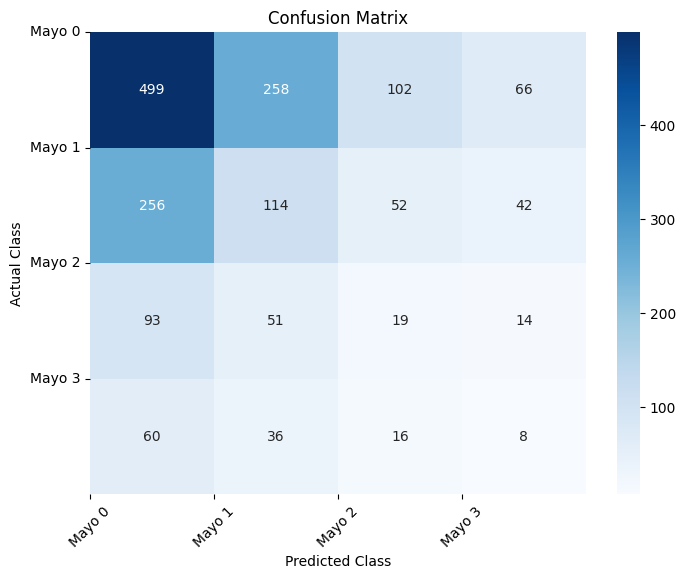

In [ ]:

import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

class_image_count = {}
class_image_count_test = {}
class_dirs = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
test_dir = "/content/gdrive/My Drive/test_set"

for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    class_image_count[class_dir] = len(image_files)
for class_dir in class_dirs:
    class_path = os.path.join(test_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    class_image_count_test[class_dir] = len(image_files)

total_count = sum(class_image_count.values())
total_count_test = sum(class_image_count_test.values())
class_probabilities = {class_dir: class_image_count[class_dir] / total_count for class_dir in class_dirs}


# Function to generate predictions using stratified random sampling
def stratified_random_predict(total_count_test, class_probabilities):
    classes, probabilities = zip(*class_probabilities.items())
    return list(np.random.choice(classes, size=total_count_test, p=probabilities))

# Generate stratified random predictions for the validation dataset
stratified_random_predictions = stratified_random_predict(total_count_test, class_probabilities)
# Extract true labels for evaluation
true_labels = [label for label, count in class_image_count_test.items() for _ in range(count)]

all_kappa_score_weighted_t = cohen_kappa_score(true_labels, stratified_random_predictions, weights="quadratic")
print(all_kappa_score_weighted_t)
# Evaluate the stratified random baseline
print("Stratified Random Baseline Performance:")
print(classification_report(true_labels, stratified_random_predictions, target_names=class_dirs))
print("Confusion Matrix:")
conf_matrix= confusion_matrix(true_labels, stratified_random_predictions)
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

# Generate the best ResNet18 baseline model to obtain the confusion matrix.

In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from datetime import datetime
import time
import argparse
import torchvision.models as models
import random
import numpy as np
from utils import UCMayo4, get_dataset_mean_and_std
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Setup directories and datasets
train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"

#channel_means, channel_stds = get_dataset_mean_and_std(train_dir)
channel_means=[0.416, 0.288, 0.219]
channel_stds=[0.299, 0.221, 0.178]

print("\nCreate weights directory for checkpoints!")
dirName = "weights"
try:
    os.makedirs(dirName)
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")
# Function to set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(35)
class_dirs = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
# Hyperparameters
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001
model_name = "ResNet18"
optimizer_name = "Adam"
num_classes = 4
num_worker = 4
num_epoch = 100
best_acc = 0
early_stopping_thresh = 15
LRScheduling_patience = 10
lrs_factor = 0.2
best_threshold = 0.0001
early_stop_counter = 0

# Setup directories and datasets
train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
#print("hwhw")
#channel_means, channel_stds = get_dataset_mean_and_std(train_dir)
normalize = transforms.Normalize(mean=channel_means, std=channel_stds)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-180, 180)),
    transforms.ToTensor(),
    normalize
])
train_dataset = UCMayo4(train_dir, transform=train_transform, val_split=0.1, subset='train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker, pin_memory=True)

val_transform = transforms.Compose([transforms.ToTensor(), normalize])
val_dataset = UCMayo4(val_dir, transform=val_transform, val_split=0.1, subset='val')
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker, pin_memory=True)

test_dir = "/content/gdrive/My Drive/test_set"
test_dataset = UCMayo4(test_dir, transform=val_transform,val_split=1, subset='val')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker,
                                        pin_memory=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)
# Setup the model
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model.to(device)

# Setup optimizer and learning rate scheduler
if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=lrs_factor, patience=LRScheduling_patience, threshold=best_threshold, verbose=True)

criterion = nn.CrossEntropyLoss()
class_names = ["Mayo 0", "Mayo 1", "Mayo 2", "Mayo 3"]

# Training loop
for epoch in range(num_epoch):
    #print("hehehe")
    model.train()
    training_loss, train_correct = 0.0, 0
    i=0
    for data, target in train_loader:
        #print("train {}".format(i))
        #i+=1
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        prediction = output.argmax(dim=1, keepdim=True)
        train_correct += prediction.eq(target.view_as(prediction)).sum().item()
        training_loss += loss.item()
    training_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss, val_correct = 0.0, 0
    y_true, y_pred = [], []
    #print("validation")
    with torch.no_grad():
        for data, target in val_loader:
            #print("validation")
            data, target = data.to(device), target.to(device)
            y_true.extend(target.cpu().tolist())
            output = model(data)
            loss = criterion(output, target)
            prediction = output.argmax(dim=1, keepdim=True)
            y_pred.extend(prediction.cpu().tolist())
            val_correct += prediction.eq(target.view_as(prediction)).sum().item()
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_loader.dataset)

    scheduler.step(val_accuracy)

    # Compute metrics and log to W&B
    cm_4class = confusion_matrix(y_true, y_pred)
    all_kappa_score_weighted = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    flattened_preds = [item for sublist in y_pred for item in sublist] if isinstance(y_pred[0], list) else y_pred
    print("epoch: {:3.0f}".format(epoch + 1) + " | Train acc: {:4.2f}".format(
        train_accuracy * 100) + " | Val acc: {:4.2f}".format(
        val_accuracy * 100) + " | Train loss: {:6.4f}".format(
        training_loss) + " | Val loss: {:6.4f}".format(
        val_loss) + " | QWK Score: {:4.3f}".format(
        all_kappa_score_weighted) + " | Confusion matrix: {}".format(cm_4class))


    if val_accuracy > best_acc * (1 + best_threshold):
        early_stop_counter = 0
        best_acc = val_accuracy
        print("overwriting the best model!")

        torch.save(model.state_dict(), "weights/best_" + model_name + '.pth.tar')
    else:
        early_stop_counter += 1
    if early_stop_counter >= early_stopping_thresh:
        model.eval()
        test_loss, test_correct = 0.0, 0
        y_true_test, y_pred_test = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                y_true_test.extend(target.cpu().tolist())
                output = model(data)
                loss = criterion(output, target)
                prediction = output.argmax(dim=1, keepdim=True)
                y_pred_test.extend(prediction.cpu().tolist())
                test_correct += prediction.eq(target.view_as(prediction)).sum().item()
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_accuracy = test_correct / len(test_loader.dataset)
        cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
        all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
        flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
        print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
            test_accuracy * 100) + " | Test loss: {:6.4f}".format(
            test_loss) + " | Test QWK Score: {:4.3f}".format(
            all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
        print("Early stopping at epoch {}".format(epoch + 1))
        break
model.eval()
test_loss, test_correct = 0.0, 0
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for data, target in test_loader:
        #print("validation")
        data, target = data.to(device), target.to(device)
        y_true_test.extend(target.cpu().tolist())
        output = model(data)
        loss = criterion(output, target)
        prediction = output.argmax(dim=1, keepdim=True)
        y_pred_test.extend(prediction.cpu().tolist())
        test_correct += prediction.eq(target.view_as(prediction)).sum().item()
        test_loss += loss.item()
test_loss /= len(test_loader)
test_accuracy = test_correct / len(test_loader.dataset)
cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
    test_accuracy * 100) + " | Test loss: {:6.4f}".format(
    test_loss) + " | Test QWK Score: {:4.3f}".format(
    all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
# Plot the confusion matrix using seaborn's heatmap for better readability
plt.figure(figsize=(8, 6))
sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()



Create weights directory for checkpoints!
Directory  weights  already exists
device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible wi

epoch:   1 | Train acc: 67.50 | Val acc: 67.57 | Train loss: 0.7503 | Val loss: 0.7384 | QWK Score: 0.735 | Confusion matrix: [[454  47   6   0]
 [120 119  24   0]
 [  6  32  72   0]
 [  5   3  68   3]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   2 | Train acc: 73.15 | Val acc: 70.91 | Train loss: 0.6170 | Val loss: 0.7221 | QWK Score: 0.826 | Confusion matrix: [[465  28  13   1]
 [100  92  60  11]
 [  2  10  47  51]
 [  0   0   3  76]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   3 | Train acc: 73.49 | Val acc: 63.82 | Train loss: 0.6118 | Val loss: 1.1247 | QWK Score: 0.728 | Confusion matrix: [[463  32   0  12]
 [123  71   2  67]
 [  9   5   0  96]
 [  1   0   0  78]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   4 | Train acc: 73.93 | Val acc: 68.93 | Train loss: 0.5968 | Val loss: 0.6730 | QWK Score: 0.801 | Confusion matrix: [[497  10   0   0]
 [173  73   3  14]
 [ 14  28  18  50]
 [  2   0   4  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   5 | Train acc: 74.09 | Val acc: 59.23 | Train loss: 0.5942 | Val loss: 1.2458 | QWK Score: 0.256 | Confusion matrix: [[485  22   0   0]
 [198  65   0   0]
 [ 80  27   2   1]
 [ 51   9   3  16]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   6 | Train acc: 74.63 | Val acc: 64.13 | Train loss: 0.5751 | Val loss: 0.7843 | QWK Score: 0.746 | Confusion matrix: [[311 191   5   0]
 [ 21 222  18   2]
 [  0  62  37  11]
 [  0   7  27  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   7 | Train acc: 74.95 | Val acc: 71.74 | Train loss: 0.5756 | Val loss: 0.6513 | QWK Score: 0.796 | Confusion matrix: [[388 119   0   0]
 [ 37 219   5   2]
 [  3  63  27  17]
 [  0  12  13  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   8 | Train acc: 75.51 | Val acc: 61.73 | Train loss: 0.5719 | Val loss: 1.1597 | QWK Score: 0.479 | Confusion matrix: [[506   1   0   0]
 [213  48   1   1]
 [ 60  39   4   7]
 [ 28  13   4  34]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:   9 | Train acc: 75.11 | Val acc: 66.11 | Train loss: 0.5713 | Val loss: 0.7447 | QWK Score: 0.673 | Confusion matrix: [[422  85   0   0]
 [ 91 169   1   2]
 [  4  94   7   5]
 [  2  36   5  36]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  10 | Train acc: 75.34 | Val acc: 70.91 | Train loss: 0.5663 | Val loss: 0.6910 | QWK Score: 0.759 | Confusion matrix: [[431  76   0   0]
 [ 60 195   7   1]
 [  1  79  21   9]
 [  0  23  23  33]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  11 | Train acc: 75.08 | Val acc: 68.20 | Train loss: 0.5793 | Val loss: 0.7344 | QWK Score: 0.740 | Confusion matrix: [[485  21   0   1]
 [148  91   7  17]
 [ 24  18  12  56]
 [ 10   1   2  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  12 | Train acc: 75.41 | Val acc: 70.80 | Train loss: 0.5574 | Val loss: 0.7211 | QWK Score: 0.755 | Confusion matrix: [[421  86   0   0]
 [ 50 199  14   0]
 [  1  64  44   1]
 [  3  13  48  15]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  13 | Train acc: 75.84 | Val acc: 67.99 | Train loss: 0.5484 | Val loss: 0.7482 | QWK Score: 0.796 | Confusion matrix: [[346 147  13   1]
 [ 31 173  54   5]
 [  0  12  68  30]
 [  1   0  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  14 | Train acc: 76.03 | Val acc: 69.03 | Train loss: 0.5533 | Val loss: 0.7293 | QWK Score: 0.785 | Confusion matrix: [[422  72  13   0]
 [ 59 139  65   0]
 [  0  10 100   0]
 [  0   0  78   1]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  15 | Train acc: 75.31 | Val acc: 69.03 | Train loss: 0.5513 | Val loss: 0.6979 | QWK Score: 0.793 | Confusion matrix: [[361 135   4   7]
 [ 24 182  43  14]
 [  0  13  45  52]
 [  1   0   4  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  16 | Train acc: 75.83 | Val acc: 73.51 | Train loss: 0.5454 | Val loss: 0.6353 | QWK Score: 0.781 | Confusion matrix: [[426  69   0  12]
 [ 57 178  17  11]
 [  1  49  35  25]
 [  1   3   9  66]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  17 | Train acc: 75.96 | Val acc: 71.64 | Train loss: 0.5481 | Val loss: 0.6151 | QWK Score: 0.794 | Confusion matrix: [[409  98   0   0]
 [ 41 210  12   0]
 [  0  65  40   5]
 [  0  10  41  28]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  18 | Train acc: 76.55 | Val acc: 67.88 | Train loss: 0.5399 | Val loss: 0.7134 | QWK Score: 0.755 | Confusion matrix: [[475  19   3  10]
 [118  85  24  36]
 [  6  15  17  72]
 [  3   2   0  74]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  19 | Train acc: 75.96 | Val acc: 73.31 | Train loss: 0.5484 | Val loss: 0.6300 | QWK Score: 0.818 | Confusion matrix: [[436  61   9   1]
 [ 58 138  66   1]
 [  2   9  82  17]
 [  2   3  27  47]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  20 | Train acc: 76.17 | Val acc: 70.28 | Train loss: 0.5332 | Val loss: 0.6802 | QWK Score: 0.775 | Confusion matrix: [[501   6   0   0]
 [173  74  12   4]
 [ 25  28  33  24]
 [  4   3   6  66]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  21 | Train acc: 75.99 | Val acc: 68.51 | Train loss: 0.5486 | Val loss: 0.7122 | QWK Score: 0.725 | Confusion matrix: [[488  19   0   0]
 [158 103   1   1]
 [ 19  63  10  18]
 [  8  11   4  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  22 | Train acc: 76.69 | Val acc: 73.51 | Train loss: 0.5335 | Val loss: 0.6269 | QWK Score: 0.806 | Confusion matrix: [[480  26   0   1]
 [107 138  15   3]
 [  8  48  36  18]
 [  3   4  21  51]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  23 | Train acc: 75.94 | Val acc: 74.45 | Train loss: 0.5471 | Val loss: 0.6248 | QWK Score: 0.846 | Confusion matrix: [[433  67   7   0]
 [ 55 143  64   1]
 [  2  10  85  13]
 [  0   0  26  53]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  24 | Train acc: 76.04 | Val acc: 68.40 | Train loss: 0.5433 | Val loss: 0.7686 | QWK Score: 0.800 | Confusion matrix: [[328 174   4   1]
 [ 22 201  39   1]
 [  0  19  82   9]
 [  0   0  34  45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  25 | Train acc: 76.70 | Val acc: 75.18 | Train loss: 0.5359 | Val loss: 0.5762 | QWK Score: 0.855 | Confusion matrix: [[421  82   4   0]
 [ 47 180  31   5]
 [  0  24  55  31]
 [  0   0  14  65]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  26 | Train acc: 77.00 | Val acc: 66.84 | Train loss: 0.5333 | Val loss: 0.7705 | QWK Score: 0.682 | Confusion matrix: [[498   9   0   0]
 [177  83   2   1]
 [ 23  65  12  10]
 [ 11  12   8  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  27 | Train acc: 77.05 | Val acc: 68.09 | Train loss: 0.5286 | Val loss: 0.7153 | QWK Score: 0.724 | Confusion matrix: [[495  12   0   0]
 [168  88   7   0]
 [ 18  59  20  13]
 [  9   8  12  50]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  28 | Train acc: 76.84 | Val acc: 74.87 | Train loss: 0.5333 | Val loss: 0.5972 | QWK Score: 0.839 | Confusion matrix: [[404  96   5   2]
 [ 40 180  40   3]
 [  0  18  78  14]
 [  0   0  23  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  29 | Train acc: 76.26 | Val acc: 69.76 | Train loss: 0.5358 | Val loss: 0.7021 | QWK Score: 0.813 | Confusion matrix: [[361 135  11   0]
 [ 24 180  58   1]
 [  0  17  75  18]
 [  0   0  26  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  30 | Train acc: 76.53 | Val acc: 75.70 | Train loss: 0.5278 | Val loss: 0.5916 | QWK Score: 0.843 | Confusion matrix: [[416  84   6   1]
 [ 52 175  32   4]
 [  0  20  81   9]
 [  0   0  25  54]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  31 | Train acc: 76.20 | Val acc: 75.70 | Train loss: 0.5372 | Val loss: 0.5358 | QWK Score: 0.839 | Confusion matrix: [[471  35   1   0]
 [ 97 147  16   3]
 [  4  40  55  11]
 [  0   5  21  53]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  32 | Train acc: 76.68 | Val acc: 67.88 | Train loss: 0.5317 | Val loss: 0.7168 | QWK Score: 0.782 | Confusion matrix: [[347 146  10   4]
 [ 34 172  53   4]
 [  0  18  78  14]
 [  0   0  25  54]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  33 | Train acc: 76.32 | Val acc: 74.77 | Train loss: 0.5297 | Val loss: 0.5650 | QWK Score: 0.834 | Confusion matrix: [[459  46   2   0]
 [ 71 172  19   1]
 [  1  44  59   6]
 [  0   2  50  27]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  34 | Train acc: 76.35 | Val acc: 68.82 | Train loss: 0.5282 | Val loss: 0.7804 | QWK Score: 0.796 | Confusion matrix: [[372 117  12   6]
 [ 27 156  76   4]
 [  0   6  69  35]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  35 | Train acc: 76.80 | Val acc: 74.24 | Train loss: 0.5274 | Val loss: 0.6232 | QWK Score: 0.839 | Confusion matrix: [[475  27   2   3]
 [102 121  24  16]
 [  2  17  40  51]
 [  0   0   3  76]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  36 | Train acc: 77.60 | Val acc: 60.79 | Train loss: 0.5224 | Val loss: 1.0062 | QWK Score: 0.725 | Confusion matrix: [[269 224  13   1]
 [ 24 202  37   0]
 [  0  23  81   6]
 [  0   0  48  31]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  37 | Train acc: 76.94 | Val acc: 72.89 | Train loss: 0.5262 | Val loss: 0.6161 | QWK Score: 0.826 | Confusion matrix: [[386 113   5   3]
 [ 41 183  34   5]
 [  0  19  67  24]
 [  0   0  16  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  38 | Train acc: 77.30 | Val acc: 73.83 | Train loss: 0.5169 | Val loss: 0.5773 | QWK Score: 0.833 | Confusion matrix: [[434  69   4   0]
 [ 69 167  26   1]
 [  0  38  63   9]
 [  0   3  32  44]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  39 | Train acc: 77.13 | Val acc: 70.70 | Train loss: 0.5255 | Val loss: 0.6507 | QWK Score: 0.757 | Confusion matrix: [[480  27   0   0]
 [135 120   7   1]
 [ 11  54  32  13]
 [  7   8  18  46]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  40 | Train acc: 76.57 | Val acc: 75.18 | Train loss: 0.5236 | Val loss: 0.6001 | QWK Score: 0.848 | Confusion matrix: [[410  93   3   1]
 [ 51 175  35   2]
 [  0  16  84  10]
 [  0   0  27  52]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  41 | Train acc: 77.18 | Val acc: 77.69 | Train loss: 0.5205 | Val loss: 0.5442 | QWK Score: 0.862 | Confusion matrix: [[471  35   1   0]
 [ 82 145  34   2]
 [  2  20  80   8]
 [  0   3  27  49]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  42 | Train acc: 77.63 | Val acc: 73.20 | Train loss: 0.5152 | Val loss: 0.6178 | QWK Score: 0.815 | Confusion matrix: [[374 126   5   2]
 [ 26 209  24   4]
 [  0  31  71   8]
 [  0   1  30  48]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  43 | Train acc: 77.27 | Val acc: 71.12 | Train loss: 0.5214 | Val loss: 0.6516 | QWK Score: 0.761 | Confusion matrix: [[493  14   0   0]
 [137 121   5   0]
 [  8  67  29   6]
 [  5  11  24  39]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  44 | Train acc: 76.87 | Val acc: 70.59 | Train loss: 0.5246 | Val loss: 0.6442 | QWK Score: 0.798 | Confusion matrix: [[374 132   0   1]
 [ 28 218  16   1]
 [  0  53  50   7]
 [  0   4  40  35]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  45 | Train acc: 76.69 | Val acc: 76.64 | Train loss: 0.5327 | Val loss: 0.5532 | QWK Score: 0.849 | Confusion matrix: [[465  41   1   0]
 [ 77 161  20   5]
 [  1  41  53  15]
 [  0   5  18  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  46 | Train acc: 77.00 | Val acc: 75.29 | Train loss: 0.5265 | Val loss: 0.5622 | QWK Score: 0.842 | Confusion matrix: [[483  23   0   1]
 [120 114  26   3]
 [  5  28  58  19]
 [  2   1   9  67]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  47 | Train acc: 77.67 | Val acc: 53.60 | Train loss: 0.5169 | Val loss: 1.5268 | QWK Score: 0.479 | Confusion matrix: [[367  29   4 107]
 [ 69  63   8 123]
 [  0   3   5 102]
 [  0   0   0  79]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  48 | Train acc: 77.19 | Val acc: 69.45 | Train loss: 0.5154 | Val loss: 0.7108 | QWK Score: 0.779 | Confusion matrix: [[378 128   1   0]
 [ 27 224  12   0]
 [  0  55  53   2]
 [  0   4  64  11]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  49 | Train acc: 77.93 | Val acc: 65.69 | Train loss: 0.5094 | Val loss: 0.8888 | QWK Score: 0.742 | Confusion matrix: [[415  66   8  18]
 [ 55 117  53  38]
 [  0   9  20  81]
 [  0   0   1  78]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  50 | Train acc: 77.45 | Val acc: 73.31 | Train loss: 0.5218 | Val loss: 0.6380 | QWK Score: 0.837 | Confusion matrix: [[405  94   6   2]
 [ 35 168  52   8]
 [  1   8  61  40]
 [  0   0  10  69]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  51 | Train acc: 77.30 | Val acc: 75.50 | Train loss: 0.5176 | Val loss: 0.5840 | QWK Score: 0.856 | Confusion matrix: [[463  38   5   1]
 [ 78 131  46   8]
 [  1  12  57  40]
 [  0   0   6  73]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  52 | Train acc: 77.11 | Val acc: 76.12 | Train loss: 0.5164 | Val loss: 0.5756 | QWK Score: 0.842 | Confusion matrix: [[461  45   1   0]
 [ 79 152  30   2]
 [  4  30  60  16]
 [  2   3  17  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  53 | Train acc: 78.57 | Val acc: 78.52 | Train loss: 0.4892 | Val loss: 0.5113 | QWK Score: 0.875 | Confusion matrix: [[477  29   1   0]
 [ 85 152  25   1]
 [  1  30  66  13]
 [  0   1  20  58]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  54 | Train acc: 79.20 | Val acc: 79.04 | Train loss: 0.4769 | Val loss: 0.5025 | QWK Score: 0.881 | Confusion matrix: [[452  54   1   0]
 [ 62 176  24   1]
 [  0  25  70  15]
 [  0   0  19  60]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  55 | Train acc: 79.83 | Val acc: 78.62 | Train loss: 0.4697 | Val loss: 0.5032 | QWK Score: 0.876 | Confusion matrix: [[473  33   1   0]
 [ 82 154  26   1]
 [  1  25  69  15]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  56 | Train acc: 79.17 | Val acc: 78.83 | Train loss: 0.4742 | Val loss: 0.5050 | QWK Score: 0.875 | Confusion matrix: [[467  39   1   0]
 [ 78 155  28   2]
 [  2  20  69  19]
 [  1   0  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  57 | Train acc: 79.37 | Val acc: 78.73 | Train loss: 0.4706 | Val loss: 0.5059 | QWK Score: 0.879 | Confusion matrix: [[465  40   2   0]
 [ 76 154  31   2]
 [  0  18  72  20]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  58 | Train acc: 79.79 | Val acc: 77.89 | Train loss: 0.4692 | Val loss: 0.5152 | QWK Score: 0.865 | Confusion matrix: [[475  31   1   0]
 [ 91 145  24   3]
 [  3  24  62  21]
 [  1   1  12  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  59 | Train acc: 79.61 | Val acc: 78.10 | Train loss: 0.4657 | Val loss: 0.5068 | QWK Score: 0.871 | Confusion matrix: [[456  50   1   0]
 [ 65 169  28   1]
 [  1  24  63  22]
 [  1   1  16  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  60 | Train acc: 79.50 | Val acc: 77.48 | Train loss: 0.4703 | Val loss: 0.5103 | QWK Score: 0.868 | Confusion matrix: [[464  43   0   0]
 [ 74 162  25   2]
 [  3  24  52  31]
 [  1   1  12  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  61 | Train acc: 79.64 | Val acc: 76.54 | Train loss: 0.4714 | Val loss: 0.5457 | QWK Score: 0.859 | Confusion matrix: [[484  22   1   0]
 [114 129  19   1]
 [  2  30  62  16]
 [  1   1  18  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  62 | Train acc: 79.60 | Val acc: 77.69 | Train loss: 0.4689 | Val loss: 0.5150 | QWK Score: 0.866 | Confusion matrix: [[474  31   2   0]
 [ 89 144  29   1]
 [  1  26  68  15]
 [  1   1  18  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  63 | Train acc: 79.86 | Val acc: 79.25 | Train loss: 0.4620 | Val loss: 0.4994 | QWK Score: 0.880 | Confusion matrix: [[459  46   2   0]
 [ 62 165  35   1]
 [  1  16  75  18]
 [  0   1  17  61]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  64 | Train acc: 80.29 | Val acc: 79.67 | Train loss: 0.4523 | Val loss: 0.4950 | QWK Score: 0.885 | Confusion matrix: [[456  50   1   0]
 [ 60 174  28   1]
 [  0  19  73  18]
 [  0   1  17  61]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  65 | Train acc: 80.21 | Val acc: 78.42 | Train loss: 0.4527 | Val loss: 0.5053 | QWK Score: 0.876 | Confusion matrix: [[453  53   1   0]
 [ 65 166  30   2]
 [  1  20  70  19]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  66 | Train acc: 79.86 | Val acc: 78.73 | Train loss: 0.4559 | Val loss: 0.5126 | QWK Score: 0.870 | Confusion matrix: [[446  58   1   2]
 [ 53 177  32   1]
 [  0  22  72  16]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  67 | Train acc: 79.69 | Val acc: 78.21 | Train loss: 0.4637 | Val loss: 0.5196 | QWK Score: 0.867 | Confusion matrix: [[466  40   1   0]
 [ 76 165  21   1]
 [  2  29  57  22]
 [  1   2  14  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  68 | Train acc: 80.06 | Val acc: 79.46 | Train loss: 0.4545 | Val loss: 0.4914 | QWK Score: 0.874 | Confusion matrix: [[456  48   2   1]
 [ 59 178  25   1]
 [  1  25  66  18]
 [  0   2  15  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  69 | Train acc: 80.28 | Val acc: 78.21 | Train loss: 0.4561 | Val loss: 0.5195 | QWK Score: 0.875 | Confusion matrix: [[428  77   2   0]
 [ 42 189  31   1]
 [  0  17  72  21]
 [  0   1  17  61]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  70 | Train acc: 79.37 | Val acc: 77.79 | Train loss: 0.4605 | Val loss: 0.5093 | QWK Score: 0.869 | Confusion matrix: [[463  41   2   1]
 [ 75 156  29   3]
 [  1  18  62  29]
 [  0   1  13  65]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  71 | Train acc: 80.54 | Val acc: 79.14 | Train loss: 0.4556 | Val loss: 0.5105 | QWK Score: 0.878 | Confusion matrix: [[463  43   1   0]
 [ 61 166  34   2]
 [  2  19  70  19]
 [  0   1  18  60]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  72 | Train acc: 79.84 | Val acc: 79.56 | Train loss: 0.4604 | Val loss: 0.5044 | QWK Score: 0.880 | Confusion matrix: [[454  52   1   0]
 [ 57 183  22   1]
 [  0  27  71  12]
 [  0   1  23  55]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  73 | Train acc: 80.10 | Val acc: 79.46 | Train loss: 0.4523 | Val loss: 0.5105 | QWK Score: 0.884 | Confusion matrix: [[470  36   1   0]
 [ 71 159  32   1]
 [  1  18  74  17]
 [  0   0  20  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  74 | Train acc: 79.94 | Val acc: 78.62 | Train loss: 0.4536 | Val loss: 0.5185 | QWK Score: 0.870 | Confusion matrix: [[469  37   1   0]
 [ 77 158  27   1]
 [  2  21  71  16]
 [  1   1  21  56]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  75 | Train acc: 79.79 | Val acc: 78.21 | Train loss: 0.4587 | Val loss: 0.5169 | QWK Score: 0.866 | Confusion matrix: [[438  65   2   2]
 [ 50 180  31   2]
 [  0  20  70  20]
 [  0   1  16  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  76 | Train acc: 80.54 | Val acc: 80.08 | Train loss: 0.4396 | Val loss: 0.4963 | QWK Score: 0.884 | Confusion matrix: [[468  38   1   0]
 [ 68 167  27   1]
 [  1  22  74  13]
 [  0   1  19  59]]
overwriting the best model!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  77 | Train acc: 80.82 | Val acc: 79.77 | Train loss: 0.4397 | Val loss: 0.4990 | QWK Score: 0.879 | Confusion matrix: [[459  46   1   1]
 [ 66 169  26   2]
 [  1  17  73  19]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  78 | Train acc: 80.60 | Val acc: 79.46 | Train loss: 0.4392 | Val loss: 0.5005 | QWK Score: 0.884 | Confusion matrix: [[467  39   1   0]
 [ 73 162  26   2]
 [  0  18  70  22]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  79 | Train acc: 80.70 | Val acc: 79.77 | Train loss: 0.4353 | Val loss: 0.4998 | QWK Score: 0.883 | Confusion matrix: [[460  45   1   1]
 [ 62 170  30   1]
 [  0  17  72  21]
 [  0   1  15  63]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  80 | Train acc: 81.39 | Val acc: 79.35 | Train loss: 0.4348 | Val loss: 0.5022 | QWK Score: 0.883 | Confusion matrix: [[466  40   1   0]
 [ 70 162  30   1]
 [  0  20  74  16]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  81 | Train acc: 81.28 | Val acc: 79.56 | Train loss: 0.4341 | Val loss: 0.4962 | QWK Score: 0.883 | Confusion matrix: [[463  43   1   0]
 [ 69 166  27   1]
 [  0  21  75  14]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  82 | Train acc: 81.15 | Val acc: 79.14 | Train loss: 0.4407 | Val loss: 0.4958 | QWK Score: 0.884 | Confusion matrix: [[461  45   1   0]
 [ 68 165  29   1]
 [  0  20  69  21]
 [  0   1  14  64]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  83 | Train acc: 81.14 | Val acc: 78.83 | Train loss: 0.4375 | Val loss: 0.5032 | QWK Score: 0.878 | Confusion matrix: [[472  34   1   0]
 [ 83 155  24   1]
 [  1  22  70  17]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  84 | Train acc: 80.85 | Val acc: 79.35 | Train loss: 0.4357 | Val loss: 0.4971 | QWK Score: 0.882 | Confusion matrix: [[462  44   1   0]
 [ 69 167  26   1]
 [  1  21  70  18]
 [  0   1  16  62]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  85 | Train acc: 81.27 | Val acc: 79.35 | Train loss: 0.4380 | Val loss: 0.5017 | QWK Score: 0.883 | Confusion matrix: [[465  41   1   0]
 [ 69 164  29   1]
 [  0  20  73  17]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  86 | Train acc: 80.94 | Val acc: 79.98 | Train loss: 0.4358 | Val loss: 0.4987 | QWK Score: 0.885 | Confusion matrix: [[466  40   1   0]
 [ 70 166  26   1]
 [  0  19  77  14]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  87 | Train acc: 81.46 | Val acc: 79.46 | Train loss: 0.4316 | Val loss: 0.5054 | QWK Score: 0.876 | Confusion matrix: [[467  38   1   1]
 [ 75 161  26   1]
 [  1  20  77  12]
 [  0   1  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  88 | Train acc: 81.08 | Val acc: 79.56 | Train loss: 0.4324 | Val loss: 0.5014 | QWK Score: 0.879 | Confusion matrix: [[468  38   1   0]
 [ 71 168  23   1]
 [  1  27  70  12]
 [  0   1  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  89 | Train acc: 81.55 | Val acc: 78.83 | Train loss: 0.4250 | Val loss: 0.4986 | QWK Score: 0.874 | Confusion matrix: [[460  45   1   1]
 [ 68 164  30   1]
 [  1  19  73  17]
 [  0   1  19  59]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  90 | Train acc: 81.54 | Val acc: 79.35 | Train loss: 0.4246 | Val loss: 0.4992 | QWK Score: 0.877 | Confusion matrix: [[458  47   1   1]
 [ 60 169  33   1]
 [  1  17  76  16]
 [  0   1  20  58]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  91 | Train acc: 81.69 | Val acc: 79.04 | Train loss: 0.4303 | Val loss: 0.4993 | QWK Score: 0.881 | Confusion matrix: [[461  45   1   0]
 [ 68 163  31   1]
 [  0  18  77  15]
 [  0   1  21  57]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  91 | Test acc: 78.29 | Test loss: 0.4941 | Test QWK Score: 0.859 | Test Confusion matrix: [[825  99   1   0]
 [121 307  32   4]
 [  1  36 104  36]
 [  2   2  32  84]]
Early stopping at epoch 91


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch:  91 | Test acc: 78.29 | Test loss: 0.4941 | Test QWK Score: 0.859 | Test Confusion matrix: [[825  99   1   0]
 [121 307  32   4]
 [  1  36 104  36]
 [  2   2  32  84]]


NameError: name 'plt' is not defined

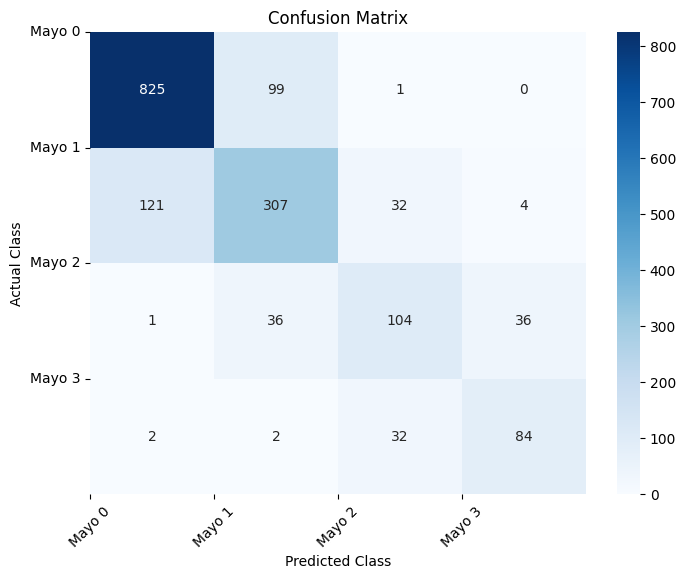

#Install necessary libraries

In [4]:
!pip install transformers torch torchvision timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Maxvit

In this section MaxVit is tested. First code section tries to find the best test set performance by testing the model whenever validation qwk score is at highest point. 88% of qwk score is found in the best model.

Second part searchs for hyperparameters and looking the effect of learning rate on MaxVit. The test set performance is not calculated the same way with the first code base. Because I did the hyperparameter tuning first (took around 12 hours), then to search for the best performance I did the first code section. So, hyperparameter tuning does not include the logic in the first code section.


Create weights directory for checkpoints!
Directory  weights  already exists
device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:   1 | Train acc: 73.24 | Val acc: 76.02 | Train loss: 0.6182 | Val loss: 0.5252 | QWK Score: 0.870 | Confusion matrix: [[488  18   1   0]
 [109 125  26   3]
 [  0  31  45  34]
 [  0   1   7  71]]
overwriting the best model!
epoch:   1 | Test acc: 76.81 | Test loss: 0.5183 | Test QWK Score: 0.859 | Test Confusion matrix: [[879  44   1   1]
 [196 239  22   7]
 [  3  32  68  74]
 [  1   2   8 109]]


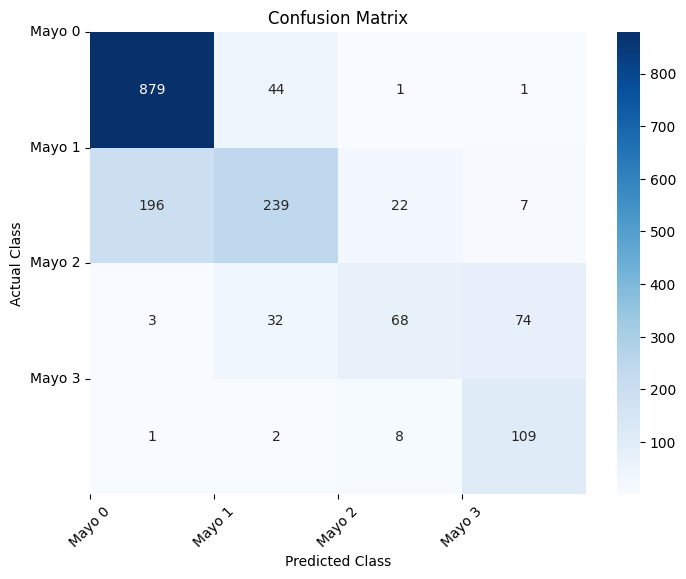

100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


epoch:   2 | Train acc: 79.72 | Val acc: 78.62 | Train loss: 0.4662 | Val loss: 0.4767 | QWK Score: 0.870 | Confusion matrix: [[467  40   0   0]
 [ 69 176  18   0]
 [  0  41  61   8]
 [  0   3  26  50]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


epoch:   3 | Train acc: 81.45 | Val acc: 80.19 | Train loss: 0.4281 | Val loss: 0.4580 | QWK Score: 0.889 | Confusion matrix: [[453  54   0   0]
 [ 56 179  27   1]
 [  0  22  75  13]
 [  0   0  17  62]]
overwriting the best model!
epoch:   3 | Test acc: 80.43 | Test loss: 0.4610 | Test QWK Score: 0.879 | Test Confusion matrix: [[818 106   1   0]
 [ 98 332  30   4]
 [  1  26 112  38]
 [  0   2  24  94]]


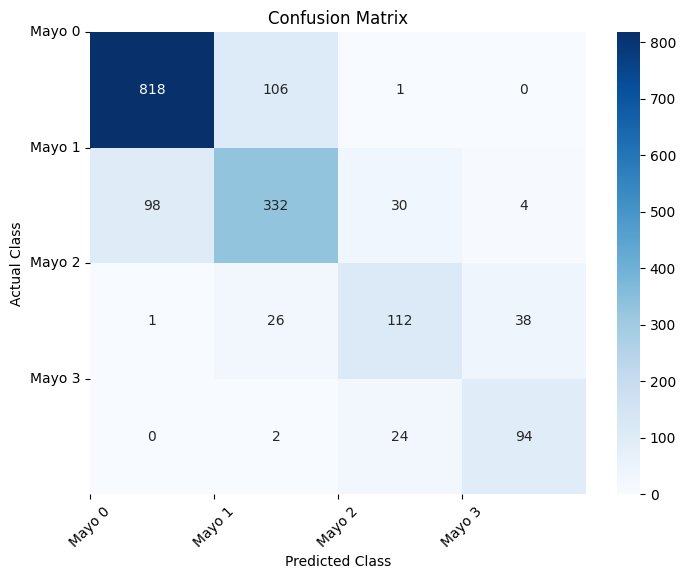

100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:   4 | Train acc: 84.02 | Val acc: 78.94 | Train loss: 0.3696 | Val loss: 0.4956 | QWK Score: 0.884 | Confusion matrix: [[467  40   0   0]
 [ 75 171  17   0]
 [  0  37  55  18]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:   5 | Train acc: 86.64 | Val acc: 78.42 | Train loss: 0.3145 | Val loss: 0.5479 | QWK Score: 0.878 | Confusion matrix: [[480  25   2   0]
 [ 91 134  37   1]
 [  0  19  81  10]
 [  0   0  22  57]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:   6 | Train acc: 89.42 | Val acc: 78.10 | Train loss: 0.2613 | Val loss: 0.5313 | QWK Score: 0.873 | Confusion matrix: [[438  67   2   0]
 [ 55 186  21   1]
 [  0  32  63  15]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:   7 | Train acc: 91.90 | Val acc: 80.60 | Train loss: 0.2026 | Val loss: 0.5753 | QWK Score: 0.892 | Confusion matrix: [[472  34   1   0]
 [ 73 162  26   2]
 [  0  20  73  17]
 [  0   0  13  66]]
overwriting the best model!
epoch:   7 | Test acc: 78.29 | Test loss: 0.6007 | Test QWK Score: 0.863 | Test Confusion matrix: [[843  81   1   0]
 [127 283  52   2]
 [  2  28 107  40]
 [  2   2  29  87]]


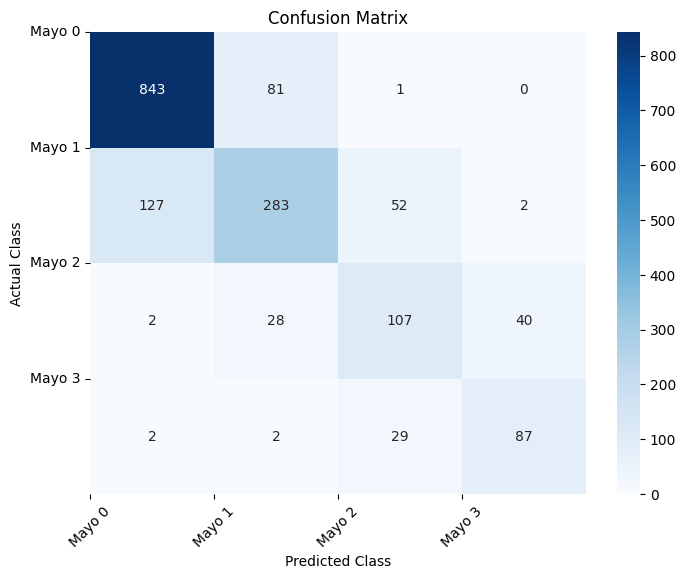

100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:   8 | Train acc: 93.31 | Val acc: 79.46 | Train loss: 0.1739 | Val loss: 0.6650 | QWK Score: 0.886 | Confusion matrix: [[455  50   2   0]
 [ 63 168  30   2]
 [  0  17  70  23]
 [  0   0  10  69]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:   9 | Train acc: 94.98 | Val acc: 78.73 | Train loss: 0.1281 | Val loss: 0.6727 | QWK Score: 0.879 | Confusion matrix: [[441  64   1   1]
 [ 50 186  26   1]
 [  1  22  57  30]
 [  0   0   8  71]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  10 | Train acc: 96.42 | Val acc: 80.08 | Train loss: 0.0955 | Val loss: 0.7110 | QWK Score: 0.874 | Confusion matrix: [[464  43   0   0]
 [ 70 181  10   2]
 [  1  31  73   5]
 [  1   0  28  50]]


100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


epoch:  11 | Train acc: 96.84 | Val acc: 77.89 | Train loss: 0.0884 | Val loss: 0.7683 | QWK Score: 0.861 | Confusion matrix: [[436  68   2   1]
 [ 55 192  16   0]
 [  0  35  67   8]
 [  0   1  26  52]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  12 | Train acc: 97.54 | Val acc: 79.87 | Train loss: 0.0699 | Val loss: 0.8443 | QWK Score: 0.878 | Confusion matrix: [[457  47   2   1]
 [ 66 172  23   2]
 [  2  23  69  16]
 [  0   0  11  68]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  13 | Train acc: 97.64 | Val acc: 80.29 | Train loss: 0.0671 | Val loss: 0.9104 | QWK Score: 0.880 | Confusion matrix: [[483  23   0   1]
 [ 90 150  21   2]
 [  2  24  68  16]
 [  1   0   9  69]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  14 | Train acc: 98.00 | Val acc: 78.94 | Train loss: 0.0570 | Val loss: 0.8534 | QWK Score: 0.877 | Confusion matrix: [[470  36   1   0]
 [ 78 161  24   0]
 [  1  25  67  17]
 [  1   0  19  59]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  15 | Train acc: 98.29 | Val acc: 78.10 | Train loss: 0.0500 | Val loss: 0.9341 | QWK Score: 0.870 | Confusion matrix: [[423  82   2   0]
 [ 48 187  25   3]
 [  0  20  70  20]
 [  1   0   9  69]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  16 | Train acc: 98.11 | Val acc: 78.62 | Train loss: 0.0534 | Val loss: 0.8559 | QWK Score: 0.872 | Confusion matrix: [[449  58   0   0]
 [ 68 173  21   1]
 [  2  24  67  17]
 [  1   1  12  65]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  17 | Train acc: 98.33 | Val acc: 78.52 | Train loss: 0.0464 | Val loss: 0.8617 | QWK Score: 0.863 | Confusion matrix: [[432  72   2   1]
 [ 54 192  16   1]
 [  0  32  70   8]
 [  1   0  19  59]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  18 | Train acc: 98.47 | Val acc: 78.83 | Train loss: 0.0439 | Val loss: 0.9103 | QWK Score: 0.874 | Confusion matrix: [[431  73   2   1]
 [ 49 186  27   1]
 [  0  23  74  13]
 [  0   0  14  65]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  19 | Train acc: 99.42 | Val acc: 81.54 | Train loss: 0.0173 | Val loss: 0.8947 | QWK Score: 0.894 | Confusion matrix: [[462  44   1   0]
 [ 60 177  25   1]
 [  1  22  76  11]
 [  0   0  12  67]]
overwriting the best model!
epoch:  19 | Test acc: 77.34 | Test loss: 1.0253 | Test QWK Score: 0.853 | Test Confusion matrix: [[832  91   2   0]
 [133 288  40   3]
 [  1  36 103  37]
 [  1   5  33  81]]


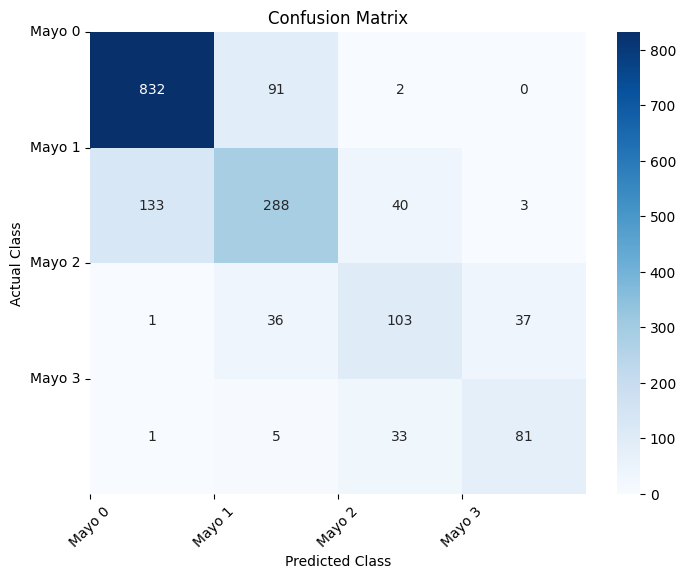

100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  20 | Train acc: 99.78 | Val acc: 81.33 | Train loss: 0.0092 | Val loss: 0.9300 | QWK Score: 0.889 | Confusion matrix: [[457  48   1   1]
 [ 58 181  24   0]
 [  1  24  76   9]
 [  0   0  13  66]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  21 | Train acc: 99.81 | Val acc: 81.23 | Train loss: 0.0065 | Val loss: 0.9908 | QWK Score: 0.889 | Confusion matrix: [[458  47   1   1]
 [ 61 177  24   1]
 [  1  23  75  11]
 [  0   0  10  69]]


100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


epoch:  22 | Train acc: 99.76 | Val acc: 81.23 | Train loss: 0.0071 | Val loss: 1.0195 | QWK Score: 0.890 | Confusion matrix: [[452  53   1   1]
 [ 55 185  23   0]
 [  0  25  75  10]
 [  0   0  12  67]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  23 | Train acc: 99.78 | Val acc: 80.71 | Train loss: 0.0052 | Val loss: 1.0982 | QWK Score: 0.887 | Confusion matrix: [[463  42   1   1]
 [ 65 169  27   2]
 [  0  21  75  14]
 [  0   0  12  67]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  24 | Train acc: 99.76 | Val acc: 81.02 | Train loss: 0.0064 | Val loss: 1.0968 | QWK Score: 0.889 | Confusion matrix: [[457  50   0   0]
 [ 61 185  17   0]
 [  0  31  71   8]
 [  1   0  14  64]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  25 | Train acc: 99.70 | Val acc: 80.60 | Train loss: 0.0070 | Val loss: 1.1038 | QWK Score: 0.884 | Confusion matrix: [[451  55   0   1]
 [ 55 178  30   0]
 [  0  19  82   9]
 [  1   0  16  62]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  26 | Train acc: 99.64 | Val acc: 80.60 | Train loss: 0.0086 | Val loss: 1.1563 | QWK Score: 0.885 | Confusion matrix: [[460  46   1   0]
 [ 65 175  22   1]
 [  0  26  74  10]
 [  1   0  14  64]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  27 | Train acc: 99.79 | Val acc: 79.87 | Train loss: 0.0053 | Val loss: 1.1374 | QWK Score: 0.880 | Confusion matrix: [[458  49   0   0]
 [ 64 174  24   1]
 [  1  28  71  10]
 [  1   0  15  63]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  28 | Train acc: 99.73 | Val acc: 79.25 | Train loss: 0.0089 | Val loss: 1.1293 | QWK Score: 0.877 | Confusion matrix: [[462  43   1   1]
 [ 71 164  27   1]
 [  0  25  76   9]
 [  0   0  21  58]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  29 | Train acc: 99.72 | Val acc: 80.40 | Train loss: 0.0054 | Val loss: 1.1762 | QWK Score: 0.882 | Confusion matrix: [[475  32   0   0]
 [ 79 164  17   3]
 [  1  30  66  13]
 [  1   0  12  66]]


100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


epoch:  30 | Train acc: 99.83 | Val acc: 81.23 | Train loss: 0.0045 | Val loss: 1.1212 | QWK Score: 0.892 | Confusion matrix: [[458  49   0   0]
 [ 59 178  24   2]
 [  1  24  76   9]
 [  0   0  12  67]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  31 | Train acc: 99.87 | Val acc: 81.02 | Train loss: 0.0025 | Val loss: 1.1281 | QWK Score: 0.891 | Confusion matrix: [[459  48   0   0]
 [ 60 178  23   2]
 [  1  27  73   9]
 [  0   0  12  67]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  32 | Train acc: 99.85 | Val acc: 80.92 | Train loss: 0.0027 | Val loss: 1.1361 | QWK Score: 0.889 | Confusion matrix: [[461  45   1   0]
 [ 62 176  23   2]
 [  1  24  74  11]
 [  0   0  14  65]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  33 | Train acc: 99.85 | Val acc: 81.44 | Train loss: 0.0029 | Val loss: 1.1493 | QWK Score: 0.894 | Confusion matrix: [[460  46   1   0]
 [ 57 177  27   2]
 [  0  20  80  10]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]

epoch:  34 | Train acc: 99.81 | Val acc: 80.81 | Train loss: 0.0032 | Val loss: 1.1583 | QWK Score: 0.886 | Confusion matrix: [[460  45   1   1]
 [ 60 177  24   2]
 [  0  26  71  13]
 [  0   0  12  67]]


epoch:  34 | Test acc: 78.83 | Test loss: 1.3136 | Test QWK Score: 0.865 | Test Confusion matrix: [[831  93   1   0]
 [114 303  43   4]
 [  1  32 112  32]
 [  1   2  34  83]]
Early stopping at epoch 34
epoch:  34 | Test acc: 78.83 | Test loss: 1.3136 | Test QWK Score: 0.865 | Test Confusion matrix: [[831  93   1   0]
 [114 303  43   4]
 [  1  32 112  32]
 [  1   2  34  83]]


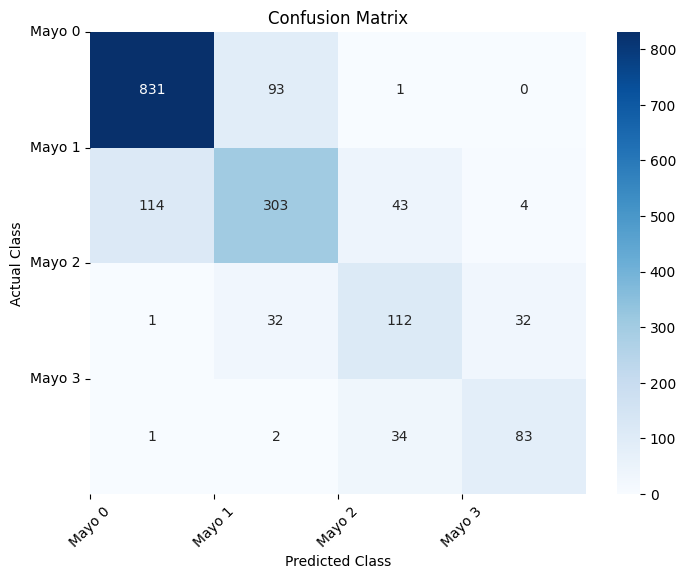

In [6]:
import os
import torch
import torch.nn as nn
from torch.optim import lr_scheduler, AdamW
import torchvision.transforms as transforms
from datetime import datetime
import time
import random
import numpy as np
from utils import UCMayo4, get_dataset_mean_and_std
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from tqdm import tqdm

# Setup directories and datasets
train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"

channel_means = [0.416, 0.288, 0.219]
channel_stds = [0.299, 0.221, 0.178]

print("\nCreate weights directory for checkpoints!")
dirName = "weights"
try:
    os.makedirs(dirName)
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")

# Function to set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(35)
class_dirs = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']

# Hyperparameters
batch_size = 16
learning_rate = 0.0001
weight_decay = 0.001
model_name = "maxvit_base_tf_224"#swin_base_patch4_window7_224"  # Change to "vit_base_patch16_224" if using ViT
optimizer_name = "AdamW"
num_classes = 4
num_worker = 4
num_epoch = 50
best_acc = 0
early_stopping_thresh = 15
LRScheduling_patience = 10
lrs_factor = 0.2
best_threshold = 0.0001
early_stop_counter = 0
best_qwk = 0
# Setup directories and datasets
train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
normalize = transforms.Normalize(mean=channel_means, std=channel_stds)
# Define the transform for the training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-180, 180)),
    transforms.ToTensor(),
    normalize
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])
train_dataset = UCMayo4(train_dir, transform=train_transform, val_split=0.1, subset='train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker, pin_memory=True)

val_dataset = UCMayo4(val_dir, transform=val_transform, val_split=0.1, subset='val')
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker, pin_memory=True)

test_dir = "/content/gdrive/My Drive/test_set"
test_dataset = UCMayo4(test_dir, transform=val_transform,val_split=1, subset='val')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker,
                                        pin_memory=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# Load pre-trained Swin or ViT model from timm
if model_name == "swin_base_patch4_window7_224":
    model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
elif model_name == "vit_base_patch16_224":
    model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
elif model_name == "maxvit_base_tf_224":
    model = timm.create_model('maxvit_base_tf_224.in21k', pretrained=True, num_classes=num_classes)

model.to(device)

# Setup optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=lrs_factor, patience=LRScheduling_patience, threshold=best_threshold, verbose=True)

criterion = nn.CrossEntropyLoss()
class_names = ["Mayo 0", "Mayo 1", "Mayo 2", "Mayo 3"]

# Training loop
for epoch in range(num_epoch):
    #print("hehehe")
    model.train()
    training_loss, train_correct = 0.0, 0
    i=0
    for data, target in tqdm(train_loader):
        #print("train {}".format(i))
        #i+=1
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        prediction = output.argmax(dim=1, keepdim=True)
        train_correct += prediction.eq(target.view_as(prediction)).sum().item()
        training_loss += loss.item()
    training_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss, val_correct = 0.0, 0
    y_true, y_pred = [], []
    #print("validation")
    with torch.no_grad():
        for data, target in tqdm(val_loader):
            #print("validation")
            data, target = data.to(device), target.to(device)
            y_true.extend(target.cpu().tolist())
            output = model(data)
            loss = criterion(output, target)
            prediction = output.argmax(dim=1, keepdim=True)
            y_pred.extend(prediction.cpu().tolist())
            val_correct += prediction.eq(target.view_as(prediction)).sum().item()
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_loader.dataset)

    scheduler.step(val_accuracy)

    # Compute metrics and log to W&B
    cm_4class = confusion_matrix(y_true, y_pred)
    all_kappa_score_weighted = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    flattened_preds = [item for sublist in y_pred for item in sublist] if isinstance(y_pred[0], list) else y_pred
    print("epoch: {:3.0f}".format(epoch + 1) + " | Train acc: {:4.2f}".format(
        train_accuracy * 100) + " | Val acc: {:4.2f}".format(
        val_accuracy * 100) + " | Train loss: {:6.4f}".format(
        training_loss) + " | Val loss: {:6.4f}".format(
        val_loss) + " | QWK Score: {:4.3f}".format(
        all_kappa_score_weighted) + " | Confusion matrix: {}".format(cm_4class))


    if val_accuracy > best_acc * (1 + best_threshold):
        early_stop_counter = 0
        best_acc = val_accuracy
        print("overwriting the best model!")

        torch.save(model.state_dict(), "weights/best_" + model_name + '.pth.tar')
    else:
        early_stop_counter += 1

    if all_kappa_score_weighted > (1+best_threshold) * best_qwk:
      best_qwk = all_kappa_score_weighted
      model.eval()
      test_loss, test_correct = 0.0, 0
      y_true_test, y_pred_test = [], []
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              y_true_test.extend(target.cpu().tolist())
              output = model(data)
              loss = criterion(output, target)
              prediction = output.argmax(dim=1, keepdim=True)
              y_pred_test.extend(prediction.cpu().tolist())
              test_correct += prediction.eq(target.view_as(prediction)).sum().item()
              test_loss += loss.item()
      test_loss /= len(test_loader)
      test_accuracy = test_correct / len(test_loader.dataset)
      cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
      all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
      flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
      print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
          test_accuracy * 100) + " | Test loss: {:6.4f}".format(
          test_loss) + " | Test QWK Score: {:4.3f}".format(
          all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
      plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
      plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
      plt.xlabel("Predicted Class")
      plt.ylabel("Actual Class")
      plt.title("Confusion Matrix")
      plt.show()
    if early_stop_counter >= early_stopping_thresh:
      model.eval()
      test_loss, test_correct = 0.0, 0
      y_true_test, y_pred_test = [], []
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              y_true_test.extend(target.cpu().tolist())
              output = model(data)
              loss = criterion(output, target)
              prediction = output.argmax(dim=1, keepdim=True)
              y_pred_test.extend(prediction.cpu().tolist())
              test_correct += prediction.eq(target.view_as(prediction)).sum().item()
              test_loss += loss.item()
      test_loss /= len(test_loader)
      test_accuracy = test_correct / len(test_loader.dataset)
      cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
      all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
      flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
      print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
          test_accuracy * 100) + " | Test loss: {:6.4f}".format(
          test_loss) + " | Test QWK Score: {:4.3f}".format(
          all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
      print("Early stopping at epoch {}".format(epoch + 1))
      break
model.eval()
test_loss, test_correct = 0.0, 0
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for data, target in test_loader:
        #print("validation")
        data, target = data.to(device), target.to(device)
        y_true_test.extend(target.cpu().tolist())
        output = model(data)
        loss = criterion(output, target)
        prediction = output.argmax(dim=1, keepdim=True)
        y_pred_test.extend(prediction.cpu().tolist())
        test_correct += prediction.eq(target.view_as(prediction)).sum().item()
        test_loss += loss.item()
test_loss /= len(test_loader)
test_accuracy = test_correct / len(test_loader.dataset)
cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
    test_accuracy * 100) + " | Test loss: {:6.4f}".format(
    test_loss) + " | Test QWK Score: {:4.3f}".format(
    all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
# Plot the confusion matrix using seaborn's heatmap for better readability
plt.figure(figsize=(8, 6))
sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()



Create weights directory for checkpoints!
Directory  weights  Created 
Create sweep with ID: za9pexqm
Sweep URL: https://wandb.ai/di725/DI725-Project-EmreCakmakyurdu-UCS-Transformer2/sweeps/za9pexqm


wandb: Agent Starting Run: ft6ytl6o with config:
wandb: 	batch_size: 16
wandb: 	lr: 0.0001
wandb: 	model_name: maxvit_base_tf_224
wandb: 	optimizer: AdamW
wandb: 	use_lrscheduling: True
wandb: Currently logged in as: ecyurdu (di725). Use `wandb login --relogin` to force relogin


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 60/60 [02:02<00:00,  2.03s/it]


epoch:   1 | Train acc: 73.24 | Val acc: 76.02 | Train loss: 0.6182 | Val loss: 0.5252 | QWK Score: 0.870 | Confusion matrix: [[488  18   1   0]
 [109 125  26   3]
 [  0  31  45  34]
 [  0   1   7  71]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.25it/s]


epoch:   2 | Train acc: 80.08 | Val acc: 78.73 | Train loss: 0.4645 | Val loss: 0.4780 | QWK Score: 0.883 | Confusion matrix: [[466  41   0   0]
 [ 78 155  29   1]
 [  0  26  67  17]
 [  0   1  11  67]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   3 | Train acc: 81.57 | Val acc: 79.14 | Train loss: 0.4238 | Val loss: 0.5212 | QWK Score: 0.882 | Confusion matrix: [[482  24   1   0]
 [ 91 155  16   1]
 [  0  37  60  13]
 [  0   0  17  62]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


epoch:   4 | Train acc: 84.83 | Val acc: 78.42 | Train loss: 0.3672 | Val loss: 0.5071 | QWK Score: 0.880 | Confusion matrix: [[451  56   0   0]
 [ 60 179  23   1]
 [  0  32  60  18]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:   5 | Train acc: 86.49 | Val acc: 78.31 | Train loss: 0.3232 | Val loss: 0.5299 | QWK Score: 0.881 | Confusion matrix: [[450  57   0   0]
 [ 61 178  23   1]
 [  0  29  58  23]
 [  0   0  14  65]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   6 | Train acc: 88.48 | Val acc: 79.67 | Train loss: 0.2728 | Val loss: 0.5811 | QWK Score: 0.886 | Confusion matrix: [[478  28   1   0]
 [ 75 165  21   2]
 [  3  25  49  33]
 [  0   0   7  72]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:   7 | Train acc: 91.38 | Val acc: 78.73 | Train loss: 0.2134 | Val loss: 0.5923 | QWK Score: 0.876 | Confusion matrix: [[446  58   2   1]
 [ 64 175  23   1]
 [  0  22  68  20]
 [  0   0  13  66]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:   8 | Train acc: 93.55 | Val acc: 79.87 | Train loss: 0.1670 | Val loss: 0.6239 | QWK Score: 0.883 | Confusion matrix: [[467  38   2   0]
 [ 76 162  24   1]
 [  1  22  76  11]
 [  0   0  18  61]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:   9 | Train acc: 94.57 | Val acc: 80.19 | Train loss: 0.1403 | Val loss: 0.6532 | QWK Score: 0.883 | Confusion matrix: [[466  38   2   1]
 [ 69 162  30   2]
 [  0  18  77  15]
 [  0   0  15  64]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  10 | Train acc: 96.19 | Val acc: 78.00 | Train loss: 0.1048 | Val loss: 0.7328 | QWK Score: 0.877 | Confusion matrix: [[433  72   2   0]
 [ 51 178  33   1]
 [  0  20  70  20]
 [  0   0  12  67]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  11 | Train acc: 97.08 | Val acc: 78.83 | Train loss: 0.0834 | Val loss: 0.7854 | QWK Score: 0.871 | Confusion matrix: [[429  77   1   0]
 [ 48 201  14   0]
 [  0  36  65   9]
 [  0   3  15  61]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  12 | Train acc: 97.21 | Val acc: 75.91 | Train loss: 0.0774 | Val loss: 0.8590 | QWK Score: 0.851 | Confusion matrix: [[427  77   2   1]
 [ 66 164  31   2]
 [  0  24  78   8]
 [  0   2  18  59]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  13 | Train acc: 97.69 | Val acc: 79.56 | Train loss: 0.0678 | Val loss: 0.8876 | QWK Score: 0.876 | Confusion matrix: [[478  27   2   0]
 [ 91 156  15   1]
 [  2  25  67  16]
 [  1   0  16  62]]


100%|██████████| 60/60 [00:11<00:00,  5.23it/s]


epoch:  14 | Train acc: 98.20 | Val acc: 76.85 | Train loss: 0.0529 | Val loss: 0.9138 | QWK Score: 0.863 | Confusion matrix: [[463  43   1   0]
 [ 92 148  23   0]
 [  4  29  63  14]
 [  0   1  15  63]]


100%|██████████| 60/60 [00:11<00:00,  5.29it/s]


epoch:  15 | Train acc: 98.40 | Val acc: 77.69 | Train loss: 0.0524 | Val loss: 0.8834 | QWK Score: 0.861 | Confusion matrix: [[435  70   1   1]
 [ 59 183  19   2]
 [  0  36  64  10]
 [  0   2  14  63]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  16 | Train acc: 98.17 | Val acc: 77.89 | Train loss: 0.0523 | Val loss: 1.0048 | QWK Score: 0.866 | Confusion matrix: [[428  74   4   1]
 [ 53 173  35   2]
 [  0  13  84  13]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  17 | Train acc: 98.48 | Val acc: 79.77 | Train loss: 0.0444 | Val loss: 0.8739 | QWK Score: 0.878 | Confusion matrix: [[444  59   3   1]
 [ 56 181  24   2]
 [  0  20  75  15]
 [  0   0  14  65]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  18 | Train acc: 98.41 | Val acc: 77.79 | Train loss: 0.0432 | Val loss: 0.9850 | QWK Score: 0.857 | Confusion matrix: [[446  58   2   1]
 [ 75 165  22   1]
 [  3  23  74  10]
 [  0   3  15  61]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  19 | Train acc: 98.59 | Val acc: 79.14 | Train loss: 0.0398 | Val loss: 1.0227 | QWK Score: 0.870 | Confusion matrix: [[435  68   3   1]
 [ 48 185  28   2]
 [  0  21  78  11]
 [  0   1  17  61]]


100%|██████████| 60/60 [00:11<00:00,  5.30it/s]


epoch:  20 | Train acc: 98.40 | Val acc: 78.42 | Train loss: 0.0450 | Val loss: 0.8555 | QWK Score: 0.866 | Confusion matrix: [[448  56   2   1]
 [ 68 171  22   2]
 [  3  21  71  15]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  21 | Train acc: 99.46 | Val acc: 79.46 | Train loss: 0.0173 | Val loss: 0.8974 | QWK Score: 0.875 | Confusion matrix: [[458  46   2   1]
 [ 72 170  20   1]
 [  1  25  74  10]
 [  0   0  19  60]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  22 | Train acc: 99.65 | Val acc: 79.46 | Train loss: 0.0088 | Val loss: 0.9775 | QWK Score: 0.876 | Confusion matrix: [[458  45   3   1]
 [ 70 167  25   1]
 [  0  23  76  11]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.30it/s]


epoch:  23 | Train acc: 99.79 | Val acc: 80.60 | Train loss: 0.0063 | Val loss: 1.0235 | QWK Score: 0.885 | Confusion matrix: [[464  40   3   0]
 [ 64 173  25   1]
 [  0  23  78   9]
 [  0   0  21  58]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  24 | Train acc: 99.88 | Val acc: 80.50 | Train loss: 0.0038 | Val loss: 1.0966 | QWK Score: 0.882 | Confusion matrix: [[463  41   3   0]
 [ 68 172  21   2]
 [  0  23  76  11]
 [  0   1  17  61]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  25 | Train acc: 99.76 | Val acc: 79.56 | Train loss: 0.0061 | Val loss: 1.1519 | QWK Score: 0.877 | Confusion matrix: [[450  55   1   1]
 [ 61 175  25   2]
 [  0  22  78  10]
 [  0   0  19  60]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  26 | Train acc: 99.77 | Val acc: 79.14 | Train loss: 0.0055 | Val loss: 1.1529 | QWK Score: 0.876 | Confusion matrix: [[441  63   3   0]
 [ 58 184  20   1]
 [  0  25  72  13]
 [  0   1  16  62]]


100%|██████████| 60/60 [00:11<00:00,  5.29it/s]


epoch:  27 | Train acc: 99.73 | Val acc: 79.56 | Train loss: 0.0080 | Val loss: 1.1229 | QWK Score: 0.877 | Confusion matrix: [[453  51   2   1]
 [ 62 180  20   1]
 [  0  28  70  12]
 [  0   0  19  60]]


100%|██████████| 60/60 [00:11<00:00,  5.23it/s]


epoch:  28 | Train acc: 99.80 | Val acc: 80.29 | Train loss: 0.0050 | Val loss: 1.2077 | QWK Score: 0.883 | Confusion matrix: [[458  46   2   1]
 [ 67 172  23   1]
 [  0  21  76  13]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  29 | Train acc: 99.77 | Val acc: 79.56 | Train loss: 0.0063 | Val loss: 1.1801 | QWK Score: 0.877 | Confusion matrix: [[436  68   2   1]
 [ 53 189  20   1]
 [  0  22  76  12]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  30 | Train acc: 99.78 | Val acc: 80.60 | Train loss: 0.0054 | Val loss: 1.1745 | QWK Score: 0.888 | Confusion matrix: [[465  40   2   0]
 [ 73 167  22   1]
 [  0  21  79  10]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  31 | Train acc: 99.81 | Val acc: 79.67 | Train loss: 0.0046 | Val loss: 1.1927 | QWK Score: 0.874 | Confusion matrix: [[441  64   1   1]
 [ 53 190  18   2]
 [  0  26  71  13]
 [  0   2  15  62]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  32 | Train acc: 99.84 | Val acc: 80.29 | Train loss: 0.0044 | Val loss: 1.2286 | QWK Score: 0.887 | Confusion matrix: [[456  50   1   0]
 [ 63 179  20   1]
 [  0  26  73  11]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  33 | Train acc: 99.85 | Val acc: 81.44 | Train loss: 0.0051 | Val loss: 1.2178 | QWK Score: 0.888 | Confusion matrix: [[460  44   2   1]
 [ 59 184  19   1]
 [  0  24  75  11]
 [  0   0  17  62]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  34 | Train acc: 99.83 | Val acc: 80.19 | Train loss: 0.0036 | Val loss: 1.2643 | QWK Score: 0.881 | Confusion matrix: [[448  57   2   0]
 [ 55 190  17   1]
 [  0  27  70  13]
 [  0   2  16  61]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  35 | Train acc: 99.83 | Val acc: 80.19 | Train loss: 0.0029 | Val loss: 1.2702 | QWK Score: 0.877 | Confusion matrix: [[449  54   3   1]
 [ 56 187  18   2]
 [  0  25  72  13]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  36 | Train acc: 99.78 | Val acc: 79.77 | Train loss: 0.0047 | Val loss: 1.3033 | QWK Score: 0.882 | Confusion matrix: [[464  40   3   0]
 [ 74 165  22   2]
 [  0  22  74  14]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  37 | Train acc: 99.75 | Val acc: 79.56 | Train loss: 0.0052 | Val loss: 1.3048 | QWK Score: 0.879 | Confusion matrix: [[465  41   1   0]
 [ 77 167  17   2]
 [  2  23  67  18]
 [  0   1  14  64]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  38 | Train acc: 99.85 | Val acc: 80.50 | Train loss: 0.0041 | Val loss: 1.2895 | QWK Score: 0.884 | Confusion matrix: [[463  42   2   0]
 [ 69 171  21   2]
 [  0  21  73  16]
 [  1   0  13  65]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  39 | Train acc: 99.81 | Val acc: 80.29 | Train loss: 0.0047 | Val loss: 1.2730 | QWK Score: 0.887 | Confusion matrix: [[448  58   1   0]
 [ 55 187  19   2]
 [  0  24  71  15]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  40 | Train acc: 99.84 | Val acc: 79.98 | Train loss: 0.0037 | Val loss: 1.2680 | QWK Score: 0.886 | Confusion matrix: [[458  48   1   0]
 [ 63 179  19   2]
 [  0  29  65  16]
 [  0   0  14  65]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  41 | Train acc: 99.81 | Val acc: 79.14 | Train loss: 0.0043 | Val loss: 1.3250 | QWK Score: 0.879 | Confusion matrix: [[455  51   1   0]
 [ 66 175  20   2]
 [  0  30  68  12]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  42 | Train acc: 99.79 | Val acc: 80.50 | Train loss: 0.0040 | Val loss: 1.3226 | QWK Score: 0.886 | Confusion matrix: [[451  54   1   1]
 [ 53 178  30   2]
 [  0  15  78  17]
 [  0   0  14  65]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  43 | Train acc: 99.83 | Val acc: 80.81 | Train loss: 0.0040 | Val loss: 1.3013 | QWK Score: 0.891 | Confusion matrix: [[458  48   1   0]
 [ 60 179  23   1]
 [  0  18  79  13]
 [  0   0  20  59]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  44 | Train acc: 99.66 | Val acc: 80.50 | Train loss: 0.0092 | Val loss: 1.2386 | QWK Score: 0.889 | Confusion matrix: [[463  43   1   0]
 [ 65 173  24   1]
 [  0  23  75  12]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  45 | Train acc: 99.90 | Val acc: 79.67 | Train loss: 0.0028 | Val loss: 1.2390 | QWK Score: 0.884 | Confusion matrix: [[451  55   1   0]
 [ 60 177  25   1]
 [  0  24  75  11]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  46 | Train acc: 99.88 | Val acc: 80.19 | Train loss: 0.0022 | Val loss: 1.2611 | QWK Score: 0.887 | Confusion matrix: [[450  56   1   0]
 [ 55 185  22   1]
 [  0  24  73  13]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch:  47 | Train acc: 99.87 | Val acc: 79.87 | Train loss: 0.0023 | Val loss: 1.2708 | QWK Score: 0.885 | Confusion matrix: [[456  50   1   0]
 [ 63 174  24   2]
 [  0  21  75  14]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  48 | Train acc: 99.87 | Val acc: 79.87 | Train loss: 0.0024 | Val loss: 1.2748 | QWK Score: 0.884 | Confusion matrix: [[454  52   1   0]
 [ 61 175  25   2]
 [  0  21  77  12]
 [  0   0  19  60]]
epoch:  48 | Test acc: 76.93 | Test loss: 1.4176 | Test QWK Score: 0.858 | Test Confusion matrix: [[817 107   1   0]
 [135 289  40   0]
 [  3  27 119  28]
 [  0   0  48  72]]
Early stopping at epoch 48
epoch:  48 | Test acc: 76.93 | Test loss: 1.4176 | Test QWK Score: 0.858 | Test Confusion matrix: [[817 107   1   0]
 [135 289  40   0]
 [  3  27 119  28]
 [  0   0  48  72]]


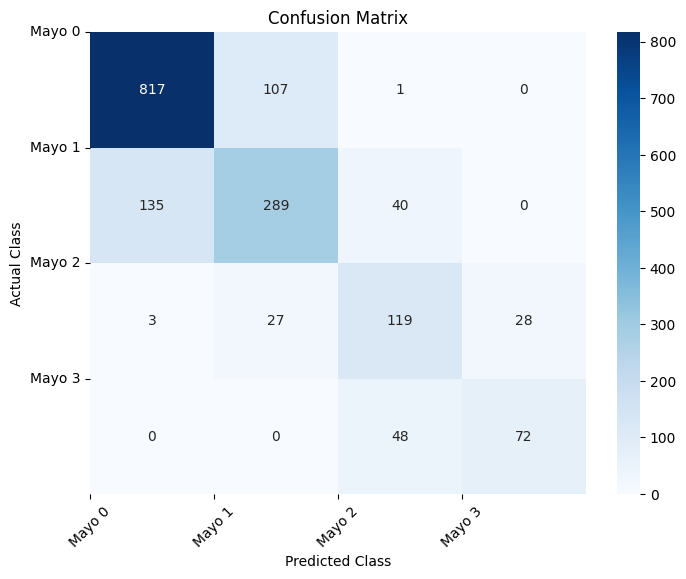

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
qwk_score,▃▆▆▅▆▅▆▆▅▃▄▁▁▂▅▃▂▄▄▇▅▄▅▆▅▄▇▇▆▅▅▆▇▇▅██▆▇▆
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▃▃▄▄▆▆▇▇▇▇█████████████████████████████
train loss,█▆▆▅▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▅▅▄▄▅▆▆▄▅▆▂▃▃▆▅▄▅▅▇▆▅▆▇▆▆▇█▆▆▆▇▇▆▅▇▇▆▆▆
val loss,▁▁▁▁▁▂▂▂▃▄▄▅▄▅▄▆▄▄▅▆▇▇▆▇▇▇▇▇▇███████▇▇▇█


wandb: Agent Starting Run: xm95nq2r with config:
wandb: 	batch_size: 16
wandb: 	lr: 0.0005
wandb: 	model_name: maxvit_base_tf_224
wandb: 	optimizer: AdamW
wandb: 	use_lrscheduling: True


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:   1 | Train acc: 71.98 | Val acc: 77.16 | Train loss: 0.6356 | Val loss: 0.5604 | QWK Score: 0.877 | Confusion matrix: [[491  16   0   0]
 [118 122  21   2]
 [  1  25  54  30]
 [  0   1   5  73]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   2 | Train acc: 77.31 | Val acc: 74.77 | Train loss: 0.5149 | Val loss: 0.5577 | QWK Score: 0.858 | Confusion matrix: [[409  93   4   1]
 [ 38 166  58   1]
 [  0  10  73  27]
 [  0   0  10  69]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   3 | Train acc: 79.01 | Val acc: 79.04 | Train loss: 0.4863 | Val loss: 0.5396 | QWK Score: 0.884 | Confusion matrix: [[476  31   0   0]
 [ 80 158  24   1]
 [  0  32  62  16]
 [  0   0  17  62]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   4 | Train acc: 80.48 | Val acc: 76.96 | Train loss: 0.4538 | Val loss: 0.5556 | QWK Score: 0.866 | Confusion matrix: [[423  78   5   1]
 [ 36 165  60   2]
 [  0   7  81  22]
 [  0   0  10  69]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:   5 | Train acc: 81.44 | Val acc: 76.96 | Train loss: 0.4320 | Val loss: 0.4903 | QWK Score: 0.868 | Confusion matrix: [[461  45   0   1]
 [ 85 153  24   1]
 [  0  32  59  19]
 [  0   1  13  65]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   6 | Train acc: 83.07 | Val acc: 78.73 | Train loss: 0.3993 | Val loss: 0.4989 | QWK Score: 0.869 | Confusion matrix: [[435  71   0   1]
 [ 46 202  15   0]
 [  0  41  58  11]
 [  0   2  17  60]]


100%|██████████| 60/60 [00:11<00:00,  5.27it/s]


epoch:   7 | Train acc: 84.13 | Val acc: 76.33 | Train loss: 0.3761 | Val loss: 0.5719 | QWK Score: 0.869 | Confusion matrix: [[437  66   3   1]
 [ 49 168  41   5]
 [  0  14  48  48]
 [  0   0   0  79]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   8 | Train acc: 85.58 | Val acc: 78.10 | Train loss: 0.3415 | Val loss: 0.5442 | QWK Score: 0.880 | Confusion matrix: [[449  55   3   0]
 [ 62 157  44   0]
 [  0  14  76  20]
 [  0   0  12  67]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:   9 | Train acc: 87.15 | Val acc: 77.89 | Train loss: 0.3128 | Val loss: 0.5529 | QWK Score: 0.878 | Confusion matrix: [[454  52   1   0]
 [ 68 159  35   1]
 [  1  17  71  21]
 [  0   0  16  63]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  10 | Train acc: 88.85 | Val acc: 77.69 | Train loss: 0.2691 | Val loss: 0.6232 | QWK Score: 0.869 | Confusion matrix: [[427  78   2   0]
 [ 49 184  28   2]
 [  0  20  74  16]
 [  0   1  18  60]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  11 | Train acc: 90.57 | Val acc: 76.23 | Train loss: 0.2396 | Val loss: 0.7432 | QWK Score: 0.829 | Confusion matrix: [[442  65   0   0]
 [ 48 210   5   0]
 [  1  59  47   3]
 [  0   8  39  32]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  12 | Train acc: 91.73 | Val acc: 75.39 | Train loss: 0.2145 | Val loss: 0.6744 | QWK Score: 0.851 | Confusion matrix: [[397 108   1   1]
 [ 43 190  30   0]
 [  0  21  83   6]
 [  0   0  26  53]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  13 | Train acc: 92.69 | Val acc: 75.08 | Train loss: 0.1833 | Val loss: 0.7755 | QWK Score: 0.850 | Confusion matrix: [[467  33   5   2]
 [ 95 109  57   2]
 [  2   6  83  19]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  14 | Train acc: 94.17 | Val acc: 78.31 | Train loss: 0.1589 | Val loss: 0.6367 | QWK Score: 0.861 | Confusion matrix: [[449  56   1   1]
 [ 61 174  26   2]
 [  0  29  61  20]
 [  2   2   8  67]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  15 | Train acc: 98.24 | Val acc: 79.67 | Train loss: 0.0571 | Val loss: 0.8516 | QWK Score: 0.877 | Confusion matrix: [[450  55   2   0]
 [ 59 182  21   1]
 [  0  30  70  10]
 [  1   0  16  62]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  16 | Train acc: 98.95 | Val acc: 81.23 | Train loss: 0.0357 | Val loss: 0.8552 | QWK Score: 0.885 | Confusion matrix: [[470  35   2   0]
 [ 65 176  21   1]
 [  1  29  66  14]
 [  1   1  10  67]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  17 | Train acc: 99.07 | Val acc: 80.29 | Train loss: 0.0279 | Val loss: 0.9048 | QWK Score: 0.879 | Confusion matrix: [[460  44   3   0]
 [ 63 174  26   0]
 [  1  22  77  10]
 [  1   0  19  59]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  18 | Train acc: 99.21 | Val acc: 81.44 | Train loss: 0.0199 | Val loss: 0.9319 | QWK Score: 0.893 | Confusion matrix: [[459  46   2   0]
 [ 55 186  21   1]
 [  0  27  71  12]
 [  0   0  14  65]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  19 | Train acc: 99.33 | Val acc: 79.87 | Train loss: 0.0167 | Val loss: 1.0023 | QWK Score: 0.879 | Confusion matrix: [[454  51   2   0]
 [ 60 180  22   1]
 [  1  27  72  10]
 [  0   1  18  60]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  20 | Train acc: 99.44 | Val acc: 79.98 | Train loss: 0.0178 | Val loss: 1.0107 | QWK Score: 0.882 | Confusion matrix: [[449  57   0   1]
 [ 56 181  24   2]
 [  0  24  75  11]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  21 | Train acc: 99.57 | Val acc: 79.77 | Train loss: 0.0130 | Val loss: 1.1233 | QWK Score: 0.884 | Confusion matrix: [[450  57   0   0]
 [ 58 179  26   0]
 [  1  21  81   7]
 [  0   0  24  55]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  22 | Train acc: 99.36 | Val acc: 81.02 | Train loss: 0.0170 | Val loss: 1.0478 | QWK Score: 0.891 | Confusion matrix: [[451  55   1   0]
 [ 52 190  20   1]
 [  0  25  73  12]
 [  0   0  16  63]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  23 | Train acc: 99.66 | Val acc: 79.04 | Train loss: 0.0105 | Val loss: 1.3111 | QWK Score: 0.869 | Confusion matrix: [[465  42   0   0]
 [ 77 174  12   0]
 [  2  38  64   6]
 [  1   1  22  55]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  24 | Train acc: 99.44 | Val acc: 79.67 | Train loss: 0.0161 | Val loss: 1.1739 | QWK Score: 0.886 | Confusion matrix: [[470  37   0   0]
 [ 82 154  26   1]
 [  1  21  76  12]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  25 | Train acc: 99.58 | Val acc: 79.67 | Train loss: 0.0115 | Val loss: 1.1626 | QWK Score: 0.884 | Confusion matrix: [[465  42   0   0]
 [ 74 166  22   1]
 [  1  26  73  10]
 [  0   0  19  60]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  26 | Train acc: 99.55 | Val acc: 80.19 | Train loss: 0.0145 | Val loss: 1.1532 | QWK Score: 0.883 | Confusion matrix: [[465  42   0   0]
 [ 69 177  16   1]
 [  1  29  70  10]
 [  0   1  21  57]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  27 | Train acc: 99.59 | Val acc: 79.67 | Train loss: 0.0122 | Val loss: 1.1081 | QWK Score: 0.881 | Confusion matrix: [[454  51   2   0]
 [ 66 176  21   0]
 [  1  25  74  10]
 [  0   0  19  60]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  28 | Train acc: 99.61 | Val acc: 78.94 | Train loss: 0.0122 | Val loss: 1.2026 | QWK Score: 0.869 | Confusion matrix: [[454  51   2   0]
 [ 60 179  24   0]
 [  1  27  75   7]
 [  1   0  29  49]]


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch:  29 | Train acc: 99.63 | Val acc: 79.87 | Train loss: 0.0125 | Val loss: 1.1130 | QWK Score: 0.885 | Confusion matrix: [[455  52   0   0]
 [ 58 182  23   0]
 [  1  28  70  11]
 [  0   0  20  59]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  30 | Train acc: 99.83 | Val acc: 80.19 | Train loss: 0.0056 | Val loss: 1.1761 | QWK Score: 0.885 | Confusion matrix: [[459  47   1   0]
 [ 61 183  19   0]
 [  1  29  69  11]
 [  0   0  21  58]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  31 | Train acc: 99.85 | Val acc: 79.98 | Train loss: 0.0043 | Val loss: 1.1832 | QWK Score: 0.885 | Confusion matrix: [[452  54   1   0]
 [ 56 183  24   0]
 [  1  25  73  11]
 [  0   0  20  59]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  32 | Train acc: 99.84 | Val acc: 79.87 | Train loss: 0.0033 | Val loss: 1.2057 | QWK Score: 0.884 | Confusion matrix: [[459  47   1   0]
 [ 63 176  24   0]
 [  1  26  72  11]
 [  0   0  20  59]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  33 | Train acc: 99.85 | Val acc: 80.81 | Train loss: 0.0030 | Val loss: 1.2295 | QWK Score: 0.892 | Confusion matrix: [[461  45   1   0]
 [ 61 178  24   0]
 [  0  24  75  11]
 [  0   0  18  61]]
epoch:  33 | Test acc: 76.39 | Test loss: 1.4956 | Test QWK Score: 0.848 | Test Confusion matrix: [[822 103   0   0]
 [126 292  42   4]
 [  3  36 105  33]
 [  1   1  49  69]]
Early stopping at epoch 33
epoch:  33 | Test acc: 76.39 | Test loss: 1.4956 | Test QWK Score: 0.848 | Test Confusion matrix: [[822 103   0   0]
 [126 292  42   4]
 [  3  36 105  33]
 [  1   1  49  69]]


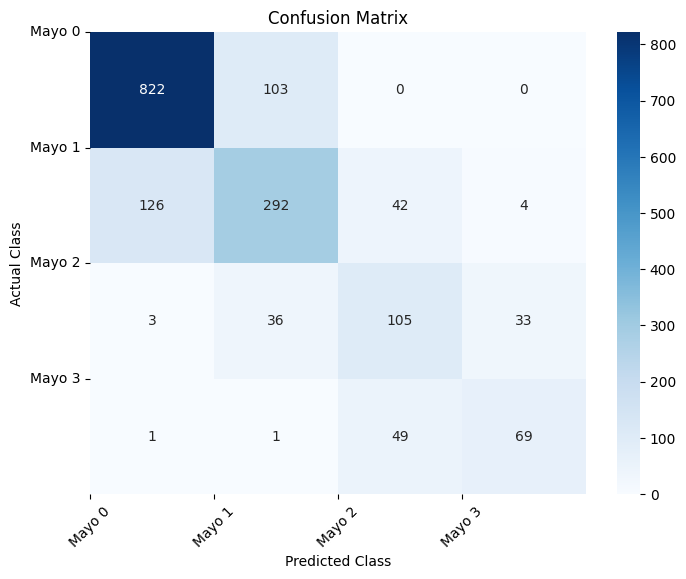

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr,█████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
qwk_score,▆▄▇▅▅▅▅▇▆▅▁▃▃▅▆▇▇█▆▇▇█▅▇▇▇▇▅▇▇▇▇█
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▂▃▃▃▄▄▄▅▅▆▆▆▇███████████████████
train loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▄▁▅▃▃▅▃▅▄▄▃▂▁▅▆█▇█▆▆▆█▅▆▆▇▆▅▆▇▆▆▇
val loss,▂▂▁▂▁▁▂▁▂▂▃▃▃▂▄▄▅▅▅▅▆▆█▇▇▇▆▇▆▇▇▇▇


wandb: Agent Starting Run: 6o90d8a9 with config:
wandb: 	batch_size: 16
wandb: 	lr: 0.0002
wandb: 	model_name: maxvit_base_tf_224
wandb: 	optimizer: AdamW
wandb: 	use_lrscheduling: True


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:   1 | Train acc: 73.78 | Val acc: 73.10 | Train loss: 0.6076 | Val loss: 0.5977 | QWK Score: 0.839 | Confusion matrix: [[497  10   0   0]
 [152 100   8   3]
 [  3  49  35  23]
 [  0   5   5  69]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:   2 | Train acc: 79.12 | Val acc: 79.67 | Train loss: 0.4744 | Val loss: 0.4680 | QWK Score: 0.890 | Confusion matrix: [[463  44   0   0]
 [ 71 163  28   1]
 [  0  22  70  18]
 [  0   0  11  68]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:   3 | Train acc: 81.31 | Val acc: 77.79 | Train loss: 0.4294 | Val loss: 0.5606 | QWK Score: 0.875 | Confusion matrix: [[485  22   0   0]
 [101 141  20   1]
 [  0  33  62  15]
 [  0   1  20  58]]


100%|██████████| 60/60 [00:11<00:00,  5.26it/s]


epoch:   4 | Train acc: 84.05 | Val acc: 78.31 | Train loss: 0.3769 | Val loss: 0.5045 | QWK Score: 0.878 | Confusion matrix: [[422  85   0   0]
 [ 38 197  27   1]
 [  0  29  66  15]
 [  0   0  13  66]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:   5 | Train acc: 85.89 | Val acc: 78.21 | Train loss: 0.3247 | Val loss: 0.5107 | QWK Score: 0.881 | Confusion matrix: [[437  70   0   0]
 [ 55 187  20   1]
 [  0  28  57  25]
 [  0   0  10  69]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   6 | Train acc: 88.81 | Val acc: 76.43 | Train loss: 0.2719 | Val loss: 0.5710 | QWK Score: 0.873 | Confusion matrix: [[434  72   1   0]
 [ 54 165  42   2]
 [  2  13  59  36]
 [  0   0   4  75]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   7 | Train acc: 91.73 | Val acc: 76.85 | Train loss: 0.2164 | Val loss: 0.6190 | QWK Score: 0.875 | Confusion matrix: [[453  51   3   0]
 [ 60 166  33   4]
 [  0  19  43  48]
 [  0   0   4  75]]


100%|██████████| 60/60 [00:11<00:00,  5.28it/s]


epoch:   8 | Train acc: 93.12 | Val acc: 77.37 | Train loss: 0.1724 | Val loss: 0.6623 | QWK Score: 0.869 | Confusion matrix: [[451  52   4   0]
 [ 76 157  29   1]
 [  0  21  73  16]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:   9 | Train acc: 94.83 | Val acc: 79.35 | Train loss: 0.1376 | Val loss: 0.7588 | QWK Score: 0.874 | Confusion matrix: [[463  42   2   0]
 [ 73 157  32   1]
 [  1  18  84   7]
 [  1   0  21  57]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  10 | Train acc: 96.06 | Val acc: 76.96 | Train loss: 0.1077 | Val loss: 0.7970 | QWK Score: 0.869 | Confusion matrix: [[447  58   0   2]
 [ 64 159  36   4]
 [  0  16  60  34]
 [  0   0   7  72]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  11 | Train acc: 96.01 | Val acc: 73.51 | Train loss: 0.1062 | Val loss: 0.8953 | QWK Score: 0.835 | Confusion matrix: [[386 118   3   0]
 [ 39 200  24   0]
 [  0  30  76   4]
 [  0   0  36  43]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  12 | Train acc: 96.92 | Val acc: 78.62 | Train loss: 0.0847 | Val loss: 0.7959 | QWK Score: 0.874 | Confusion matrix: [[466  40   1   0]
 [ 81 150  30   2]
 [  1  16  77  16]
 [  1   0  17  61]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  13 | Train acc: 97.18 | Val acc: 77.06 | Train loss: 0.0792 | Val loss: 0.8653 | QWK Score: 0.857 | Confusion matrix: [[476  31   0   0]
 [ 97 141  24   1]
 [  5  30  60  15]
 [  1   2  14  62]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  14 | Train acc: 99.04 | Val acc: 80.19 | Train loss: 0.0297 | Val loss: 0.8851 | QWK Score: 0.880 | Confusion matrix: [[454  52   1   0]
 [ 66 173  23   1]
 [  0  21  82   7]
 [  1   1  17  60]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  15 | Train acc: 99.59 | Val acc: 79.67 | Train loss: 0.0147 | Val loss: 0.9573 | QWK Score: 0.886 | Confusion matrix: [[448  58   1   0]
 [ 58 181  23   1]
 [  0  22  71  17]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.15it/s]


epoch:  16 | Train acc: 99.61 | Val acc: 79.67 | Train loss: 0.0117 | Val loss: 0.9906 | QWK Score: 0.883 | Confusion matrix: [[465  41   1   0]
 [ 76 160  26   1]
 [  1  18  77  14]
 [  0   1  16  62]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  17 | Train acc: 99.49 | Val acc: 80.29 | Train loss: 0.0141 | Val loss: 1.0271 | QWK Score: 0.885 | Confusion matrix: [[458  48   1   0]
 [ 69 172  21   1]
 [  0  21  80   9]
 [  0   1  18  60]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  18 | Train acc: 99.72 | Val acc: 79.98 | Train loss: 0.0076 | Val loss: 1.0677 | QWK Score: 0.882 | Confusion matrix: [[464  41   2   0]
 [ 73 167  22   1]
 [  0  23  74  13]
 [  0   2  15  62]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  19 | Train acc: 99.61 | Val acc: 80.19 | Train loss: 0.0100 | Val loss: 1.1159 | QWK Score: 0.881 | Confusion matrix: [[479  27   1   0]
 [ 87 148  26   2]
 [  0  18  82  10]
 [  1   1  17  60]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  20 | Train acc: 99.63 | Val acc: 80.19 | Train loss: 0.0088 | Val loss: 1.0829 | QWK Score: 0.887 | Confusion matrix: [[448  58   1   0]
 [ 60 181  21   1]
 [  0  24  76  10]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  21 | Train acc: 99.66 | Val acc: 80.60 | Train loss: 0.0089 | Val loss: 1.1023 | QWK Score: 0.890 | Confusion matrix: [[461  46   0   0]
 [ 71 171  20   1]
 [  0  19  79  12]
 [  0   1  16  62]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  22 | Train acc: 99.77 | Val acc: 80.08 | Train loss: 0.0056 | Val loss: 1.1909 | QWK Score: 0.888 | Confusion matrix: [[460  46   1   0]
 [ 69 169  24   1]
 [  0  21  75  14]
 [  0   0  15  64]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  23 | Train acc: 99.69 | Val acc: 79.56 | Train loss: 0.0089 | Val loss: 1.1991 | QWK Score: 0.880 | Confusion matrix: [[445  61   1   0]
 [ 61 187  15   0]
 [  0  30  72   8]
 [  0   1  19  59]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  24 | Train acc: 99.85 | Val acc: 80.19 | Train loss: 0.0050 | Val loss: 1.2980 | QWK Score: 0.888 | Confusion matrix: [[468  38   1   0]
 [ 78 157  27   1]
 [  0  21  81   8]
 [  0   0  16  63]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  25 | Train acc: 99.79 | Val acc: 79.35 | Train loss: 0.0051 | Val loss: 1.3131 | QWK Score: 0.878 | Confusion matrix: [[457  49   1   0]
 [ 72 167  22   2]
 [  0  26  74  10]
 [  0   2  14  63]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  26 | Train acc: 99.73 | Val acc: 80.29 | Train loss: 0.0064 | Val loss: 1.3164 | QWK Score: 0.887 | Confusion matrix: [[447  59   1   0]
 [ 57 181  23   2]
 [  0  24  76  10]
 [  0   0  13  66]]


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  27 | Train acc: 99.65 | Val acc: 80.08 | Train loss: 0.0096 | Val loss: 1.2396 | QWK Score: 0.877 | Confusion matrix: [[472  34   1   0]
 [ 82 162  18   1]
 [  2  27  70  11]
 [  1   1  13  64]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  28 | Train acc: 99.70 | Val acc: 79.56 | Train loss: 0.0070 | Val loss: 1.2826 | QWK Score: 0.882 | Confusion matrix: [[461  45   1   0]
 [ 72 165  24   2]
 [  0  22  69  19]
 [  1   0  10  68]]


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  29 | Train acc: 99.70 | Val acc: 80.50 | Train loss: 0.0060 | Val loss: 1.2304 | QWK Score: 0.885 | Confusion matrix: [[462  44   1   0]
 [ 67 170  25   1]
 [  0  22  77  11]
 [  1   0  15  63]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  30 | Train acc: 99.75 | Val acc: 80.50 | Train loss: 0.0056 | Val loss: 1.2791 | QWK Score: 0.882 | Confusion matrix: [[474  32   1   0]
 [ 79 162  21   1]
 [  0  28  74   8]
 [  1   1  15  62]]


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  31 | Train acc: 99.78 | Val acc: 80.71 | Train loss: 0.0060 | Val loss: 1.2792 | QWK Score: 0.885 | Confusion matrix: [[466  40   1   0]
 [ 70 167  25   1]
 [  0  21  77  12]
 [  1   1  13  64]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  32 | Train acc: 99.78 | Val acc: 80.81 | Train loss: 0.0058 | Val loss: 1.2311 | QWK Score: 0.888 | Confusion matrix: [[466  40   1   0]
 [ 75 167  20   1]
 [  0  23  74  13]
 [  1   0  10  68]]
overwriting the best model!


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  33 | Train acc: 99.88 | Val acc: 80.71 | Train loss: 0.0026 | Val loss: 1.3390 | QWK Score: 0.888 | Confusion matrix: [[475  31   1   0]
 [ 78 156  27   2]
 [  0  20  76  14]
 [  1   0  11  67]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  34 | Train acc: 99.73 | Val acc: 78.94 | Train loss: 0.0054 | Val loss: 1.4086 | QWK Score: 0.875 | Confusion matrix: [[447  58   2   0]
 [ 63 176  22   2]
 [  0  29  70  11]
 [  0   1  14  64]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  35 | Train acc: 99.76 | Val acc: 79.04 | Train loss: 0.0073 | Val loss: 1.3548 | QWK Score: 0.876 | Confusion matrix: [[447  59   1   0]
 [ 60 173  28   2]
 [  0  25  73  12]
 [  1   0  13  65]]


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  36 | Train acc: 99.73 | Val acc: 80.29 | Train loss: 0.0085 | Val loss: 1.3003 | QWK Score: 0.887 | Confusion matrix: [[478  29   0   0]
 [ 88 157  17   1]
 [  0  28  74   8]
 [  0   1  17  61]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  37 | Train acc: 99.80 | Val acc: 80.60 | Train loss: 0.0044 | Val loss: 1.2690 | QWK Score: 0.889 | Confusion matrix: [[460  46   1   0]
 [ 61 172  29   1]
 [  0  22  80   8]
 [  0   0  18  61]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  38 | Train acc: 99.76 | Val acc: 79.77 | Train loss: 0.0061 | Val loss: 1.2952 | QWK Score: 0.885 | Confusion matrix: [[467  39   1   0]
 [ 76 156  29   2]
 [  0  22  79   9]
 [  0   0  16  63]]


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  39 | Train acc: 99.81 | Val acc: 78.10 | Train loss: 0.0042 | Val loss: 1.3592 | QWK Score: 0.871 | Confusion matrix: [[425  81   1   0]
 [ 51 183  27   2]
 [  0  23  78   9]
 [  0   1  15  63]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  40 | Train acc: 99.78 | Val acc: 80.60 | Train loss: 0.0054 | Val loss: 1.2542 | QWK Score: 0.886 | Confusion matrix: [[463  43   1   0]
 [ 66 175  20   2]
 [  1  27  72  10]
 [  0   0  16  63]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  41 | Train acc: 99.68 | Val acc: 79.77 | Train loss: 0.0094 | Val loss: 1.1361 | QWK Score: 0.882 | Confusion matrix: [[462  44   1   0]
 [ 70 170  22   1]
 [  0  25  76   9]
 [  0   1  21  57]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  42 | Train acc: 99.75 | Val acc: 79.77 | Train loss: 0.0071 | Val loss: 1.2079 | QWK Score: 0.886 | Confusion matrix: [[466  40   1   0]
 [ 74 158  29   2]
 [  0  20  78  12]
 [  0   0  16  63]]


100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


epoch:  43 | Train acc: 99.87 | Val acc: 80.08 | Train loss: 0.0037 | Val loss: 1.2618 | QWK Score: 0.886 | Confusion matrix: [[464  42   1   0]
 [ 70 165  26   2]
 [  0  24  77   9]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  44 | Train acc: 99.87 | Val acc: 80.60 | Train loss: 0.0030 | Val loss: 1.2588 | QWK Score: 0.888 | Confusion matrix: [[469  37   1   0]
 [ 72 166  24   1]
 [  1  25  76   8]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


epoch:  45 | Train acc: 99.90 | Val acc: 80.50 | Train loss: 0.0018 | Val loss: 1.2791 | QWK Score: 0.887 | Confusion matrix: [[469  37   1   0]
 [ 69 169  24   1]
 [  1  28  72   9]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


epoch:  46 | Train acc: 99.92 | Val acc: 80.71 | Train loss: 0.0017 | Val loss: 1.2736 | QWK Score: 0.890 | Confusion matrix: [[462  44   1   0]
 [ 63 175  24   1]
 [  0  25  75  10]
 [  0   0  17  62]]


100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


epoch:  47 | Train acc: 99.87 | Val acc: 80.40 | Train loss: 0.0020 | Val loss: 1.3029 | QWK Score: 0.886 | Confusion matrix: [[470  36   1   0]
 [ 72 162  27   2]
 [  1  24  77   8]
 [  0   0  17  62]]
epoch:  47 | Test acc: 76.81 | Test loss: 1.5343 | Test QWK Score: 0.843 | Test Confusion matrix: [[839  84   2   0]
 [146 274  38   6]
 [  5  33 111  28]
 [  2   0  47  71]]
Early stopping at epoch 47
epoch:  47 | Test acc: 76.81 | Test loss: 1.5343 | Test QWK Score: 0.843 | Test Confusion matrix: [[839  84   2   0]
 [146 274  38   6]
 [  5  33 111  28]
 [  2   0  47  71]]


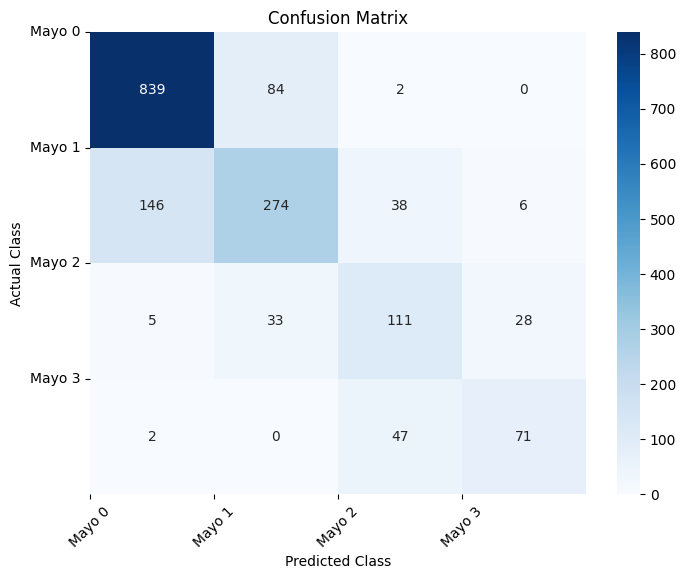

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,███████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
qwk_score,▂█▆▇▇▆▅▆▅▁▆▄▇▇▇▇▇██▇█▆█▇▇▇▇█▆▆██▇▆▇▇▇██▇
test acc,▁▁
test loss,▁▁
test_lr,▁▁
test_qwk_score,▁▁
train acc,▁▂▃▄▄▅▆▇▇▇▇▇████████████████████████████
train loss,█▆▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▇▅▆▆▄▅▇▅▁▆▅▇▇█▇▇█▇▇▇▇█▇████▆▆██▇▆▇▇▇███
val loss,▂▁▂▁▁▂▂▃▃▄▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██▇▇▇█▆▇▇▇▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [5]:
import os
import torch
import torch.nn as nn
from torch.optim import lr_scheduler, AdamW
import torchvision.transforms as transforms
from datetime import datetime
import time
import random
import numpy as np
from utils import UCMayo4, get_dataset_mean_and_std
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# Setup directories and datasets
train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"

channel_means = [0.416, 0.288, 0.219]
channel_stds = [0.299, 0.221, 0.178]

print("\nCreate weights directory for checkpoints!")
dirName = "weights"
try:
    os.makedirs(dirName)
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")


# Function to set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# Create the training function that will use the hyperparameters defined in the sweep
def train_with_hyperparameters():
    wandb.init()
    config = wandb.config

    set_seed(35)

    # Hyperparameters
    batch_size = config.batch_size
    learning_rate = config.lr
    weight_decay = 0.001
    model_name = config.model_name
    optimizer_name = config.optimizer
    num_classes = 4
    num_worker = 4
    num_epoch = 50
    best_acc = 0
    early_stopping_thresh = 15
    LRScheduling_patience = 10
    lrs_factor = 0.2
    best_threshold = 0.0001
    early_stop_counter = 0

    # Setup directories and datasets
    train_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
    val_dir = "/content/gdrive/My Drive/data/train_and_validation_sets"
    #print("hwhw")
    #channel_means, channel_stds = get_dataset_mean_and_std(train_dir)
    normalize = transforms.Normalize(mean=channel_means, std=channel_stds)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-180, 180)),
        transforms.ToTensor(),
        normalize
    ])
    train_dataset = UCMayo4(train_dir, transform=train_transform, val_split=0.1, subset='train')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker, pin_memory=True)

    val_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(), normalize])
    val_dataset = UCMayo4(val_dir, transform=val_transform, val_split=0.1, subset='val')
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker, pin_memory=True)

    test_dir = "/content/gdrive/My Drive/test_set"
    test_dataset = UCMayo4(test_dir, transform=val_transform,val_split=1, subset='val')
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker,
                                            pin_memory=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)
    model = timm.create_model('maxvit_base_tf_224.in21k', pretrained=True, num_classes=num_classes)
    model.to(device)

    # Setup optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=lrs_factor, patience=LRScheduling_patience, threshold=best_threshold, verbose=True)

    criterion = nn.CrossEntropyLoss()
    class_names = ["Mayo 0", "Mayo 1", "Mayo 2", "Mayo 3"]

    # Training loop
    for epoch in range(num_epoch):
        #print("hehehe")
        model.train()
        training_loss, train_correct = 0.0, 0
        i=0
        for data, target in tqdm(train_loader):
            #print("train {}".format(i))
            #i+=1
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            prediction = output.argmax(dim=1, keepdim=True)
            train_correct += prediction.eq(target.view_as(prediction)).sum().item()
            training_loss += loss.item()
        training_loss /= len(train_loader)
        train_accuracy = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        y_true, y_pred = [], []
        #print("validation")
        with torch.no_grad():
            for data, target in tqdm(val_loader):
                #print("validation")
                data, target = data.to(device), target.to(device)
                y_true.extend(target.cpu().tolist())
                output = model(data)
                loss = criterion(output, target)
                prediction = output.argmax(dim=1, keepdim=True)
                y_pred.extend(prediction.cpu().tolist())
                val_correct += prediction.eq(target.view_as(prediction)).sum().item()
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_accuracy = val_correct / len(val_loader.dataset)

        # Update the scheduler
        if config.use_lrscheduling:
            scheduler.step(val_accuracy)

        cm_4class = confusion_matrix(y_true, y_pred)
        all_kappa_score_weighted = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        flattened_preds = [item for sublist in y_pred for item in sublist] if isinstance(y_pred[0], list) else y_pred
        print("epoch: {:3.0f}".format(epoch + 1) + " | Train acc: {:4.2f}".format(
            train_accuracy * 100) + " | Val acc: {:4.2f}".format(
            val_accuracy * 100) + " | Train loss: {:6.4f}".format(
            training_loss) + " | Val loss: {:6.4f}".format(
            val_loss) + " | QWK Score: {:4.3f}".format(
            all_kappa_score_weighted) + " | Confusion matrix: {}".format(cm_4class))
        wandb.log({
            "epoch": epoch + 1,
            "lr": optimizer.param_groups[0]['lr'],
            'train loss': training_loss,
            'val loss': val_loss,
            'train acc': train_accuracy,
            'val acc': val_accuracy,
            'qwk_score': all_kappa_score_weighted,
            'conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=flattened_preds, class_names=class_names)
        })

        if val_accuracy > best_acc * (1 + best_threshold):
            early_stop_counter = 0
            best_acc = val_accuracy
            print("overwriting the best model!")
            wandb.run.summary["best accuracy"] = best_acc
            torch.save(model.state_dict(), "weights/best_" + model_name + '.pth.tar')
        else:
            early_stop_counter += 1
        if early_stop_counter >= early_stopping_thresh:
            model.eval()
            test_loss, test_correct = 0.0, 0
            y_true_test, y_pred_test = [], []
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    y_true_test.extend(target.cpu().tolist())
                    output = model(data)
                    loss = criterion(output, target)
                    prediction = output.argmax(dim=1, keepdim=True)
                    y_pred_test.extend(prediction.cpu().tolist())
                    test_correct += prediction.eq(target.view_as(prediction)).sum().item()
                    test_loss += loss.item()
            test_loss /= len(test_loader)
            test_accuracy = test_correct / len(test_loader.dataset)
            cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
            all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
            flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
            print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
                test_accuracy * 100) + " | Test loss: {:6.4f}".format(
                test_loss) + " | Test QWK Score: {:4.3f}".format(
                all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
            wandb.log({
                "test_lr": optimizer.param_groups[0]['lr'],
                'test loss': test_loss,
                'test acc': test_accuracy,
                'test_qwk_score': all_kappa_score_weighted_test,
                'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_names)
            })
            print("Early stopping at epoch {}".format(epoch + 1))
            break
    model.eval()
    test_loss, test_correct = 0.0, 0
    y_true_test, y_pred_test = [], []
    with torch.no_grad():
        for data, target in test_loader:
            #print("validation")
            data, target = data.to(device), target.to(device)
            y_true_test.extend(target.cpu().tolist())
            output = model(data)
            loss = criterion(output, target)
            prediction = output.argmax(dim=1, keepdim=True)
            y_pred_test.extend(prediction.cpu().tolist())
            test_correct += prediction.eq(target.view_as(prediction)).sum().item()
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(test_loader.dataset)
    cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
    all_kappa_score_weighted_test = cohen_kappa_score(y_true_test, y_pred_test, weights="quadratic")
    flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
    print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
        test_accuracy * 100) + " | Test loss: {:6.4f}".format(
        test_loss) + " | Test QWK Score: {:4.3f}".format(
        all_kappa_score_weighted_test) + " | Test Confusion matrix: {}".format(cm_4class_test))
    wandb.log({
        "test_lr": optimizer.param_groups[0]['lr'],
        'test loss': test_loss,
        'test acc': test_accuracy,
        'test_qwk_score': all_kappa_score_weighted_test,
        'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_names)
    })
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names, rotation=0)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title("Confusion Matrix")
    plt.show()
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {'values': [16]},
        'lr': {'values': [0.0001, 0.0005, 0.0002]},
        'model_name': {'values': ['maxvit_base_tf_224']},
        'optimizer': {'values': ['AdamW']},
        'use_lrscheduling': {'values': [True]},
    }
}

# Initialize the sweep and start it
sweep_id = wandb.sweep(sweep_config, project='DI725-Project-EmreCakmakyurdu-UCS-Transformer2')
wandb.agent(sweep_id, train_with_hyperparameters)
